# The Very Basics of Musical Instruments Classification using Machine Learning
## MFCC, Deep Learning (Gentle introduction using Keras), Sequential Model, Grid Search

<br>

<p align="left">
<img src="./img/businesscard.jpg" width="300px" alt="Business Card" align="left" >
</p>
<br>



In [1]:
%%html
<iframe width="560" height="315" src="https://www.youtube.com/embed/Oiq428Q4J1s" frameborder="0" 
allow="accelerometer; encrypted-media; gyroscope; picture-in-picture"></iframe>

## Imports

In [4]:
# Imports

#General
import numpy as np
import pickle
import itertools

# System
import os, fnmatch

# Visualization
import seaborn #visualization library, must be imported before all other plotting libraries
import matplotlib.pyplot as plt
from IPython.core.display import HTML, display, Image

# Machine Learning
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import StratifiedShuffleSplit, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import recall_score, precision_score, accuracy_score
from sklearn.metrics import confusion_matrix, f1_score, classification_report
from sklearn.metrics import classification_report

# Deep Learning
from keras import backend as K
from keras.layers import Input, Dense
from keras.models import Model, Sequential
from keras.optimizers import SGD
from keras.callbacks import History
from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import to_categorical
from keras.utils import plot_model

# Random Seed
import tensorflow
from numpy.random import seed
seed(1)
tensorflow.random.set_seed(2)

# Audio
import librosa.display, librosa

# Configurations
path='./audio/london_phill_dataset_multi/'

## Auxiliary Functions

In [5]:
# Function to Display a Website
def show_web(url):
    html_code='<center><iframe src="%s" width="800" height="600" frameborder="0" marginheight="0" marginwidth="0">Loading...</iframe></center>' \
		% (url)
    display(HTML(html_code))

## Get filenames

In [6]:
# Get files in data path

files = []
for root, dirnames, filenames in os.walk(path):
    for filename in fnmatch.filter(filenames, '*.mp3'):
        files.append(os.path.join(root, filename))

print("found %d audio files in %s"%(len(files),path))

found 600 audio files in ./audio/london_phill_dataset_multi/


## Load Labels

In [7]:
filename="inst_labels.pl"
# Load labels
with open(filename, "rb") as f:
    labels = pickle.load( open( filename, "rb" ) )

In [8]:
# Encode Labels
labelencoder = LabelEncoder()
labelencoder.fit(labels)
print(len(labelencoder.classes_), "classes:", ", ".join(list(labelencoder.classes_)))
classes_num = labelencoder.transform(labels)

6 classes: cello, flute, oboe, sax, trumpet, viola


## Parameters for MFCC

In [9]:
# Parameters
# Signal Processing Parameters
fs = 44100         # Sampling Frequency
n_fft = 2048       # length of the FFT window
hop_length = 512   # Number of samples between successive frames
n_mels = 128       # Number of Mel bands
n_mfcc = 13        # Number of MFCCs

# Machine Learning Parameters
testset_size = 0.25 #Percentage of data for Testing
n_neighbors=1       # Number of neighbors for kNN Classifier

## Save / Load Feature Vector

In [10]:
filename="mfcc_feature_vectors.pl"
# Load mfcc features from saved file
with open(filename, "rb") as f:
    scaled_feature_vectors = pickle.load( open( filename, "rb" ) )

## Train and Test Sets

In [11]:
# Create Train and Test Set
splitter = StratifiedShuffleSplit(n_splits=1, test_size=testset_size, random_state=0)
splits = splitter.split(scaled_feature_vectors, classes_num)
for train_index, test_index in splits:
    train_set = scaled_feature_vectors[train_index]
    test_set = scaled_feature_vectors[test_index]
    train_classes = classes_num[train_index]
    test_classes = classes_num[test_index]

In [12]:
# Check Set Shapes
print("train_set shape:",train_set.shape)
print("test_set shape:",test_set.shape)
print("train_classes shape:",train_classes.shape)
print("test_classes shape:",test_classes.shape)

train_set shape: (450, 13)
test_set shape: (150, 13)
train_classes shape: (450,)
test_classes shape: (150,)


In [13]:
# DNN
# Use Keras Backend Type
train_set_d=train_set.astype(K.floatx())
test_set_d=test_set.astype(K.floatx())

In [14]:
# One Hot encode
onehot_encoder = OneHotEncoder(sparse=False, categories='auto')
integer_encoded_train_classes =  train_classes.reshape(len( train_classes), 1)
onehot_encoded_train_classes = onehot_encoder.fit_transform(integer_encoded_train_classes,1)
integer_encoded_test_classes =  test_classes.reshape(len( test_classes),1)
onehot_encoded_test_classes = onehot_encoder.fit_transform(integer_encoded_test_classes,1)

In [15]:
# Reshape Sets for Keras
train_set_d=train_set.reshape(train_set_d.shape[0],1,train_set_d.shape[1])
test_set_d=test_set.reshape(test_set_d.shape[0],1,test_set_d.shape[1])
train_classes_d_hot=onehot_encoded_train_classes.reshape(onehot_encoded_train_classes.shape[0],1,
                                                         onehot_encoded_train_classes.shape[1])
test_classes_d_hot=onehot_encoded_test_classes.reshape(onehot_encoded_test_classes.shape[0],1,
                                                       onehot_encoded_test_classes.shape[1])

In [16]:
# Check Set Shapes
print("train_set shape:",train_set_d.shape)
print("test_set shape:",train_set_d.shape)
print("train_classes shape:",train_classes_d_hot.shape)
print("test_classes shape:",test_classes_d_hot.shape)

train_set shape: (450, 1, 13)
test_set shape: (450, 1, 13)
train_classes shape: (450, 1, 6)
test_classes shape: (150, 1, 6)


In [17]:
show_web("https://keras.io/getting-started/sequential-model-guide/")

In [18]:
def create_model(fc_layers=[4],
                 activation='relu',
                 optimizer='rmsprop'):
    model = Sequential()

    for i, size in enumerate(fc_layers):
        # Input Layer - includes the input_shape
        if i == 0:
            model.add(Dense(size,
                            activation=activation,
                            input_shape=(train_set.shape[1],)))
        else:
            model.add(Dense(size,
                            activation=activation))
            
    model.add(Dense(6,activation='softmax'))
    model.compile(optimizer = optimizer,
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

In [19]:
model = KerasClassifier(build_fn=create_model,
                        epochs=50, 
                        batch_size=5,
                        verbose=0)

In [20]:
param_grid = {'fc_layers': [[12],[12,6],[6,6,6], [6]],
              'activation':['relu','tanh'],
              'optimizer':('rmsprop','adam'),
              'epochs':[100, 150],
              'batch_size':[5]}

In [23]:
grid = GridSearchCV(model,
                    param_grid=param_grid,
                    return_train_score=True,
                    cv=5)

categorical_encoded_train_classes=to_categorical(integer_encoded_train_classes)
grid_results = grid.fit(train_set,onehot_encoded_train_classes, verbose=1)

print('Parameters of the best model: ')
print(grid_results.best_params_)

Epoch 1/100
72/72 [==============================] - 0s 639us/step - loss: 1.9065 - accuracy: 0.2139
Epoch 2/100
72/72 [==============================] - 0s 535us/step - loss: 1.6939 - accuracy: 0.3111
Epoch 3/100
72/72 [==============================] - 0s 531us/step - loss: 1.5221 - accuracy: 0.3806
Epoch 4/100
72/72 [==============================] - 0s 628us/step - loss: 1.3788 - accuracy: 0.4611
Epoch 5/100
72/72 [==============================] - 0s 621us/step - loss: 1.2559 - accuracy: 0.5361
Epoch 6/100
72/72 [==============================] - 0s 537us/step - loss: 1.1461 - accuracy: 0.5889
Epoch 7/100
72/72 [==============================] - 0s 632us/step - loss: 1.0404 - accuracy: 0.6583
Epoch 8/100
72/72 [==============================] - 0s 658us/step - loss: 0.9408 - accuracy: 0.6917
Epoch 9/100
72/72 [==============================] - 0s 625us/step - loss: 0.8511 - accuracy: 0.7333
Epoch 10/100
72/72 [==============================] - 0s 607us/step - loss: 0.7649 - accura

72/72 [==============================] - 0s 654us/step - loss: 0.0362 - accuracy: 0.9944
Epoch 82/100
72/72 [==============================] - 0s 675us/step - loss: 0.0364 - accuracy: 0.9944
Epoch 83/100
72/72 [==============================] - 0s 624us/step - loss: 0.0360 - accuracy: 0.9944
Epoch 84/100
72/72 [==============================] - 0s 619us/step - loss: 0.0349 - accuracy: 0.9944
Epoch 85/100
72/72 [==============================] - 0s 638us/step - loss: 0.0349 - accuracy: 0.9944
Epoch 86/100
72/72 [==============================] - 0s 598us/step - loss: 0.0344 - accuracy: 0.9944
Epoch 87/100
72/72 [==============================] - 0s 581us/step - loss: 0.0343 - accuracy: 0.9944
Epoch 88/100
72/72 [==============================] - 0s 673us/step - loss: 0.0333 - accuracy: 0.9944
Epoch 89/100
72/72 [==============================] - 0s 630us/step - loss: 0.0332 - accuracy: 0.9944
Epoch 90/100
72/72 [==============================] - 0s 588us/step - loss: 0.0326 - accuracy: 

72/72 [==============================] - 0s 614us/step - loss: 0.0491 - accuracy: 0.9833
Epoch 62/100
72/72 [==============================] - 0s 531us/step - loss: 0.0477 - accuracy: 0.9861
Epoch 63/100
72/72 [==============================] - 0s 637us/step - loss: 0.0471 - accuracy: 0.9833
Epoch 64/100
72/72 [==============================] - 0s 559us/step - loss: 0.0458 - accuracy: 0.9861
Epoch 65/100
72/72 [==============================] - 0s 533us/step - loss: 0.0446 - accuracy: 0.9889
Epoch 66/100
72/72 [==============================] - 0s 608us/step - loss: 0.0444 - accuracy: 0.9889
Epoch 67/100
72/72 [==============================] - 0s 564us/step - loss: 0.0428 - accuracy: 0.9889
Epoch 68/100
72/72 [==============================] - 0s 636us/step - loss: 0.0422 - accuracy: 0.9861
Epoch 69/100
72/72 [==============================] - 0s 638us/step - loss: 0.0411 - accuracy: 0.9861
Epoch 70/100
72/72 [==============================] - 0s 649us/step - loss: 0.0398 - accuracy: 

72/72 [==============================] - 0s 585us/step - loss: 0.1041 - accuracy: 0.9778
Epoch 42/100
72/72 [==============================] - 0s 522us/step - loss: 0.0999 - accuracy: 0.9778
Epoch 43/100
72/72 [==============================] - 0s 523us/step - loss: 0.0974 - accuracy: 0.9750
Epoch 44/100
72/72 [==============================] - 0s 521us/step - loss: 0.0943 - accuracy: 0.9750
Epoch 45/100
72/72 [==============================] - 0s 513us/step - loss: 0.0912 - accuracy: 0.9778
Epoch 46/100
72/72 [==============================] - 0s 519us/step - loss: 0.0887 - accuracy: 0.9778
Epoch 47/100
72/72 [==============================] - 0s 505us/step - loss: 0.0862 - accuracy: 0.9778
Epoch 48/100
72/72 [==============================] - 0s 500us/step - loss: 0.0832 - accuracy: 0.9806
Epoch 49/100
72/72 [==============================] - 0s 559us/step - loss: 0.0813 - accuracy: 0.9778
Epoch 50/100
72/72 [==============================] - 0s 586us/step - loss: 0.0791 - accuracy: 

72/72 [==============================] - 0s 539us/step - loss: 0.2584 - accuracy: 0.9250
Epoch 22/100
72/72 [==============================] - 0s 502us/step - loss: 0.2428 - accuracy: 0.9278
Epoch 23/100
72/72 [==============================] - 0s 499us/step - loss: 0.2299 - accuracy: 0.9333
Epoch 24/100
72/72 [==============================] - 0s 500us/step - loss: 0.2160 - accuracy: 0.9361
Epoch 25/100
72/72 [==============================] - 0s 513us/step - loss: 0.2034 - accuracy: 0.9417
Epoch 26/100
72/72 [==============================] - 0s 507us/step - loss: 0.1925 - accuracy: 0.9417
Epoch 27/100
72/72 [==============================] - 0s 500us/step - loss: 0.1827 - accuracy: 0.9444
Epoch 28/100
72/72 [==============================] - 0s 500us/step - loss: 0.1736 - accuracy: 0.9472
Epoch 29/100
72/72 [==============================] - 0s 522us/step - loss: 0.1648 - accuracy: 0.9528
Epoch 30/100
72/72 [==============================] - 0s 492us/step - loss: 0.1570 - accuracy: 

72/72 [==============================] - 0s 656us/step - loss: 2.2315 - accuracy: 0.1639
Epoch 2/100
72/72 [==============================] - 0s 541us/step - loss: 1.9197 - accuracy: 0.2361
Epoch 3/100
72/72 [==============================] - 0s 513us/step - loss: 1.6778 - accuracy: 0.3972
Epoch 4/100
72/72 [==============================] - 0s 527us/step - loss: 1.4753 - accuracy: 0.5194
Epoch 5/100
72/72 [==============================] - 0s 516us/step - loss: 1.3066 - accuracy: 0.6056
Epoch 6/100
72/72 [==============================] - 0s 537us/step - loss: 1.1632 - accuracy: 0.6528
Epoch 7/100
72/72 [==============================] - 0s 517us/step - loss: 1.0321 - accuracy: 0.6722
Epoch 8/100
72/72 [==============================] - 0s 523us/step - loss: 0.9177 - accuracy: 0.7083
Epoch 9/100
72/72 [==============================] - 0s 524us/step - loss: 0.8178 - accuracy: 0.7528
Epoch 10/100
72/72 [==============================] - 0s 508us/step - loss: 0.7288 - accuracy: 0.7972
E

72/72 [==============================] - 0s 525us/step - loss: 0.0389 - accuracy: 0.9889
Epoch 82/100
72/72 [==============================] - 0s 531us/step - loss: 0.0380 - accuracy: 0.9889
Epoch 83/100
72/72 [==============================] - 0s 548us/step - loss: 0.0379 - accuracy: 0.9889
Epoch 84/100
72/72 [==============================] - 0s 622us/step - loss: 0.0363 - accuracy: 0.9889
Epoch 85/100
72/72 [==============================] - 0s 538us/step - loss: 0.0357 - accuracy: 0.9889
Epoch 86/100
72/72 [==============================] - 0s 524us/step - loss: 0.0353 - accuracy: 0.9889
Epoch 87/100
72/72 [==============================] - 0s 558us/step - loss: 0.0342 - accuracy: 0.9917
Epoch 88/100
72/72 [==============================] - 0s 634us/step - loss: 0.0334 - accuracy: 0.9917
Epoch 89/100
72/72 [==============================] - 0s 519us/step - loss: 0.0324 - accuracy: 0.9944
Epoch 90/100
72/72 [==============================] - 0s 513us/step - loss: 0.0319 - accuracy: 

72/72 [==============================] - 0s 514us/step - loss: 0.0578 - accuracy: 0.9972
Epoch 62/100
72/72 [==============================] - 0s 550us/step - loss: 0.0565 - accuracy: 0.9972
Epoch 63/100
72/72 [==============================] - 0s 530us/step - loss: 0.0546 - accuracy: 0.9944
Epoch 64/100
72/72 [==============================] - 0s 519us/step - loss: 0.0533 - accuracy: 0.9972
Epoch 65/100
72/72 [==============================] - 0s 520us/step - loss: 0.0517 - accuracy: 0.9972
Epoch 66/100
72/72 [==============================] - 0s 558us/step - loss: 0.0500 - accuracy: 0.9972
Epoch 67/100
72/72 [==============================] - 0s 533us/step - loss: 0.0490 - accuracy: 0.9972
Epoch 68/100
72/72 [==============================] - 0s 533us/step - loss: 0.0478 - accuracy: 0.9972
Epoch 69/100
72/72 [==============================] - 0s 568us/step - loss: 0.0464 - accuracy: 0.9972
Epoch 70/100
72/72 [==============================] - 0s 559us/step - loss: 0.0451 - accuracy: 

72/72 [==============================] - 0s 555us/step - loss: 0.1064 - accuracy: 0.9750
Epoch 42/100
72/72 [==============================] - 0s 560us/step - loss: 0.1031 - accuracy: 0.9806
Epoch 43/100
72/72 [==============================] - 0s 574us/step - loss: 0.0992 - accuracy: 0.9806
Epoch 44/100
72/72 [==============================] - 0s 540us/step - loss: 0.0958 - accuracy: 0.9778
Epoch 45/100
72/72 [==============================] - 0s 627us/step - loss: 0.0925 - accuracy: 0.9806
Epoch 46/100
72/72 [==============================] - 0s 568us/step - loss: 0.0890 - accuracy: 0.9806
Epoch 47/100
72/72 [==============================] - 0s 573us/step - loss: 0.0867 - accuracy: 0.9806
Epoch 48/100
72/72 [==============================] - 0s 523us/step - loss: 0.0837 - accuracy: 0.9806
Epoch 49/100
72/72 [==============================] - 0s 583us/step - loss: 0.0807 - accuracy: 0.9806
Epoch 50/100
72/72 [==============================] - 0s 565us/step - loss: 0.0780 - accuracy: 

72/72 [==============================] - 0s 1ms/step - loss: 0.3330 - accuracy: 0.9111
Epoch 22/100
72/72 [==============================] - 0s 846us/step - loss: 0.3120 - accuracy: 0.9167
Epoch 23/100
72/72 [==============================] - 0s 659us/step - loss: 0.2931 - accuracy: 0.9194
Epoch 24/100
72/72 [==============================] - 0s 533us/step - loss: 0.2768 - accuracy: 0.9333
Epoch 25/100
72/72 [==============================] - 0s 575us/step - loss: 0.2607 - accuracy: 0.9361
Epoch 26/100
72/72 [==============================] - 0s 675us/step - loss: 0.2474 - accuracy: 0.9278
Epoch 27/100
72/72 [==============================] - 0s 750us/step - loss: 0.2361 - accuracy: 0.9361
Epoch 28/100
72/72 [==============================] - 0s 663us/step - loss: 0.2243 - accuracy: 0.9444
Epoch 29/100
72/72 [==============================] - 0s 655us/step - loss: 0.2145 - accuracy: 0.9389
Epoch 30/100
72/72 [==============================] - 0s 646us/step - loss: 0.2054 - accuracy: 0.

72/72 [==============================] - 0s 724us/step - loss: 1.8889 - accuracy: 0.2500
Epoch 2/100
72/72 [==============================] - 0s 781us/step - loss: 1.6311 - accuracy: 0.3472
Epoch 3/100
72/72 [==============================] - 0s 747us/step - loss: 1.4599 - accuracy: 0.4500
Epoch 4/100
72/72 [==============================] - 0s 673us/step - loss: 1.3293 - accuracy: 0.4917
Epoch 5/100
72/72 [==============================] - 0s 666us/step - loss: 1.2211 - accuracy: 0.5306
Epoch 6/100
72/72 [==============================] - 0s 680us/step - loss: 1.1274 - accuracy: 0.5694
Epoch 7/100
72/72 [==============================] - 0s 650us/step - loss: 1.0438 - accuracy: 0.6111
Epoch 8/100
72/72 [==============================] - 0s 658us/step - loss: 0.9674 - accuracy: 0.6500
Epoch 9/100
72/72 [==============================] - 0s 661us/step - loss: 0.8932 - accuracy: 0.6833
Epoch 10/100
72/72 [==============================] - 0s 690us/step - loss: 0.8266 - accuracy: 0.7139
E

72/72 [==============================] - 0s 935us/step - loss: 0.0446 - accuracy: 0.9972
Epoch 82/100
72/72 [==============================] - 0s 917us/step - loss: 0.0435 - accuracy: 0.9972
Epoch 83/100
72/72 [==============================] - 0s 792us/step - loss: 0.0429 - accuracy: 0.9972
Epoch 84/100
72/72 [==============================] - 0s 730us/step - loss: 0.0416 - accuracy: 0.9972
Epoch 85/100
72/72 [==============================] - 0s 681us/step - loss: 0.0408 - accuracy: 0.9944
Epoch 86/100
72/72 [==============================] - 0s 632us/step - loss: 0.0406 - accuracy: 0.9972
Epoch 87/100
72/72 [==============================] - 0s 583us/step - loss: 0.0387 - accuracy: 0.9972
Epoch 88/100
72/72 [==============================] - 0s 622us/step - loss: 0.0381 - accuracy: 0.9972
Epoch 89/100
72/72 [==============================] - 0s 642us/step - loss: 0.0374 - accuracy: 0.9972
Epoch 90/100
72/72 [==============================] - 0s 655us/step - loss: 0.0363 - accuracy: 

72/72 [==============================] - 0s 668us/step - loss: 0.0740 - accuracy: 0.9889
Epoch 62/100
72/72 [==============================] - 0s 678us/step - loss: 0.0725 - accuracy: 0.9889
Epoch 63/100
72/72 [==============================] - 0s 629us/step - loss: 0.0712 - accuracy: 0.9861
Epoch 64/100
72/72 [==============================] - 0s 650us/step - loss: 0.0696 - accuracy: 0.9889
Epoch 65/100
72/72 [==============================] - 0s 794us/step - loss: 0.0675 - accuracy: 0.9861
Epoch 66/100
72/72 [==============================] - 0s 655us/step - loss: 0.0661 - accuracy: 0.9889
Epoch 67/100
72/72 [==============================] - 0s 665us/step - loss: 0.0650 - accuracy: 0.9889
Epoch 68/100
72/72 [==============================] - 0s 719us/step - loss: 0.0631 - accuracy: 0.9889
Epoch 69/100
72/72 [==============================] - 0s 666us/step - loss: 0.0617 - accuracy: 0.9889
Epoch 70/100
72/72 [==============================] - 0s 662us/step - loss: 0.0603 - accuracy: 

72/72 [==============================] - 0s 956us/step - loss: 0.1215 - accuracy: 0.9667
Epoch 42/100
72/72 [==============================] - 0s 841us/step - loss: 0.1142 - accuracy: 0.9722
Epoch 43/100
72/72 [==============================] - 0s 747us/step - loss: 0.1104 - accuracy: 0.9778
Epoch 44/100
72/72 [==============================] - 0s 741us/step - loss: 0.1044 - accuracy: 0.9694
Epoch 45/100
72/72 [==============================] - 0s 736us/step - loss: 0.1002 - accuracy: 0.9778
Epoch 46/100
72/72 [==============================] - 0s 707us/step - loss: 0.0956 - accuracy: 0.9806
Epoch 47/100
72/72 [==============================] - 0s 853us/step - loss: 0.0927 - accuracy: 0.9806
Epoch 48/100
72/72 [==============================] - 0s 807us/step - loss: 0.0874 - accuracy: 0.9778
Epoch 49/100
72/72 [==============================] - 0s 731us/step - loss: 0.0843 - accuracy: 0.9833
Epoch 50/100
72/72 [==============================] - 0s 764us/step - loss: 0.0804 - accuracy: 

72/72 [==============================] - 0s 648us/step - loss: 0.3818 - accuracy: 0.8556
Epoch 22/100
72/72 [==============================] - 0s 655us/step - loss: 0.3593 - accuracy: 0.8667
Epoch 23/100
72/72 [==============================] - 0s 621us/step - loss: 0.3396 - accuracy: 0.8694
Epoch 24/100
72/72 [==============================] - 0s 623us/step - loss: 0.3209 - accuracy: 0.8778
Epoch 25/100
72/72 [==============================] - 0s 649us/step - loss: 0.3032 - accuracy: 0.8833
Epoch 26/100
72/72 [==============================] - 0s 628us/step - loss: 0.2857 - accuracy: 0.8944
Epoch 27/100
72/72 [==============================] - 0s 625us/step - loss: 0.2700 - accuracy: 0.9028
Epoch 28/100
72/72 [==============================] - 0s 623us/step - loss: 0.2542 - accuracy: 0.9111
Epoch 29/100
72/72 [==============================] - 0s 827us/step - loss: 0.2402 - accuracy: 0.9250
Epoch 30/100
72/72 [==============================] - 0s 666us/step - loss: 0.2265 - accuracy: 

72/72 [==============================] - 0s 686us/step - loss: 1.8150 - accuracy: 0.1694
Epoch 2/100
72/72 [==============================] - 0s 579us/step - loss: 1.6686 - accuracy: 0.3056
Epoch 3/100
72/72 [==============================] - 0s 599us/step - loss: 1.5383 - accuracy: 0.4083
Epoch 4/100
72/72 [==============================] - 0s 615us/step - loss: 1.4109 - accuracy: 0.4944
Epoch 5/100
72/72 [==============================] - 0s 609us/step - loss: 1.2952 - accuracy: 0.5333
Epoch 6/100
72/72 [==============================] - 0s 600us/step - loss: 1.1837 - accuracy: 0.5667
Epoch 7/100
72/72 [==============================] - 0s 631us/step - loss: 1.0816 - accuracy: 0.6056
Epoch 8/100
72/72 [==============================] - 0s 606us/step - loss: 0.9898 - accuracy: 0.6750
Epoch 9/100
72/72 [==============================] - 0s 619us/step - loss: 0.9067 - accuracy: 0.7361
Epoch 10/100
72/72 [==============================] - 0s 586us/step - loss: 0.8277 - accuracy: 0.7639
E

72/72 [==============================] - 0s 613us/step - loss: 0.0352 - accuracy: 0.9944
Epoch 82/100
72/72 [==============================] - 0s 672us/step - loss: 0.0347 - accuracy: 0.9944
Epoch 83/100
72/72 [==============================] - 0s 626us/step - loss: 0.0334 - accuracy: 0.9944
Epoch 84/100
72/72 [==============================] - 0s 626us/step - loss: 0.0323 - accuracy: 0.9944
Epoch 85/100
72/72 [==============================] - 0s 574us/step - loss: 0.0331 - accuracy: 0.9944
Epoch 86/100
72/72 [==============================] - 0s 568us/step - loss: 0.0311 - accuracy: 0.9944
Epoch 87/100
72/72 [==============================] - 0s 649us/step - loss: 0.0310 - accuracy: 0.9944
Epoch 88/100
72/72 [==============================] - 0s 623us/step - loss: 0.0298 - accuracy: 0.9944
Epoch 89/100
72/72 [==============================] - 0s 605us/step - loss: 0.0298 - accuracy: 0.9944
Epoch 90/100
72/72 [==============================] - 0s 576us/step - loss: 0.0282 - accuracy: 

72/72 [==============================] - 0s 719us/step - loss: 0.0522 - accuracy: 0.9750
Epoch 62/100
72/72 [==============================] - 0s 820us/step - loss: 0.0508 - accuracy: 0.9833
Epoch 63/100
72/72 [==============================] - 0s 745us/step - loss: 0.0473 - accuracy: 0.9889
Epoch 64/100
72/72 [==============================] - 0s 720us/step - loss: 0.0469 - accuracy: 0.9861
Epoch 65/100
72/72 [==============================] - 0s 723us/step - loss: 0.0449 - accuracy: 0.9944
Epoch 66/100
72/72 [==============================] - 0s 675us/step - loss: 0.0443 - accuracy: 0.9917
Epoch 67/100
72/72 [==============================] - 0s 656us/step - loss: 0.0416 - accuracy: 0.9944
Epoch 68/100
72/72 [==============================] - 0s 636us/step - loss: 0.0413 - accuracy: 0.9889
Epoch 69/100
72/72 [==============================] - 0s 680us/step - loss: 0.0389 - accuracy: 0.9917
Epoch 70/100
72/72 [==============================] - 0s 749us/step - loss: 0.0373 - accuracy: 

72/72 [==============================] - 0s 646us/step - loss: 0.1240 - accuracy: 0.9778
Epoch 42/100
72/72 [==============================] - 0s 611us/step - loss: 0.1174 - accuracy: 0.9778
Epoch 43/100
72/72 [==============================] - 0s 633us/step - loss: 0.1123 - accuracy: 0.9778
Epoch 44/100
72/72 [==============================] - 0s 614us/step - loss: 0.1061 - accuracy: 0.9778
Epoch 45/100
72/72 [==============================] - 0s 650us/step - loss: 0.1016 - accuracy: 0.9778
Epoch 46/100
72/72 [==============================] - 0s 646us/step - loss: 0.0974 - accuracy: 0.9806
Epoch 47/100
72/72 [==============================] - 0s 660us/step - loss: 0.0934 - accuracy: 0.9806
Epoch 48/100
72/72 [==============================] - 0s 688us/step - loss: 0.0881 - accuracy: 0.9778
Epoch 49/100
72/72 [==============================] - 0s 636us/step - loss: 0.0869 - accuracy: 0.9806
Epoch 50/100
72/72 [==============================] - 0s 657us/step - loss: 0.0830 - accuracy: 

72/72 [==============================] - 0s 676us/step - loss: 0.3102 - accuracy: 0.9389
Epoch 22/100
72/72 [==============================] - 0s 651us/step - loss: 0.2821 - accuracy: 0.9417
Epoch 23/100
72/72 [==============================] - 0s 741us/step - loss: 0.2587 - accuracy: 0.9528
Epoch 24/100
72/72 [==============================] - 0s 666us/step - loss: 0.2368 - accuracy: 0.9583
Epoch 25/100
72/72 [==============================] - 0s 569us/step - loss: 0.2199 - accuracy: 0.9583
Epoch 26/100
72/72 [==============================] - 0s 632us/step - loss: 0.2020 - accuracy: 0.9667
Epoch 27/100
72/72 [==============================] - 0s 628us/step - loss: 0.1886 - accuracy: 0.9639
Epoch 28/100
72/72 [==============================] - 0s 623us/step - loss: 0.1753 - accuracy: 0.9694
Epoch 29/100
72/72 [==============================] - 0s 609us/step - loss: 0.1661 - accuracy: 0.9833
Epoch 30/100
72/72 [==============================] - 0s 624us/step - loss: 0.1554 - accuracy: 

72/72 [==============================] - 0s 650us/step - loss: 1.8575 - accuracy: 0.0917
Epoch 2/100
72/72 [==============================] - 0s 537us/step - loss: 1.7350 - accuracy: 0.2250
Epoch 3/100
72/72 [==============================] - 0s 586us/step - loss: 1.6406 - accuracy: 0.3083
Epoch 4/100
72/72 [==============================] - 0s 558us/step - loss: 1.5350 - accuracy: 0.4083
Epoch 5/100
72/72 [==============================] - 0s 625us/step - loss: 1.4194 - accuracy: 0.5056
Epoch 6/100
72/72 [==============================] - 0s 615us/step - loss: 1.3012 - accuracy: 0.6222
Epoch 7/100
72/72 [==============================] - 0s 581us/step - loss: 1.1800 - accuracy: 0.6917
Epoch 8/100
72/72 [==============================] - 0s 550us/step - loss: 1.0609 - accuracy: 0.7139
Epoch 9/100
72/72 [==============================] - 0s 598us/step - loss: 0.9361 - accuracy: 0.7528
Epoch 10/100
72/72 [==============================] - 0s 546us/step - loss: 0.8189 - accuracy: 0.7917
E

72/72 [==============================] - 0s 616us/step - loss: 0.0196 - accuracy: 0.9972
Epoch 82/100
72/72 [==============================] - 0s 686us/step - loss: 0.0186 - accuracy: 0.9972
Epoch 83/100
72/72 [==============================] - 0s 640us/step - loss: 0.0182 - accuracy: 0.9972
Epoch 84/100
72/72 [==============================] - 0s 637us/step - loss: 0.0176 - accuracy: 1.0000
Epoch 85/100
72/72 [==============================] - 0s 602us/step - loss: 0.0185 - accuracy: 0.9972
Epoch 86/100
72/72 [==============================] - 0s 572us/step - loss: 0.0168 - accuracy: 0.9972
Epoch 87/100
72/72 [==============================] - 0s 627us/step - loss: 0.0159 - accuracy: 0.9972
Epoch 88/100
72/72 [==============================] - 0s 616us/step - loss: 0.0158 - accuracy: 0.9972
Epoch 89/100
72/72 [==============================] - 0s 597us/step - loss: 0.0151 - accuracy: 0.9972
Epoch 90/100
72/72 [==============================] - 0s 626us/step - loss: 0.0142 - accuracy: 

72/72 [==============================] - 0s 627us/step - loss: 0.0282 - accuracy: 1.0000
Epoch 62/100
72/72 [==============================] - 0s 588us/step - loss: 0.0270 - accuracy: 0.9972
Epoch 63/100
72/72 [==============================] - 0s 639us/step - loss: 0.0261 - accuracy: 1.0000
Epoch 64/100
72/72 [==============================] - 0s 626us/step - loss: 0.0249 - accuracy: 0.9972
Epoch 65/100
72/72 [==============================] - 0s 609us/step - loss: 0.0237 - accuracy: 1.0000
Epoch 66/100
72/72 [==============================] - 0s 665us/step - loss: 0.0228 - accuracy: 0.9972
Epoch 67/100
72/72 [==============================] - 0s 596us/step - loss: 0.0221 - accuracy: 1.0000
Epoch 68/100
72/72 [==============================] - 0s 679us/step - loss: 0.0214 - accuracy: 1.0000
Epoch 69/100
72/72 [==============================] - 0s 721us/step - loss: 0.0199 - accuracy: 1.0000
Epoch 70/100
72/72 [==============================] - 0s 598us/step - loss: 0.0195 - accuracy: 

72/72 [==============================] - 0s 641us/step - loss: 0.0794 - accuracy: 0.9944
Epoch 42/100
72/72 [==============================] - 0s 641us/step - loss: 0.0757 - accuracy: 0.9944
Epoch 43/100
72/72 [==============================] - 0s 681us/step - loss: 0.0719 - accuracy: 0.9889
Epoch 44/100
72/72 [==============================] - 0s 650us/step - loss: 0.0681 - accuracy: 0.9944
Epoch 45/100
72/72 [==============================] - 0s 635us/step - loss: 0.0652 - accuracy: 0.9972
Epoch 46/100
72/72 [==============================] - 0s 621us/step - loss: 0.0619 - accuracy: 0.9944
Epoch 47/100
72/72 [==============================] - 0s 661us/step - loss: 0.0598 - accuracy: 0.9944
Epoch 48/100
72/72 [==============================] - 0s 591us/step - loss: 0.0569 - accuracy: 0.9944
Epoch 49/100
72/72 [==============================] - 0s 566us/step - loss: 0.0547 - accuracy: 0.9944
Epoch 50/100
72/72 [==============================] - 0s 594us/step - loss: 0.0520 - accuracy: 

72/72 [==============================] - 0s 623us/step - loss: 0.3325 - accuracy: 0.9250
Epoch 22/100
72/72 [==============================] - 0s 594us/step - loss: 0.3065 - accuracy: 0.9250
Epoch 23/100
72/72 [==============================] - 0s 633us/step - loss: 0.2872 - accuracy: 0.9361
Epoch 24/100
72/72 [==============================] - 0s 631us/step - loss: 0.2660 - accuracy: 0.9361
Epoch 25/100
72/72 [==============================] - 0s 648us/step - loss: 0.2488 - accuracy: 0.9472
Epoch 26/100
72/72 [==============================] - 0s 639us/step - loss: 0.2339 - accuracy: 0.9528
Epoch 27/100
72/72 [==============================] - 0s 639us/step - loss: 0.2204 - accuracy: 0.9528
Epoch 28/100
72/72 [==============================] - 0s 645us/step - loss: 0.2077 - accuracy: 0.9556
Epoch 29/100
72/72 [==============================] - 0s 579us/step - loss: 0.1967 - accuracy: 0.9556
Epoch 30/100
72/72 [==============================] - 0s 625us/step - loss: 0.1871 - accuracy: 

72/72 [==============================] - 0s 792us/step - loss: 1.8175 - accuracy: 0.1333
Epoch 2/100
72/72 [==============================] - 0s 627us/step - loss: 1.7436 - accuracy: 0.2139
Epoch 3/100
72/72 [==============================] - 0s 653us/step - loss: 1.6660 - accuracy: 0.2972
Epoch 4/100
72/72 [==============================] - 0s 607us/step - loss: 1.5819 - accuracy: 0.3528
Epoch 5/100
72/72 [==============================] - 0s 629us/step - loss: 1.5087 - accuracy: 0.4250
Epoch 6/100
72/72 [==============================] - 0s 641us/step - loss: 1.4413 - accuracy: 0.4389
Epoch 7/100
72/72 [==============================] - 0s 716us/step - loss: 1.3841 - accuracy: 0.4917
Epoch 8/100
72/72 [==============================] - 0s 691us/step - loss: 1.3333 - accuracy: 0.5139
Epoch 9/100
72/72 [==============================] - 0s 621us/step - loss: 1.2902 - accuracy: 0.5333
Epoch 10/100
72/72 [==============================] - 0s 641us/step - loss: 1.2501 - accuracy: 0.5444
E

72/72 [==============================] - 0s 651us/step - loss: 0.2986 - accuracy: 0.9000
Epoch 82/100
72/72 [==============================] - 0s 711us/step - loss: 0.2913 - accuracy: 0.9028
Epoch 83/100
72/72 [==============================] - 0s 668us/step - loss: 0.2892 - accuracy: 0.9000
Epoch 84/100
72/72 [==============================] - 0s 657us/step - loss: 0.2829 - accuracy: 0.9083
Epoch 85/100
72/72 [==============================] - 0s 666us/step - loss: 0.2775 - accuracy: 0.9111
Epoch 86/100
72/72 [==============================] - 0s 666us/step - loss: 0.2702 - accuracy: 0.9194
Epoch 87/100
72/72 [==============================] - 0s 731us/step - loss: 0.2687 - accuracy: 0.9139
Epoch 88/100
72/72 [==============================] - 0s 634us/step - loss: 0.2643 - accuracy: 0.9194
Epoch 89/100
72/72 [==============================] - 0s 666us/step - loss: 0.2594 - accuracy: 0.9222
Epoch 90/100
72/72 [==============================] - 0s 711us/step - loss: 0.2552 - accuracy: 

72/72 [==============================] - 0s 776us/step - loss: 0.1130 - accuracy: 0.9611
Epoch 62/100
72/72 [==============================] - 0s 805us/step - loss: 0.1086 - accuracy: 0.9694
Epoch 63/100
72/72 [==============================] - 0s 688us/step - loss: 0.1110 - accuracy: 0.9722
Epoch 64/100
72/72 [==============================] - 0s 654us/step - loss: 0.1058 - accuracy: 0.9639
Epoch 65/100
72/72 [==============================] - 0s 670us/step - loss: 0.1029 - accuracy: 0.9722
Epoch 66/100
72/72 [==============================] - 0s 679us/step - loss: 0.1012 - accuracy: 0.9639
Epoch 67/100
72/72 [==============================] - 0s 651us/step - loss: 0.0992 - accuracy: 0.9694
Epoch 68/100
72/72 [==============================] - 0s 614us/step - loss: 0.0974 - accuracy: 0.9667
Epoch 69/100
72/72 [==============================] - 0s 671us/step - loss: 0.0930 - accuracy: 0.9694
Epoch 70/100
72/72 [==============================] - 0s 677us/step - loss: 0.0921 - accuracy: 

72/72 [==============================] - 0s 618us/step - loss: 0.4453 - accuracy: 0.8028
Epoch 42/100
72/72 [==============================] - 0s 715us/step - loss: 0.4363 - accuracy: 0.8083
Epoch 43/100
72/72 [==============================] - 0s 719us/step - loss: 0.4302 - accuracy: 0.7944
Epoch 44/100
72/72 [==============================] - 0s 632us/step - loss: 0.4227 - accuracy: 0.8111
Epoch 45/100
72/72 [==============================] - 0s 679us/step - loss: 0.4154 - accuracy: 0.8083
Epoch 46/100
72/72 [==============================] - 0s 611us/step - loss: 0.4090 - accuracy: 0.8139
Epoch 47/100
72/72 [==============================] - 0s 671us/step - loss: 0.4018 - accuracy: 0.8278
Epoch 48/100
72/72 [==============================] - 0s 672us/step - loss: 0.3920 - accuracy: 0.8278
Epoch 49/100
72/72 [==============================] - 0s 683us/step - loss: 0.3881 - accuracy: 0.8250
Epoch 50/100
72/72 [==============================] - 0s 667us/step - loss: 0.3796 - accuracy: 

72/72 [==============================] - 0s 658us/step - loss: 0.7006 - accuracy: 0.8194
Epoch 22/100
72/72 [==============================] - 0s 680us/step - loss: 0.6740 - accuracy: 0.8194
Epoch 23/100
72/72 [==============================] - 0s 719us/step - loss: 0.6500 - accuracy: 0.8361
Epoch 24/100
72/72 [==============================] - 0s 645us/step - loss: 0.6270 - accuracy: 0.8611
Epoch 25/100
72/72 [==============================] - 0s 632us/step - loss: 0.6051 - accuracy: 0.8500
Epoch 26/100
72/72 [==============================] - 0s 663us/step - loss: 0.5853 - accuracy: 0.8611
Epoch 27/100
72/72 [==============================] - 0s 692us/step - loss: 0.5632 - accuracy: 0.8583
Epoch 28/100
72/72 [==============================] - 0s 674us/step - loss: 0.5448 - accuracy: 0.8639
Epoch 29/100
72/72 [==============================] - 0s 664us/step - loss: 0.5247 - accuracy: 0.8556
Epoch 30/100
72/72 [==============================] - 0s 607us/step - loss: 0.5032 - accuracy: 

72/72 [==============================] - 0s 751us/step - loss: 1.7986 - accuracy: 0.2111
Epoch 2/100
72/72 [==============================] - 0s 754us/step - loss: 1.7275 - accuracy: 0.2833
Epoch 3/100
72/72 [==============================] - 0s 667us/step - loss: 1.6714 - accuracy: 0.3278
Epoch 4/100
72/72 [==============================] - 0s 648us/step - loss: 1.6116 - accuracy: 0.3806
Epoch 5/100
72/72 [==============================] - 0s 636us/step - loss: 1.5450 - accuracy: 0.4333
Epoch 6/100
72/72 [==============================] - 0s 621us/step - loss: 1.4707 - accuracy: 0.4639
Epoch 7/100
72/72 [==============================] - 0s 616us/step - loss: 1.3888 - accuracy: 0.4750
Epoch 8/100
72/72 [==============================] - 0s 640us/step - loss: 1.3094 - accuracy: 0.4917
Epoch 9/100
72/72 [==============================] - 0s 650us/step - loss: 1.2339 - accuracy: 0.5444
Epoch 10/100
72/72 [==============================] - 0s 650us/step - loss: 1.1600 - accuracy: 0.5972
E

72/72 [==============================] - 0s 655us/step - loss: 0.1182 - accuracy: 0.9778
Epoch 82/100
72/72 [==============================] - 0s 686us/step - loss: 0.1172 - accuracy: 0.9694
Epoch 83/100
72/72 [==============================] - 0s 735us/step - loss: 0.1161 - accuracy: 0.9694
Epoch 84/100
72/72 [==============================] - 0s 707us/step - loss: 0.1120 - accuracy: 0.9778
Epoch 85/100
72/72 [==============================] - 0s 623us/step - loss: 0.1122 - accuracy: 0.9722
Epoch 86/100
72/72 [==============================] - 0s 662us/step - loss: 0.1092 - accuracy: 0.9750
Epoch 87/100
72/72 [==============================] - 0s 605us/step - loss: 0.1117 - accuracy: 0.9722
Epoch 88/100
72/72 [==============================] - 0s 638us/step - loss: 0.1077 - accuracy: 0.9806
Epoch 89/100
72/72 [==============================] - 0s 657us/step - loss: 0.1096 - accuracy: 0.9778
Epoch 90/100
72/72 [==============================] - 0s 650us/step - loss: 0.1057 - accuracy: 

72/72 [==============================] - 0s 640us/step - loss: 0.0727 - accuracy: 0.9861
Epoch 62/100
72/72 [==============================] - 0s 644us/step - loss: 0.0730 - accuracy: 0.9833
Epoch 63/100
72/72 [==============================] - 0s 631us/step - loss: 0.0696 - accuracy: 0.9889
Epoch 64/100
72/72 [==============================] - 0s 594us/step - loss: 0.0682 - accuracy: 0.9861
Epoch 65/100
72/72 [==============================] - 0s 590us/step - loss: 0.0656 - accuracy: 0.9889
Epoch 66/100
72/72 [==============================] - 0s 660us/step - loss: 0.0645 - accuracy: 0.9833
Epoch 67/100
72/72 [==============================] - 0s 635us/step - loss: 0.0635 - accuracy: 0.9861
Epoch 68/100
72/72 [==============================] - 0s 656us/step - loss: 0.0621 - accuracy: 0.9833
Epoch 69/100
72/72 [==============================] - 0s 672us/step - loss: 0.0589 - accuracy: 0.9861
Epoch 70/100
72/72 [==============================] - 0s 632us/step - loss: 0.0581 - accuracy: 

72/72 [==============================] - 0s 676us/step - loss: 0.1662 - accuracy: 0.9389
Epoch 42/100
72/72 [==============================] - 0s 607us/step - loss: 0.1609 - accuracy: 0.9333
Epoch 43/100
72/72 [==============================] - 0s 619us/step - loss: 0.1552 - accuracy: 0.9389
Epoch 44/100
72/72 [==============================] - 0s 639us/step - loss: 0.1499 - accuracy: 0.9444
Epoch 45/100
72/72 [==============================] - 0s 629us/step - loss: 0.1446 - accuracy: 0.9444
Epoch 46/100
72/72 [==============================] - 0s 619us/step - loss: 0.1383 - accuracy: 0.9500
Epoch 47/100
72/72 [==============================] - 0s 636us/step - loss: 0.1362 - accuracy: 0.9528
Epoch 48/100
72/72 [==============================] - 0s 655us/step - loss: 0.1298 - accuracy: 0.9583
Epoch 49/100
72/72 [==============================] - 0s 596us/step - loss: 0.1256 - accuracy: 0.9583
Epoch 50/100
72/72 [==============================] - 0s 588us/step - loss: 0.1179 - accuracy: 

72/72 [==============================] - 0s 632us/step - loss: 0.9206 - accuracy: 0.6917
Epoch 22/100
72/72 [==============================] - 0s 612us/step - loss: 0.8830 - accuracy: 0.6917
Epoch 23/100
72/72 [==============================] - 0s 655us/step - loss: 0.8512 - accuracy: 0.7056
Epoch 24/100
72/72 [==============================] - 0s 638us/step - loss: 0.8208 - accuracy: 0.7222
Epoch 25/100
72/72 [==============================] - 0s 633us/step - loss: 0.7870 - accuracy: 0.7111
Epoch 26/100
72/72 [==============================] - 0s 642us/step - loss: 0.7581 - accuracy: 0.7222
Epoch 27/100
72/72 [==============================] - 0s 618us/step - loss: 0.7313 - accuracy: 0.7167
Epoch 28/100
72/72 [==============================] - 0s 592us/step - loss: 0.7025 - accuracy: 0.7361
Epoch 29/100
72/72 [==============================] - 0s 628us/step - loss: 0.6658 - accuracy: 0.7278
Epoch 30/100
72/72 [==============================] - 0s 615us/step - loss: 0.6275 - accuracy: 

72/72 [==============================] - 0s 825us/step - loss: 1.8996 - accuracy: 0.1806
Epoch 2/100
72/72 [==============================] - 0s 624us/step - loss: 1.7510 - accuracy: 0.2611
Epoch 3/100
72/72 [==============================] - 0s 627us/step - loss: 1.6818 - accuracy: 0.2944
Epoch 4/100
72/72 [==============================] - 0s 568us/step - loss: 1.6274 - accuracy: 0.3250
Epoch 5/100
72/72 [==============================] - 0s 605us/step - loss: 1.5718 - accuracy: 0.3694
Epoch 6/100
72/72 [==============================] - 0s 635us/step - loss: 1.4970 - accuracy: 0.4222
Epoch 7/100
72/72 [==============================] - 0s 603us/step - loss: 1.3916 - accuracy: 0.4833
Epoch 8/100
72/72 [==============================] - 0s 599us/step - loss: 1.2783 - accuracy: 0.5306
Epoch 9/100
72/72 [==============================] - 0s 613us/step - loss: 1.1630 - accuracy: 0.5806
Epoch 10/100
72/72 [==============================] - 0s 622us/step - loss: 1.0755 - accuracy: 0.6167
E

72/72 [==============================] - 0s 678us/step - loss: 0.0861 - accuracy: 0.9833
Epoch 82/100
72/72 [==============================] - 0s 669us/step - loss: 0.0833 - accuracy: 0.9778
Epoch 83/100
72/72 [==============================] - 0s 661us/step - loss: 0.0827 - accuracy: 0.9806
Epoch 84/100
72/72 [==============================] - 0s 570us/step - loss: 0.0799 - accuracy: 0.9778
Epoch 85/100
72/72 [==============================] - 0s 650us/step - loss: 0.0825 - accuracy: 0.9722
Epoch 86/100
72/72 [==============================] - 0s 580us/step - loss: 0.0826 - accuracy: 0.9778
Epoch 87/100
72/72 [==============================] - 0s 654us/step - loss: 0.0756 - accuracy: 0.9833
Epoch 88/100
72/72 [==============================] - 0s 641us/step - loss: 0.0762 - accuracy: 0.9806
Epoch 89/100
72/72 [==============================] - 0s 631us/step - loss: 0.0738 - accuracy: 0.9806
Epoch 90/100
72/72 [==============================] - 0s 622us/step - loss: 0.0723 - accuracy: 

72/72 [==============================] - 0s 975us/step - loss: 0.5438 - accuracy: 0.7528
Epoch 62/100
72/72 [==============================] - 0s 947us/step - loss: 0.5409 - accuracy: 0.7472
Epoch 63/100
72/72 [==============================] - 0s 839us/step - loss: 0.5377 - accuracy: 0.7556
Epoch 64/100
72/72 [==============================] - 0s 788us/step - loss: 0.5341 - accuracy: 0.7667
Epoch 65/100
72/72 [==============================] - 0s 804us/step - loss: 0.5309 - accuracy: 0.7556
Epoch 66/100
72/72 [==============================] - 0s 812us/step - loss: 0.5258 - accuracy: 0.7500
Epoch 67/100
72/72 [==============================] - 0s 800us/step - loss: 0.5240 - accuracy: 0.7583
Epoch 68/100
72/72 [==============================] - 0s 942us/step - loss: 0.5212 - accuracy: 0.7611
Epoch 69/100
72/72 [==============================] - 0s 831us/step - loss: 0.5163 - accuracy: 0.7556
Epoch 70/100
72/72 [==============================] - 0s 793us/step - loss: 0.5127 - accuracy: 

72/72 [==============================] - 0s 651us/step - loss: 0.2748 - accuracy: 0.8972
Epoch 42/100
72/72 [==============================] - 0s 598us/step - loss: 0.2663 - accuracy: 0.9000
Epoch 43/100
72/72 [==============================] - 0s 627us/step - loss: 0.2584 - accuracy: 0.9083
Epoch 44/100
72/72 [==============================] - 0s 579us/step - loss: 0.2507 - accuracy: 0.9056
Epoch 45/100
72/72 [==============================] - 0s 638us/step - loss: 0.2442 - accuracy: 0.9167
Epoch 46/100
72/72 [==============================] - 0s 666us/step - loss: 0.2376 - accuracy: 0.9250
Epoch 47/100
72/72 [==============================] - 0s 840us/step - loss: 0.2320 - accuracy: 0.9278
Epoch 48/100
72/72 [==============================] - 0s 762us/step - loss: 0.2255 - accuracy: 0.9361
Epoch 49/100
72/72 [==============================] - 0s 649us/step - loss: 0.2199 - accuracy: 0.9417
Epoch 50/100
72/72 [==============================] - 0s 637us/step - loss: 0.2138 - accuracy: 

72/72 [==============================] - 0s 670us/step - loss: 0.4894 - accuracy: 0.8806
Epoch 22/100
72/72 [==============================] - 0s 639us/step - loss: 0.4608 - accuracy: 0.8944
Epoch 23/100
72/72 [==============================] - 0s 626us/step - loss: 0.4351 - accuracy: 0.8972
Epoch 24/100
72/72 [==============================] - 0s 511us/step - loss: 0.4116 - accuracy: 0.9028
Epoch 25/100
72/72 [==============================] - 0s 527us/step - loss: 0.3907 - accuracy: 0.9028
Epoch 26/100
72/72 [==============================] - 0s 608us/step - loss: 0.3713 - accuracy: 0.9111
Epoch 27/100
72/72 [==============================] - 0s 609us/step - loss: 0.3531 - accuracy: 0.9167
Epoch 28/100
72/72 [==============================] - 0s 620us/step - loss: 0.3371 - accuracy: 0.9139
Epoch 29/100
72/72 [==============================] - 0s 510us/step - loss: 0.3222 - accuracy: 0.9167
Epoch 30/100
72/72 [==============================] - 0s 573us/step - loss: 0.3075 - accuracy: 

72/72 [==============================] - 0s 663us/step - loss: 1.8212 - accuracy: 0.2167
Epoch 2/100
72/72 [==============================] - 0s 741us/step - loss: 1.6409 - accuracy: 0.2972
Epoch 3/100
72/72 [==============================] - 0s 620us/step - loss: 1.5079 - accuracy: 0.3389
Epoch 4/100
72/72 [==============================] - 0s 603us/step - loss: 1.3963 - accuracy: 0.4056
Epoch 5/100
72/72 [==============================] - 0s 650us/step - loss: 1.2995 - accuracy: 0.4778
Epoch 6/100
72/72 [==============================] - 0s 640us/step - loss: 1.2088 - accuracy: 0.5306
Epoch 7/100
72/72 [==============================] - 0s 643us/step - loss: 1.1222 - accuracy: 0.5889
Epoch 8/100
72/72 [==============================] - 0s 609us/step - loss: 1.0412 - accuracy: 0.6222
Epoch 9/100
72/72 [==============================] - 0s 687us/step - loss: 0.9671 - accuracy: 0.6528
Epoch 10/100
72/72 [==============================] - 0s 647us/step - loss: 0.9020 - accuracy: 0.6944
E

72/72 [==============================] - 0s 565us/step - loss: 0.1270 - accuracy: 0.9750
Epoch 82/100
72/72 [==============================] - 0s 631us/step - loss: 0.1257 - accuracy: 0.9750
Epoch 83/100
72/72 [==============================] - 0s 619us/step - loss: 0.1248 - accuracy: 0.9722
Epoch 84/100
72/72 [==============================] - 0s 665us/step - loss: 0.1226 - accuracy: 0.9750
Epoch 85/100
72/72 [==============================] - 0s 631us/step - loss: 0.1223 - accuracy: 0.9722
Epoch 86/100
72/72 [==============================] - 0s 627us/step - loss: 0.1203 - accuracy: 0.9750
Epoch 87/100
72/72 [==============================] - 0s 509us/step - loss: 0.1192 - accuracy: 0.9750
Epoch 88/100
72/72 [==============================] - 0s 559us/step - loss: 0.1179 - accuracy: 0.9722
Epoch 89/100
72/72 [==============================] - 0s 619us/step - loss: 0.1169 - accuracy: 0.9750
Epoch 90/100
72/72 [==============================] - 0s 523us/step - loss: 0.1152 - accuracy: 

72/72 [==============================] - 0s 570us/step - loss: 0.1380 - accuracy: 0.9722
Epoch 62/100
72/72 [==============================] - 0s 634us/step - loss: 0.1356 - accuracy: 0.9722
Epoch 63/100
72/72 [==============================] - 0s 635us/step - loss: 0.1328 - accuracy: 0.9722
Epoch 64/100
72/72 [==============================] - 0s 515us/step - loss: 0.1303 - accuracy: 0.9722
Epoch 65/100
72/72 [==============================] - 0s 588us/step - loss: 0.1276 - accuracy: 0.9722
Epoch 66/100
72/72 [==============================] - 0s 509us/step - loss: 0.1257 - accuracy: 0.9750
Epoch 67/100
72/72 [==============================] - 0s 619us/step - loss: 0.1230 - accuracy: 0.9750
Epoch 68/100
72/72 [==============================] - 0s 630us/step - loss: 0.1206 - accuracy: 0.9750
Epoch 69/100
72/72 [==============================] - 0s 618us/step - loss: 0.1184 - accuracy: 0.9750
Epoch 70/100
72/72 [==============================] - 0s 598us/step - loss: 0.1167 - accuracy: 

72/72 [==============================] - 0s 661us/step - loss: 0.2430 - accuracy: 0.9306
Epoch 42/100
72/72 [==============================] - 0s 676us/step - loss: 0.2352 - accuracy: 0.9333
Epoch 43/100
72/72 [==============================] - 0s 653us/step - loss: 0.2280 - accuracy: 0.9278
Epoch 44/100
72/72 [==============================] - 0s 693us/step - loss: 0.2207 - accuracy: 0.9389
Epoch 45/100
72/72 [==============================] - 0s 614us/step - loss: 0.2135 - accuracy: 0.9417
Epoch 46/100
72/72 [==============================] - 0s 685us/step - loss: 0.2070 - accuracy: 0.9500
Epoch 47/100
72/72 [==============================] - 0s 671us/step - loss: 0.2011 - accuracy: 0.9500
Epoch 48/100
72/72 [==============================] - 0s 622us/step - loss: 0.1958 - accuracy: 0.9583
Epoch 49/100
72/72 [==============================] - 0s 687us/step - loss: 0.1910 - accuracy: 0.9528
Epoch 50/100
72/72 [==============================] - 0s 802us/step - loss: 0.1863 - accuracy: 

72/72 [==============================] - 0s 656us/step - loss: 0.4968 - accuracy: 0.8833
Epoch 22/100
72/72 [==============================] - 0s 533us/step - loss: 0.4731 - accuracy: 0.8861
Epoch 23/100
72/72 [==============================] - 0s 622us/step - loss: 0.4526 - accuracy: 0.8944
Epoch 24/100
72/72 [==============================] - 0s 511us/step - loss: 0.4339 - accuracy: 0.8944
Epoch 25/100
72/72 [==============================] - 0s 541us/step - loss: 0.4153 - accuracy: 0.8944
Epoch 26/100
72/72 [==============================] - 0s 618us/step - loss: 0.3978 - accuracy: 0.8972
Epoch 27/100
72/72 [==============================] - 0s 612us/step - loss: 0.3828 - accuracy: 0.9000
Epoch 28/100
72/72 [==============================] - 0s 620us/step - loss: 0.3663 - accuracy: 0.9000
Epoch 29/100
72/72 [==============================] - 0s 608us/step - loss: 0.3529 - accuracy: 0.9028
Epoch 30/100
72/72 [==============================] - 0s 624us/step - loss: 0.3389 - accuracy: 

72/72 [==============================] - 0s 657us/step - loss: 1.9082 - accuracy: 0.1528
Epoch 2/100
72/72 [==============================] - 0s 513us/step - loss: 1.7515 - accuracy: 0.1861
Epoch 3/100
72/72 [==============================] - 0s 508us/step - loss: 1.6383 - accuracy: 0.2750
Epoch 4/100
72/72 [==============================] - 0s 591us/step - loss: 1.5410 - accuracy: 0.3750
Epoch 5/100
72/72 [==============================] - 0s 606us/step - loss: 1.4501 - accuracy: 0.4417
Epoch 6/100
72/72 [==============================] - 0s 607us/step - loss: 1.3600 - accuracy: 0.4944
Epoch 7/100
72/72 [==============================] - 0s 601us/step - loss: 1.2696 - accuracy: 0.5389
Epoch 8/100
72/72 [==============================] - 0s 514us/step - loss: 1.1798 - accuracy: 0.5889
Epoch 9/100
72/72 [==============================] - 0s 590us/step - loss: 1.0915 - accuracy: 0.6333
Epoch 10/100
72/72 [==============================] - 0s 512us/step - loss: 1.0099 - accuracy: 0.7028
E

72/72 [==============================] - 0s 643us/step - loss: 0.0823 - accuracy: 0.9889
Epoch 82/100
72/72 [==============================] - 0s 636us/step - loss: 0.0808 - accuracy: 0.9889
Epoch 83/100
72/72 [==============================] - 0s 643us/step - loss: 0.0795 - accuracy: 0.9889
Epoch 84/100
72/72 [==============================] - 0s 525us/step - loss: 0.0788 - accuracy: 0.9889
Epoch 85/100
72/72 [==============================] - 0s 590us/step - loss: 0.0779 - accuracy: 0.9917
Epoch 86/100
72/72 [==============================] - 0s 651us/step - loss: 0.0769 - accuracy: 0.9889
Epoch 87/100
72/72 [==============================] - 0s 598us/step - loss: 0.0755 - accuracy: 0.9889
Epoch 88/100
72/72 [==============================] - 0s 587us/step - loss: 0.0744 - accuracy: 0.9917
Epoch 89/100
72/72 [==============================] - 0s 597us/step - loss: 0.0737 - accuracy: 0.9917
Epoch 90/100
72/72 [==============================] - 0s 646us/step - loss: 0.0725 - accuracy: 

72/72 [==============================] - 0s 685us/step - loss: 0.1467 - accuracy: 0.9694
Epoch 62/100
72/72 [==============================] - 0s 652us/step - loss: 0.1434 - accuracy: 0.9694
Epoch 63/100
72/72 [==============================] - 0s 594us/step - loss: 0.1402 - accuracy: 0.9694
Epoch 64/100
72/72 [==============================] - 0s 625us/step - loss: 0.1364 - accuracy: 0.9667
Epoch 65/100
72/72 [==============================] - 0s 642us/step - loss: 0.1343 - accuracy: 0.9722
Epoch 66/100
72/72 [==============================] - 0s 670us/step - loss: 0.1304 - accuracy: 0.9722
Epoch 67/100
72/72 [==============================] - 0s 620us/step - loss: 0.1278 - accuracy: 0.9722
Epoch 68/100
72/72 [==============================] - 0s 622us/step - loss: 0.1251 - accuracy: 0.9722
Epoch 69/100
72/72 [==============================] - 0s 647us/step - loss: 0.1217 - accuracy: 0.9750
Epoch 70/100
72/72 [==============================] - 0s 653us/step - loss: 0.1199 - accuracy: 

72/72 [==============================] - 0s 693us/step - loss: 0.1879 - accuracy: 0.9639
Epoch 42/100
72/72 [==============================] - 0s 674us/step - loss: 0.1819 - accuracy: 0.9583
Epoch 43/100
72/72 [==============================] - 0s 642us/step - loss: 0.1764 - accuracy: 0.9611
Epoch 44/100
72/72 [==============================] - 0s 638us/step - loss: 0.1711 - accuracy: 0.9583
Epoch 45/100
72/72 [==============================] - 0s 639us/step - loss: 0.1664 - accuracy: 0.9639
Epoch 46/100
72/72 [==============================] - 0s 599us/step - loss: 0.1614 - accuracy: 0.9639
Epoch 47/100
72/72 [==============================] - 0s 591us/step - loss: 0.1568 - accuracy: 0.9667
Epoch 48/100
72/72 [==============================] - 0s 607us/step - loss: 0.1530 - accuracy: 0.9639
Epoch 49/100
72/72 [==============================] - 0s 604us/step - loss: 0.1497 - accuracy: 0.9667
Epoch 50/100
72/72 [==============================] - 0s 690us/step - loss: 0.1453 - accuracy: 

72/72 [==============================] - 0s 500us/step - loss: 0.5581 - accuracy: 0.8222
Epoch 22/100
72/72 [==============================] - 0s 504us/step - loss: 0.5344 - accuracy: 0.8306
Epoch 23/100
72/72 [==============================] - 0s 505us/step - loss: 0.5138 - accuracy: 0.8389
Epoch 24/100
72/72 [==============================] - 0s 509us/step - loss: 0.4940 - accuracy: 0.8444
Epoch 25/100
72/72 [==============================] - 0s 528us/step - loss: 0.4757 - accuracy: 0.8444
Epoch 26/100
72/72 [==============================] - 0s 519us/step - loss: 0.4581 - accuracy: 0.8528
Epoch 27/100
72/72 [==============================] - 0s 513us/step - loss: 0.4426 - accuracy: 0.8611
Epoch 28/100
72/72 [==============================] - 0s 508us/step - loss: 0.4270 - accuracy: 0.8750
Epoch 29/100
72/72 [==============================] - 0s 493us/step - loss: 0.4134 - accuracy: 0.8750
Epoch 30/100
72/72 [==============================] - 0s 486us/step - loss: 0.4000 - accuracy: 

72/72 [==============================] - 0s 655us/step - loss: 1.7762 - accuracy: 0.2556
Epoch 2/150
72/72 [==============================] - 0s 602us/step - loss: 1.5488 - accuracy: 0.3806
Epoch 3/150
72/72 [==============================] - 0s 547us/step - loss: 1.3609 - accuracy: 0.4917
Epoch 4/150
72/72 [==============================] - 0s 517us/step - loss: 1.2023 - accuracy: 0.5417
Epoch 5/150
72/72 [==============================] - 0s 498us/step - loss: 1.0716 - accuracy: 0.5944
Epoch 6/150
72/72 [==============================] - 0s 500us/step - loss: 0.9644 - accuracy: 0.6528
Epoch 7/150
72/72 [==============================] - 0s 517us/step - loss: 0.8730 - accuracy: 0.6944
Epoch 8/150
72/72 [==============================] - 0s 510us/step - loss: 0.7940 - accuracy: 0.7333
Epoch 9/150
72/72 [==============================] - 0s 506us/step - loss: 0.7236 - accuracy: 0.7694
Epoch 10/150
72/72 [==============================] - 0s 513us/step - loss: 0.6601 - accuracy: 0.7917
E

72/72 [==============================] - 0s 513us/step - loss: 0.0380 - accuracy: 0.9944
Epoch 82/150
72/72 [==============================] - 0s 500us/step - loss: 0.0371 - accuracy: 0.9944
Epoch 83/150
72/72 [==============================] - 0s 518us/step - loss: 0.0366 - accuracy: 0.9944
Epoch 84/150
72/72 [==============================] - 0s 513us/step - loss: 0.0348 - accuracy: 0.9944
Epoch 85/150
72/72 [==============================] - 0s 515us/step - loss: 0.0346 - accuracy: 0.9944
Epoch 86/150
72/72 [==============================] - 0s 522us/step - loss: 0.0336 - accuracy: 0.9972
Epoch 87/150
72/72 [==============================] - 0s 502us/step - loss: 0.0328 - accuracy: 0.9972
Epoch 88/150
72/72 [==============================] - 0s 502us/step - loss: 0.0322 - accuracy: 0.9944
Epoch 89/150
72/72 [==============================] - 0s 495us/step - loss: 0.0317 - accuracy: 0.9972
Epoch 90/150
72/72 [==============================] - 0s 544us/step - loss: 0.0306 - accuracy: 

72/72 [==============================] - 0s 523us/step - loss: 0.6538 - accuracy: 0.8111
Epoch 12/150
72/72 [==============================] - 0s 523us/step - loss: 0.5870 - accuracy: 0.8389
Epoch 13/150
72/72 [==============================] - 0s 535us/step - loss: 0.5291 - accuracy: 0.8500
Epoch 14/150
72/72 [==============================] - 0s 557us/step - loss: 0.4793 - accuracy: 0.8583
Epoch 15/150
72/72 [==============================] - 0s 582us/step - loss: 0.4371 - accuracy: 0.8750
Epoch 16/150
72/72 [==============================] - 0s 547us/step - loss: 0.4003 - accuracy: 0.8917
Epoch 17/150
72/72 [==============================] - 0s 528us/step - loss: 0.3680 - accuracy: 0.9083
Epoch 18/150
72/72 [==============================] - 0s 521us/step - loss: 0.3387 - accuracy: 0.9083
Epoch 19/150
72/72 [==============================] - 0s 579us/step - loss: 0.3134 - accuracy: 0.9194
Epoch 20/150
72/72 [==============================] - 0s 526us/step - loss: 0.2896 - accuracy: 

72/72 [==============================] - 0s 515us/step - loss: 0.0352 - accuracy: 0.9917
Epoch 92/150
72/72 [==============================] - 0s 515us/step - loss: 0.0353 - accuracy: 0.9889
Epoch 93/150
72/72 [==============================] - 0s 532us/step - loss: 0.0344 - accuracy: 0.9917
Epoch 94/150
72/72 [==============================] - 0s 538us/step - loss: 0.0336 - accuracy: 0.9889
Epoch 95/150
72/72 [==============================] - 0s 523us/step - loss: 0.0333 - accuracy: 0.9917
Epoch 96/150
72/72 [==============================] - 0s 519us/step - loss: 0.0326 - accuracy: 0.9944
Epoch 97/150
72/72 [==============================] - 0s 536us/step - loss: 0.0318 - accuracy: 0.9944
Epoch 98/150
72/72 [==============================] - 0s 521us/step - loss: 0.0321 - accuracy: 0.9944
Epoch 99/150
72/72 [==============================] - 0s 514us/step - loss: 0.0315 - accuracy: 0.9944
Epoch 100/150
72/72 [==============================] - 0s 518us/step - loss: 0.0309 - accuracy:

72/72 [==============================] - 0s 542us/step - loss: 0.3581 - accuracy: 0.8972
Epoch 22/150
72/72 [==============================] - 0s 533us/step - loss: 0.3406 - accuracy: 0.8972
Epoch 23/150
72/72 [==============================] - 0s 530us/step - loss: 0.3238 - accuracy: 0.9083
Epoch 24/150
72/72 [==============================] - 0s 523us/step - loss: 0.3096 - accuracy: 0.9139
Epoch 25/150
72/72 [==============================] - 0s 510us/step - loss: 0.2956 - accuracy: 0.9083
Epoch 26/150
72/72 [==============================] - 0s 520us/step - loss: 0.2823 - accuracy: 0.9056
Epoch 27/150
72/72 [==============================] - 0s 537us/step - loss: 0.2698 - accuracy: 0.9361
Epoch 28/150
72/72 [==============================] - 0s 509us/step - loss: 0.2575 - accuracy: 0.9306
Epoch 29/150
72/72 [==============================] - 0s 524us/step - loss: 0.2463 - accuracy: 0.9417
Epoch 30/150
72/72 [==============================] - 0s 515us/step - loss: 0.2356 - accuracy: 

72/72 [==============================] - 0s 575us/step - loss: 0.0274 - accuracy: 0.9944
Epoch 102/150
72/72 [==============================] - 0s 525us/step - loss: 0.0260 - accuracy: 0.9944
Epoch 103/150
72/72 [==============================] - 0s 525us/step - loss: 0.0262 - accuracy: 0.9944
Epoch 104/150
72/72 [==============================] - 0s 507us/step - loss: 0.0251 - accuracy: 0.9944
Epoch 105/150
72/72 [==============================] - 0s 499us/step - loss: 0.0251 - accuracy: 0.9944
Epoch 106/150
72/72 [==============================] - 0s 530us/step - loss: 0.0237 - accuracy: 0.9944
Epoch 107/150
72/72 [==============================] - 0s 527us/step - loss: 0.0240 - accuracy: 0.9944
Epoch 108/150
72/72 [==============================] - 0s 527us/step - loss: 0.0237 - accuracy: 0.9944
Epoch 109/150
72/72 [==============================] - 0s 528us/step - loss: 0.0233 - accuracy: 0.9944
Epoch 110/150
72/72 [==============================] - 0s 536us/step - loss: 0.0229 - a

72/72 [==============================] - 0s 556us/step - loss: 0.1333 - accuracy: 0.9639
Epoch 32/150
72/72 [==============================] - 0s 544us/step - loss: 0.1268 - accuracy: 0.9722
Epoch 33/150
72/72 [==============================] - 0s 510us/step - loss: 0.1209 - accuracy: 0.9722
Epoch 34/150
72/72 [==============================] - 0s 532us/step - loss: 0.1158 - accuracy: 0.9750
Epoch 35/150
72/72 [==============================] - 0s 571us/step - loss: 0.1108 - accuracy: 0.9750
Epoch 36/150
72/72 [==============================] - 0s 549us/step - loss: 0.1055 - accuracy: 0.9778
Epoch 37/150
72/72 [==============================] - 0s 535us/step - loss: 0.1001 - accuracy: 0.9750
Epoch 38/150
72/72 [==============================] - 0s 535us/step - loss: 0.0969 - accuracy: 0.9778
Epoch 39/150
72/72 [==============================] - 0s 564us/step - loss: 0.0926 - accuracy: 0.9833
Epoch 40/150
72/72 [==============================] - 0s 640us/step - loss: 0.0886 - accuracy: 

72/72 [==============================] - 0s 727us/step - loss: 0.0152 - accuracy: 0.9944
Epoch 112/150
72/72 [==============================] - 0s 696us/step - loss: 0.0143 - accuracy: 0.9972
Epoch 113/150
72/72 [==============================] - 0s 691us/step - loss: 0.0144 - accuracy: 0.9972
Epoch 114/150
72/72 [==============================] - 0s 626us/step - loss: 0.0141 - accuracy: 0.9972
Epoch 115/150
72/72 [==============================] - 0s 514us/step - loss: 0.0136 - accuracy: 0.9972
Epoch 116/150
72/72 [==============================] - 0s 515us/step - loss: 0.0142 - accuracy: 0.9944
Epoch 117/150
72/72 [==============================] - 0s 498us/step - loss: 0.0139 - accuracy: 0.9944
Epoch 118/150
72/72 [==============================] - 0s 501us/step - loss: 0.0135 - accuracy: 0.9972
Epoch 119/150
72/72 [==============================] - 0s 508us/step - loss: 0.0129 - accuracy: 0.9972
Epoch 120/150
72/72 [==============================] - 0s 504us/step - loss: 0.0136 - a

72/72 [==============================] - 0s 546us/step - loss: 0.1033 - accuracy: 0.9694
Epoch 42/150
72/72 [==============================] - 0s 532us/step - loss: 0.1000 - accuracy: 0.9694
Epoch 43/150
72/72 [==============================] - 0s 516us/step - loss: 0.0973 - accuracy: 0.9722
Epoch 44/150
72/72 [==============================] - 0s 535us/step - loss: 0.0944 - accuracy: 0.9722
Epoch 45/150
72/72 [==============================] - 0s 509us/step - loss: 0.0919 - accuracy: 0.9806
Epoch 46/150
72/72 [==============================] - 0s 521us/step - loss: 0.0885 - accuracy: 0.9778
Epoch 47/150
72/72 [==============================] - 0s 530us/step - loss: 0.0863 - accuracy: 0.9778
Epoch 48/150
72/72 [==============================] - 0s 532us/step - loss: 0.0838 - accuracy: 0.9806
Epoch 49/150
72/72 [==============================] - 0s 547us/step - loss: 0.0822 - accuracy: 0.9778
Epoch 50/150
72/72 [==============================] - 0s 550us/step - loss: 0.0802 - accuracy: 

72/72 [==============================] - 0s 691us/step - loss: 0.0209 - accuracy: 0.9972
Epoch 122/150
72/72 [==============================] - 0s 866us/step - loss: 0.0206 - accuracy: 0.9972
Epoch 123/150
72/72 [==============================] - 0s 816us/step - loss: 0.0203 - accuracy: 0.9972
Epoch 124/150
72/72 [==============================] - 0s 730us/step - loss: 0.0205 - accuracy: 0.9972
Epoch 125/150
72/72 [==============================] - 0s 721us/step - loss: 0.0194 - accuracy: 0.9972
Epoch 126/150
72/72 [==============================] - 0s 651us/step - loss: 0.0194 - accuracy: 0.9972
Epoch 127/150
72/72 [==============================] - 0s 626us/step - loss: 0.0189 - accuracy: 0.9972
Epoch 128/150
72/72 [==============================] - 0s 636us/step - loss: 0.0191 - accuracy: 0.9972
Epoch 129/150
72/72 [==============================] - 0s 657us/step - loss: 0.0197 - accuracy: 0.9972
Epoch 130/150
72/72 [==============================] - 0s 666us/step - loss: 0.0184 - a

72/72 [==============================] - 0s 556us/step - loss: 0.0938 - accuracy: 0.9806
Epoch 52/150
72/72 [==============================] - 0s 559us/step - loss: 0.0913 - accuracy: 0.9778
Epoch 53/150
72/72 [==============================] - 0s 614us/step - loss: 0.0891 - accuracy: 0.9806
Epoch 54/150
72/72 [==============================] - 0s 686us/step - loss: 0.0865 - accuracy: 0.9806
Epoch 55/150
72/72 [==============================] - 0s 630us/step - loss: 0.0842 - accuracy: 0.9806
Epoch 56/150
72/72 [==============================] - 0s 597us/step - loss: 0.0821 - accuracy: 0.9806
Epoch 57/150
72/72 [==============================] - 0s 568us/step - loss: 0.0795 - accuracy: 0.9806
Epoch 58/150
72/72 [==============================] - 0s 561us/step - loss: 0.0776 - accuracy: 0.9833
Epoch 59/150
72/72 [==============================] - 0s 598us/step - loss: 0.0758 - accuracy: 0.9861
Epoch 60/150
72/72 [==============================] - 0s 612us/step - loss: 0.0738 - accuracy: 

72/72 [==============================] - 0s 563us/step - loss: 0.0169 - accuracy: 0.9972
Epoch 132/150
72/72 [==============================] - 0s 605us/step - loss: 0.0165 - accuracy: 0.9972
Epoch 133/150
72/72 [==============================] - 0s 597us/step - loss: 0.0163 - accuracy: 0.9972
Epoch 134/150
72/72 [==============================] - 0s 572us/step - loss: 0.0161 - accuracy: 0.9972
Epoch 135/150
72/72 [==============================] - 0s 627us/step - loss: 0.0155 - accuracy: 0.9972
Epoch 136/150
72/72 [==============================] - 0s 596us/step - loss: 0.0154 - accuracy: 0.9972
Epoch 137/150
72/72 [==============================] - 0s 576us/step - loss: 0.0150 - accuracy: 0.9972
Epoch 138/150
72/72 [==============================] - 0s 570us/step - loss: 0.0147 - accuracy: 0.9972
Epoch 139/150
72/72 [==============================] - 0s 561us/step - loss: 0.0145 - accuracy: 0.9972
Epoch 140/150
72/72 [==============================] - 0s 559us/step - loss: 0.0142 - a

72/72 [==============================] - 0s 621us/step - loss: 0.0446 - accuracy: 0.9972
Epoch 62/150
72/72 [==============================] - 0s 623us/step - loss: 0.0442 - accuracy: 0.9972
Epoch 63/150
72/72 [==============================] - 0s 593us/step - loss: 0.0426 - accuracy: 0.9972
Epoch 64/150
72/72 [==============================] - 0s 612us/step - loss: 0.0418 - accuracy: 0.9972
Epoch 65/150
72/72 [==============================] - 0s 599us/step - loss: 0.0402 - accuracy: 0.9972
Epoch 66/150
72/72 [==============================] - 0s 583us/step - loss: 0.0394 - accuracy: 0.9972
Epoch 67/150
72/72 [==============================] - 0s 561us/step - loss: 0.0384 - accuracy: 0.9972
Epoch 68/150
72/72 [==============================] - 0s 557us/step - loss: 0.0376 - accuracy: 0.9972
Epoch 69/150
72/72 [==============================] - 0s 574us/step - loss: 0.0363 - accuracy: 0.9972
Epoch 70/150
72/72 [==============================] - 0s 609us/step - loss: 0.0357 - accuracy: 

72/72 [==============================] - 0s 553us/step - loss: 0.0069 - accuracy: 1.0000
Epoch 142/150
72/72 [==============================] - 0s 553us/step - loss: 0.0069 - accuracy: 1.0000
Epoch 143/150
72/72 [==============================] - 0s 555us/step - loss: 0.0068 - accuracy: 1.0000
Epoch 144/150
72/72 [==============================] - 0s 553us/step - loss: 0.0063 - accuracy: 1.0000
Epoch 145/150
72/72 [==============================] - 0s 558us/step - loss: 0.0062 - accuracy: 1.0000
Epoch 146/150
72/72 [==============================] - 0s 547us/step - loss: 0.0060 - accuracy: 1.0000
Epoch 147/150
72/72 [==============================] - 0s 551us/step - loss: 0.0059 - accuracy: 1.0000
Epoch 148/150
72/72 [==============================] - 0s 550us/step - loss: 0.0059 - accuracy: 1.0000
Epoch 149/150
72/72 [==============================] - 0s 556us/step - loss: 0.0054 - accuracy: 1.0000
Epoch 150/150
72/72 [==============================] - 0s 580us/step - loss: 0.0054 - a

72/72 [==============================] - 0s 558us/step - loss: 0.0543 - accuracy: 0.9917
Epoch 72/150
72/72 [==============================] - 0s 724us/step - loss: 0.0535 - accuracy: 0.9917
Epoch 73/150
72/72 [==============================] - 0s 630us/step - loss: 0.0525 - accuracy: 0.9917
Epoch 74/150
72/72 [==============================] - 0s 593us/step - loss: 0.0515 - accuracy: 0.9917
Epoch 75/150
72/72 [==============================] - 0s 654us/step - loss: 0.0506 - accuracy: 0.9944
Epoch 76/150
72/72 [==============================] - 0s 616us/step - loss: 0.0496 - accuracy: 0.9917
Epoch 77/150
72/72 [==============================] - 0s 595us/step - loss: 0.0486 - accuracy: 0.9917
Epoch 78/150
72/72 [==============================] - 0s 576us/step - loss: 0.0475 - accuracy: 0.9917
Epoch 79/150
72/72 [==============================] - 0s 639us/step - loss: 0.0466 - accuracy: 0.9944
Epoch 80/150
72/72 [==============================] - 0s 584us/step - loss: 0.0457 - accuracy: 

Epoch 1/150
72/72 [==============================] - 0s 648us/step - loss: 1.8701 - accuracy: 0.2778
Epoch 2/150
72/72 [==============================] - 0s 606us/step - loss: 1.6378 - accuracy: 0.4278
Epoch 3/150
72/72 [==============================] - 0s 588us/step - loss: 1.4495 - accuracy: 0.5972
Epoch 4/150
72/72 [==============================] - 0s 583us/step - loss: 1.2816 - accuracy: 0.6694
Epoch 5/150
72/72 [==============================] - 0s 598us/step - loss: 1.1285 - accuracy: 0.7278
Epoch 6/150
72/72 [==============================] - 0s 636us/step - loss: 0.9892 - accuracy: 0.7778
Epoch 7/150
72/72 [==============================] - 0s 722us/step - loss: 0.8668 - accuracy: 0.7944
Epoch 8/150
72/72 [==============================] - 0s 610us/step - loss: 0.7630 - accuracy: 0.8139
Epoch 9/150
72/72 [==============================] - 0s 610us/step - loss: 0.6741 - accuracy: 0.8306
Epoch 10/150
72/72 [==============================] - 0s 603us/step - loss: 0.6004 - accura

72/72 [==============================] - 0s 650us/step - loss: 0.0302 - accuracy: 0.9972
Epoch 82/150
72/72 [==============================] - 0s 604us/step - loss: 0.0294 - accuracy: 0.9944
Epoch 83/150
72/72 [==============================] - 0s 595us/step - loss: 0.0289 - accuracy: 0.9972
Epoch 84/150
72/72 [==============================] - 0s 620us/step - loss: 0.0281 - accuracy: 0.9972
Epoch 85/150
72/72 [==============================] - 0s 603us/step - loss: 0.0280 - accuracy: 0.9944
Epoch 86/150
72/72 [==============================] - 0s 592us/step - loss: 0.0280 - accuracy: 0.9944
Epoch 87/150
72/72 [==============================] - 0s 628us/step - loss: 0.0263 - accuracy: 0.9972
Epoch 88/150
72/72 [==============================] - 0s 608us/step - loss: 0.0259 - accuracy: 0.9944
Epoch 89/150
72/72 [==============================] - 0s 588us/step - loss: 0.0255 - accuracy: 0.9944
Epoch 90/150
72/72 [==============================] - 0s 566us/step - loss: 0.0248 - accuracy: 

72/72 [==============================] - 0s 528us/step - loss: 0.6879 - accuracy: 0.8306
Epoch 12/150
72/72 [==============================] - 0s 518us/step - loss: 0.6318 - accuracy: 0.8556
Epoch 13/150
72/72 [==============================] - 0s 540us/step - loss: 0.5790 - accuracy: 0.8611
Epoch 14/150
72/72 [==============================] - 0s 557us/step - loss: 0.5319 - accuracy: 0.8694
Epoch 15/150
72/72 [==============================] - 0s 532us/step - loss: 0.4872 - accuracy: 0.9000
Epoch 16/150
72/72 [==============================] - 0s 518us/step - loss: 0.4494 - accuracy: 0.9083
Epoch 17/150
72/72 [==============================] - 0s 572us/step - loss: 0.4149 - accuracy: 0.9139
Epoch 18/150
72/72 [==============================] - 0s 518us/step - loss: 0.3850 - accuracy: 0.9250
Epoch 19/150
72/72 [==============================] - 0s 517us/step - loss: 0.3573 - accuracy: 0.9194
Epoch 20/150
72/72 [==============================] - 0s 535us/step - loss: 0.3340 - accuracy: 

72/72 [==============================] - 0s 561us/step - loss: 0.0333 - accuracy: 0.9972
Epoch 92/150
72/72 [==============================] - 0s 564us/step - loss: 0.0324 - accuracy: 0.9972
Epoch 93/150
72/72 [==============================] - 0s 570us/step - loss: 0.0322 - accuracy: 0.9972
Epoch 94/150
72/72 [==============================] - 0s 552us/step - loss: 0.0311 - accuracy: 0.9972
Epoch 95/150
72/72 [==============================] - 0s 554us/step - loss: 0.0305 - accuracy: 0.9972
Epoch 96/150
72/72 [==============================] - 0s 560us/step - loss: 0.0301 - accuracy: 0.9972
Epoch 97/150
72/72 [==============================] - 0s 577us/step - loss: 0.0295 - accuracy: 0.9972
Epoch 98/150
72/72 [==============================] - 0s 577us/step - loss: 0.0287 - accuracy: 0.9972
Epoch 99/150
72/72 [==============================] - 0s 568us/step - loss: 0.0282 - accuracy: 0.9972
Epoch 100/150
72/72 [==============================] - 0s 562us/step - loss: 0.0275 - accuracy:

72/72 [==============================] - 0s 590us/step - loss: 0.2549 - accuracy: 0.9361
Epoch 22/150
72/72 [==============================] - 0s 597us/step - loss: 0.2368 - accuracy: 0.9389
Epoch 23/150
72/72 [==============================] - 0s 582us/step - loss: 0.2200 - accuracy: 0.9417
Epoch 24/150
72/72 [==============================] - 0s 598us/step - loss: 0.2051 - accuracy: 0.9417
Epoch 25/150
72/72 [==============================] - 0s 588us/step - loss: 0.1896 - accuracy: 0.9500
Epoch 26/150
72/72 [==============================] - 0s 602us/step - loss: 0.1784 - accuracy: 0.9528
Epoch 27/150
72/72 [==============================] - 0s 587us/step - loss: 0.1678 - accuracy: 0.9472
Epoch 28/150
72/72 [==============================] - 0s 579us/step - loss: 0.1576 - accuracy: 0.9556
Epoch 29/150
72/72 [==============================] - 0s 576us/step - loss: 0.1496 - accuracy: 0.9528
Epoch 30/150
72/72 [==============================] - 0s 579us/step - loss: 0.1420 - accuracy: 

72/72 [==============================] - 0s 594us/step - loss: 0.0085 - accuracy: 0.9972
Epoch 102/150
72/72 [==============================] - 0s 608us/step - loss: 0.0082 - accuracy: 0.9972
Epoch 103/150
72/72 [==============================] - 0s 605us/step - loss: 0.0075 - accuracy: 0.9972
Epoch 104/150
72/72 [==============================] - 0s 590us/step - loss: 0.0080 - accuracy: 0.9944
Epoch 105/150
72/72 [==============================] - 0s 630us/step - loss: 0.0072 - accuracy: 0.9972
Epoch 106/150
72/72 [==============================] - 0s 606us/step - loss: 0.0071 - accuracy: 0.9972
Epoch 107/150
72/72 [==============================] - 0s 595us/step - loss: 0.0067 - accuracy: 1.0000
Epoch 108/150
72/72 [==============================] - 0s 600us/step - loss: 0.0064 - accuracy: 0.9972
Epoch 109/150
72/72 [==============================] - 0s 608us/step - loss: 0.0061 - accuracy: 1.0000
Epoch 110/150
72/72 [==============================] - 0s 588us/step - loss: 0.0060 - a

72/72 [==============================] - 0s 614us/step - loss: 0.1912 - accuracy: 0.9417
Epoch 32/150
72/72 [==============================] - 0s 536us/step - loss: 0.1804 - accuracy: 0.9472
Epoch 33/150
72/72 [==============================] - 0s 540us/step - loss: 0.1706 - accuracy: 0.9528
Epoch 34/150
72/72 [==============================] - 0s 531us/step - loss: 0.1609 - accuracy: 0.9611
Epoch 35/150
72/72 [==============================] - 0s 598us/step - loss: 0.1546 - accuracy: 0.9611
Epoch 36/150
72/72 [==============================] - 0s 591us/step - loss: 0.1453 - accuracy: 0.9667
Epoch 37/150
72/72 [==============================] - 0s 575us/step - loss: 0.1376 - accuracy: 0.9694
Epoch 38/150
72/72 [==============================] - 0s 603us/step - loss: 0.1307 - accuracy: 0.9750
Epoch 39/150
72/72 [==============================] - 0s 548us/step - loss: 0.1242 - accuracy: 0.9778
Epoch 40/150
72/72 [==============================] - 0s 561us/step - loss: 0.1187 - accuracy: 

72/72 [==============================] - 0s 616us/step - loss: 0.0133 - accuracy: 0.9972
Epoch 112/150
72/72 [==============================] - 0s 625us/step - loss: 0.0136 - accuracy: 0.9972
Epoch 113/150
72/72 [==============================] - 0s 630us/step - loss: 0.0129 - accuracy: 0.9972
Epoch 114/150
72/72 [==============================] - 0s 818us/step - loss: 0.0131 - accuracy: 0.9972
Epoch 115/150
72/72 [==============================] - 0s 694us/step - loss: 0.0114 - accuracy: 0.9972
Epoch 116/150
72/72 [==============================] - 0s 631us/step - loss: 0.0126 - accuracy: 0.9972
Epoch 117/150
72/72 [==============================] - 0s 626us/step - loss: 0.0117 - accuracy: 0.9972
Epoch 118/150
72/72 [==============================] - 0s 607us/step - loss: 0.0112 - accuracy: 0.9972
Epoch 119/150
72/72 [==============================] - 0s 612us/step - loss: 0.0112 - accuracy: 0.9972
Epoch 120/150
72/72 [==============================] - 0s 605us/step - loss: 0.0102 - a

72/72 [==============================] - 0s 803us/step - loss: 0.0917 - accuracy: 0.9806
Epoch 42/150
72/72 [==============================] - 0s 733us/step - loss: 0.0862 - accuracy: 0.9806
Epoch 43/150
72/72 [==============================] - 0s 758us/step - loss: 0.0841 - accuracy: 0.9778
Epoch 44/150
72/72 [==============================] - 0s 732us/step - loss: 0.0798 - accuracy: 0.9806
Epoch 45/150
72/72 [==============================] - 0s 690us/step - loss: 0.0754 - accuracy: 0.9806
Epoch 46/150
72/72 [==============================] - 0s 667us/step - loss: 0.0736 - accuracy: 0.9806
Epoch 47/150
72/72 [==============================] - 0s 719us/step - loss: 0.0693 - accuracy: 0.9806
Epoch 48/150
72/72 [==============================] - 0s 779us/step - loss: 0.0669 - accuracy: 0.9806
Epoch 49/150
72/72 [==============================] - 0s 804us/step - loss: 0.0635 - accuracy: 0.9806
Epoch 50/150
72/72 [==============================] - 0s 820us/step - loss: 0.0635 - accuracy: 

72/72 [==============================] - 0s 711us/step - loss: 0.0035 - accuracy: 1.0000
Epoch 122/150
72/72 [==============================] - 0s 690us/step - loss: 0.0032 - accuracy: 1.0000
Epoch 123/150
72/72 [==============================] - 0s 696us/step - loss: 0.0030 - accuracy: 1.0000
Epoch 124/150
72/72 [==============================] - 0s 709us/step - loss: 0.0035 - accuracy: 1.0000
Epoch 125/150
72/72 [==============================] - 0s 687us/step - loss: 0.0032 - accuracy: 1.0000
Epoch 126/150
72/72 [==============================] - 0s 659us/step - loss: 0.0030 - accuracy: 1.0000
Epoch 127/150
72/72 [==============================] - 0s 664us/step - loss: 0.0024 - accuracy: 1.0000
Epoch 128/150
72/72 [==============================] - 0s 680us/step - loss: 0.0028 - accuracy: 1.0000
Epoch 129/150
72/72 [==============================] - 0s 655us/step - loss: 0.0024 - accuracy: 1.0000
Epoch 130/150
72/72 [==============================] - 0s 696us/step - loss: 0.0025 - a

72/72 [==============================] - 0s 758us/step - loss: 0.0487 - accuracy: 0.9889
Epoch 52/150
72/72 [==============================] - 0s 802us/step - loss: 0.0473 - accuracy: 0.9917
Epoch 53/150
72/72 [==============================] - 0s 875us/step - loss: 0.0460 - accuracy: 0.9917
Epoch 54/150
72/72 [==============================] - 0s 1ms/step - loss: 0.0444 - accuracy: 0.9917
Epoch 55/150
72/72 [==============================] - 0s 953us/step - loss: 0.0430 - accuracy: 0.9917
Epoch 56/150
72/72 [==============================] - 0s 895us/step - loss: 0.0419 - accuracy: 0.9917
Epoch 57/150
72/72 [==============================] - 0s 944us/step - loss: 0.0416 - accuracy: 0.9917
Epoch 58/150
72/72 [==============================] - 0s 890us/step - loss: 0.0390 - accuracy: 0.9917
Epoch 59/150
72/72 [==============================] - 0s 827us/step - loss: 0.0392 - accuracy: 0.9917
Epoch 60/150
72/72 [==============================] - 0s 694us/step - loss: 0.0390 - accuracy: 0.

72/72 [==============================] - 0s 573us/step - loss: 0.0093 - accuracy: 0.9972
Epoch 132/150
72/72 [==============================] - 0s 576us/step - loss: 0.0097 - accuracy: 0.9972
Epoch 133/150
72/72 [==============================] - 0s 549us/step - loss: 0.0084 - accuracy: 0.9972
Epoch 134/150
72/72 [==============================] - 0s 557us/step - loss: 0.0083 - accuracy: 0.9972
Epoch 135/150
72/72 [==============================] - 0s 564us/step - loss: 0.0086 - accuracy: 0.9972
Epoch 136/150
72/72 [==============================] - 0s 546us/step - loss: 0.0084 - accuracy: 0.9972
Epoch 137/150
72/72 [==============================] - 0s 562us/step - loss: 0.0083 - accuracy: 0.9972
Epoch 138/150
72/72 [==============================] - 0s 541us/step - loss: 0.0072 - accuracy: 0.9972
Epoch 139/150
72/72 [==============================] - 0s 558us/step - loss: 0.0072 - accuracy: 0.9972
Epoch 140/150
72/72 [==============================] - 0s 559us/step - loss: 0.0073 - a

72/72 [==============================] - 0s 594us/step - loss: 0.0630 - accuracy: 0.9861
Epoch 62/150
72/72 [==============================] - 0s 566us/step - loss: 0.0604 - accuracy: 0.9889
Epoch 63/150
72/72 [==============================] - 0s 565us/step - loss: 0.0587 - accuracy: 0.9889
Epoch 64/150
72/72 [==============================] - 0s 585us/step - loss: 0.0564 - accuracy: 0.9889
Epoch 65/150
72/72 [==============================] - 0s 579us/step - loss: 0.0534 - accuracy: 0.9917
Epoch 66/150
72/72 [==============================] - 0s 551us/step - loss: 0.0543 - accuracy: 0.9861
Epoch 67/150
72/72 [==============================] - 0s 547us/step - loss: 0.0495 - accuracy: 0.9917
Epoch 68/150
72/72 [==============================] - 0s 553us/step - loss: 0.0501 - accuracy: 0.9917
Epoch 69/150
72/72 [==============================] - 0s 575us/step - loss: 0.0474 - accuracy: 0.9917
Epoch 70/150
72/72 [==============================] - 0s 578us/step - loss: 0.0458 - accuracy: 

72/72 [==============================] - 0s 607us/step - loss: 0.0096 - accuracy: 0.9972
Epoch 142/150
72/72 [==============================] - 0s 652us/step - loss: 0.0087 - accuracy: 0.9972
Epoch 143/150
72/72 [==============================] - 0s 627us/step - loss: 0.0081 - accuracy: 0.9972
Epoch 144/150
72/72 [==============================] - 0s 594us/step - loss: 0.0081 - accuracy: 0.9972
Epoch 145/150
72/72 [==============================] - 0s 590us/step - loss: 0.0076 - accuracy: 0.9972
Epoch 146/150
72/72 [==============================] - 0s 577us/step - loss: 0.0090 - accuracy: 0.9972
Epoch 147/150
72/72 [==============================] - 0s 582us/step - loss: 0.0071 - accuracy: 0.9972
Epoch 148/150
72/72 [==============================] - 0s 585us/step - loss: 0.0080 - accuracy: 0.9972
Epoch 149/150
72/72 [==============================] - 0s 600us/step - loss: 0.0073 - accuracy: 0.9972
Epoch 150/150
72/72 [==============================] - 0s 576us/step - loss: 0.0075 - a

72/72 [==============================] - 0s 567us/step - loss: 0.0277 - accuracy: 0.9972
Epoch 72/150
72/72 [==============================] - 0s 570us/step - loss: 0.0266 - accuracy: 0.9972
Epoch 73/150
72/72 [==============================] - 0s 568us/step - loss: 0.0259 - accuracy: 0.9972
Epoch 74/150
72/72 [==============================] - 0s 566us/step - loss: 0.0259 - accuracy: 0.9972
Epoch 75/150
72/72 [==============================] - 0s 566us/step - loss: 0.0253 - accuracy: 0.9972
Epoch 76/150
72/72 [==============================] - 0s 567us/step - loss: 0.0248 - accuracy: 0.9972
Epoch 77/150
72/72 [==============================] - 0s 570us/step - loss: 0.0239 - accuracy: 0.9972
Epoch 78/150
72/72 [==============================] - 0s 580us/step - loss: 0.0238 - accuracy: 0.9972
Epoch 79/150
72/72 [==============================] - 0s 732us/step - loss: 0.0217 - accuracy: 0.9972
Epoch 80/150
72/72 [==============================] - 0s 647us/step - loss: 0.0228 - accuracy: 

72/72 [==============================] - 0s 585us/step - loss: 0.0027 - accuracy: 1.0000
Epoch 1/150
72/72 [==============================] - 0s 732us/step - loss: 1.8500 - accuracy: 0.1972
Epoch 2/150
72/72 [==============================] - 0s 566us/step - loss: 1.6962 - accuracy: 0.2722
Epoch 3/150
72/72 [==============================] - 0s 527us/step - loss: 1.5845 - accuracy: 0.3639
Epoch 4/150
72/72 [==============================] - 0s 525us/step - loss: 1.4741 - accuracy: 0.4694
Epoch 5/150
72/72 [==============================] - 0s 531us/step - loss: 1.3613 - accuracy: 0.5028
Epoch 6/150
72/72 [==============================] - 0s 530us/step - loss: 1.2581 - accuracy: 0.5472
Epoch 7/150
72/72 [==============================] - 0s 530us/step - loss: 1.1639 - accuracy: 0.5528
Epoch 8/150
72/72 [==============================] - 0s 551us/step - loss: 1.0802 - accuracy: 0.5889
Epoch 9/150
72/72 [==============================] - 0s 544us/step - loss: 0.9943 - accuracy: 0.6278
Ep

72/72 [==============================] - 0s 621us/step - loss: 0.0155 - accuracy: 0.9972
Epoch 81/150
72/72 [==============================] - 0s 606us/step - loss: 0.0152 - accuracy: 1.0000
Epoch 82/150
72/72 [==============================] - 0s 598us/step - loss: 0.0139 - accuracy: 0.9972
Epoch 83/150
72/72 [==============================] - 0s 601us/step - loss: 0.0137 - accuracy: 0.9972
Epoch 84/150
72/72 [==============================] - 0s 590us/step - loss: 0.0131 - accuracy: 1.0000
Epoch 85/150
72/72 [==============================] - 0s 580us/step - loss: 0.0135 - accuracy: 0.9972
Epoch 86/150
72/72 [==============================] - 0s 571us/step - loss: 0.0125 - accuracy: 1.0000
Epoch 87/150
72/72 [==============================] - 0s 577us/step - loss: 0.0117 - accuracy: 1.0000
Epoch 88/150
72/72 [==============================] - 0s 564us/step - loss: 0.0115 - accuracy: 1.0000
Epoch 89/150
72/72 [==============================] - 0s 568us/step - loss: 0.0109 - accuracy: 

72/72 [==============================] - 0s 609us/step - loss: 0.7291 - accuracy: 0.8194
Epoch 11/150
72/72 [==============================] - 0s 628us/step - loss: 0.6450 - accuracy: 0.8389
Epoch 12/150
72/72 [==============================] - 0s 614us/step - loss: 0.5805 - accuracy: 0.8528
Epoch 13/150
72/72 [==============================] - 0s 606us/step - loss: 0.5282 - accuracy: 0.8528
Epoch 14/150
72/72 [==============================] - 0s 595us/step - loss: 0.4853 - accuracy: 0.8667
Epoch 15/150
72/72 [==============================] - 0s 586us/step - loss: 0.4509 - accuracy: 0.8750
Epoch 16/150
72/72 [==============================] - 0s 573us/step - loss: 0.4191 - accuracy: 0.8806
Epoch 17/150
72/72 [==============================] - 0s 565us/step - loss: 0.3943 - accuracy: 0.8917
Epoch 18/150
72/72 [==============================] - 0s 590us/step - loss: 0.3703 - accuracy: 0.8944
Epoch 19/150
72/72 [==============================] - 0s 584us/step - loss: 0.3486 - accuracy: 

72/72 [==============================] - 0s 581us/step - loss: 0.0145 - accuracy: 1.0000
Epoch 91/150
72/72 [==============================] - 0s 608us/step - loss: 0.0139 - accuracy: 1.0000
Epoch 92/150
72/72 [==============================] - 0s 630us/step - loss: 0.0135 - accuracy: 1.0000
Epoch 93/150
72/72 [==============================] - 0s 650us/step - loss: 0.0126 - accuracy: 1.0000
Epoch 94/150
72/72 [==============================] - 0s 660us/step - loss: 0.0123 - accuracy: 1.0000
Epoch 95/150
72/72 [==============================] - 0s 607us/step - loss: 0.0119 - accuracy: 1.0000
Epoch 96/150
72/72 [==============================] - 0s 602us/step - loss: 0.0113 - accuracy: 1.0000
Epoch 97/150
72/72 [==============================] - 0s 597us/step - loss: 0.0107 - accuracy: 1.0000
Epoch 98/150
72/72 [==============================] - 0s 634us/step - loss: 0.0105 - accuracy: 1.0000
Epoch 99/150
72/72 [==============================] - 0s 629us/step - loss: 0.0103 - accuracy: 

72/72 [==============================] - 0s 556us/step - loss: 0.4084 - accuracy: 0.9222
Epoch 21/150
72/72 [==============================] - 0s 590us/step - loss: 0.3604 - accuracy: 0.9361
Epoch 22/150
72/72 [==============================] - 0s 534us/step - loss: 0.3212 - accuracy: 0.9389
Epoch 23/150
72/72 [==============================] - 0s 541us/step - loss: 0.2906 - accuracy: 0.9417
Epoch 24/150
72/72 [==============================] - 0s 569us/step - loss: 0.2647 - accuracy: 0.9472
Epoch 25/150
72/72 [==============================] - 0s 543us/step - loss: 0.2428 - accuracy: 0.9500
Epoch 26/150
72/72 [==============================] - 0s 547us/step - loss: 0.2248 - accuracy: 0.9583
Epoch 27/150
72/72 [==============================] - 0s 536us/step - loss: 0.2099 - accuracy: 0.9500
Epoch 28/150
72/72 [==============================] - 0s 544us/step - loss: 0.1977 - accuracy: 0.9556
Epoch 29/150
72/72 [==============================] - 0s 542us/step - loss: 0.1846 - accuracy: 

72/72 [==============================] - 0s 593us/step - loss: 0.0112 - accuracy: 1.0000
Epoch 101/150
72/72 [==============================] - 0s 605us/step - loss: 0.0104 - accuracy: 1.0000
Epoch 102/150
72/72 [==============================] - 0s 592us/step - loss: 0.0100 - accuracy: 1.0000
Epoch 103/150
72/72 [==============================] - 0s 587us/step - loss: 0.0098 - accuracy: 1.0000
Epoch 104/150
72/72 [==============================] - 0s 590us/step - loss: 0.0096 - accuracy: 1.0000
Epoch 105/150
72/72 [==============================] - 0s 575us/step - loss: 0.0095 - accuracy: 1.0000
Epoch 106/150
72/72 [==============================] - 0s 600us/step - loss: 0.0088 - accuracy: 1.0000
Epoch 107/150
72/72 [==============================] - 0s 587us/step - loss: 0.0085 - accuracy: 1.0000
Epoch 108/150
72/72 [==============================] - 0s 594us/step - loss: 0.0083 - accuracy: 1.0000
Epoch 109/150
72/72 [==============================] - 0s 597us/step - loss: 0.0083 - a

72/72 [==============================] - 0s 592us/step - loss: 0.1897 - accuracy: 0.9583
Epoch 31/150
72/72 [==============================] - 0s 596us/step - loss: 0.1788 - accuracy: 0.9556
Epoch 32/150
72/72 [==============================] - 0s 582us/step - loss: 0.1689 - accuracy: 0.9667
Epoch 33/150
72/72 [==============================] - 0s 578us/step - loss: 0.1595 - accuracy: 0.9694
Epoch 34/150
72/72 [==============================] - 0s 568us/step - loss: 0.1490 - accuracy: 0.9750
Epoch 35/150
72/72 [==============================] - 0s 571us/step - loss: 0.1393 - accuracy: 0.9722
Epoch 36/150
72/72 [==============================] - 0s 585us/step - loss: 0.1325 - accuracy: 0.9806
Epoch 37/150
72/72 [==============================] - 0s 589us/step - loss: 0.1253 - accuracy: 0.9806
Epoch 38/150
72/72 [==============================] - 0s 601us/step - loss: 0.1194 - accuracy: 0.9861
Epoch 39/150
72/72 [==============================] - 0s 588us/step - loss: 0.1134 - accuracy: 

72/72 [==============================] - 0s 648us/step - loss: 0.0108 - accuracy: 0.9972
Epoch 111/150
72/72 [==============================] - 0s 627us/step - loss: 0.0107 - accuracy: 0.9972
Epoch 112/150
72/72 [==============================] - 0s 605us/step - loss: 0.0101 - accuracy: 1.0000
Epoch 113/150
72/72 [==============================] - 0s 594us/step - loss: 0.0102 - accuracy: 0.9972
Epoch 114/150
72/72 [==============================] - 0s 611us/step - loss: 0.0096 - accuracy: 0.9972
Epoch 115/150
72/72 [==============================] - 0s 599us/step - loss: 0.0089 - accuracy: 1.0000
Epoch 116/150
72/72 [==============================] - 0s 650us/step - loss: 0.0088 - accuracy: 1.0000
Epoch 117/150
72/72 [==============================] - 0s 617us/step - loss: 0.0087 - accuracy: 1.0000
Epoch 118/150
72/72 [==============================] - 0s 622us/step - loss: 0.0085 - accuracy: 1.0000
Epoch 119/150
72/72 [==============================] - 0s 678us/step - loss: 0.0079 - a

72/72 [==============================] - 0s 620us/step - loss: 0.4137 - accuracy: 0.8806
Epoch 41/150
72/72 [==============================] - 0s 624us/step - loss: 0.4019 - accuracy: 0.8833
Epoch 42/150
72/72 [==============================] - 0s 619us/step - loss: 0.3886 - accuracy: 0.8806
Epoch 43/150
72/72 [==============================] - 0s 643us/step - loss: 0.3762 - accuracy: 0.8833
Epoch 44/150
72/72 [==============================] - 0s 635us/step - loss: 0.3663 - accuracy: 0.8917
Epoch 45/150
72/72 [==============================] - 0s 619us/step - loss: 0.3542 - accuracy: 0.8861
Epoch 46/150
72/72 [==============================] - 0s 624us/step - loss: 0.3452 - accuracy: 0.8972
Epoch 47/150
72/72 [==============================] - 0s 618us/step - loss: 0.3377 - accuracy: 0.8972
Epoch 48/150
72/72 [==============================] - 0s 654us/step - loss: 0.3246 - accuracy: 0.9111
Epoch 49/150
72/72 [==============================] - 0s 618us/step - loss: 0.3172 - accuracy: 

72/72 [==============================] - 0s 676us/step - loss: 0.0640 - accuracy: 0.9833
Epoch 121/150
72/72 [==============================] - 0s 677us/step - loss: 0.0634 - accuracy: 0.9889
Epoch 122/150
72/72 [==============================] - 0s 657us/step - loss: 0.0619 - accuracy: 0.9889
Epoch 123/150
72/72 [==============================] - 0s 670us/step - loss: 0.0624 - accuracy: 0.9833
Epoch 124/150
72/72 [==============================] - 0s 639us/step - loss: 0.0603 - accuracy: 0.9861
Epoch 125/150
72/72 [==============================] - 0s 633us/step - loss: 0.0577 - accuracy: 0.9861
Epoch 126/150
72/72 [==============================] - 0s 617us/step - loss: 0.0573 - accuracy: 0.9833
Epoch 127/150
72/72 [==============================] - 0s 622us/step - loss: 0.0574 - accuracy: 0.9889
Epoch 128/150
72/72 [==============================] - 0s 634us/step - loss: 0.0557 - accuracy: 0.9861
Epoch 129/150
72/72 [==============================] - 0s 654us/step - loss: 0.0547 - a

72/72 [==============================] - 0s 766us/step - loss: 0.2981 - accuracy: 0.9139
Epoch 51/150
72/72 [==============================] - 0s 746us/step - loss: 0.2891 - accuracy: 0.9167
Epoch 52/150
72/72 [==============================] - 0s 801us/step - loss: 0.2790 - accuracy: 0.9167
Epoch 53/150
72/72 [==============================] - 0s 805us/step - loss: 0.2727 - accuracy: 0.9194
Epoch 54/150
72/72 [==============================] - 0s 784us/step - loss: 0.2670 - accuracy: 0.9278
Epoch 55/150
72/72 [==============================] - 0s 759us/step - loss: 0.2569 - accuracy: 0.9417
Epoch 56/150
72/72 [==============================] - 0s 829us/step - loss: 0.2468 - accuracy: 0.9417
Epoch 57/150
72/72 [==============================] - 0s 799us/step - loss: 0.2398 - accuracy: 0.9472
Epoch 58/150
72/72 [==============================] - 0s 745us/step - loss: 0.2313 - accuracy: 0.9472
Epoch 59/150
72/72 [==============================] - 0s 691us/step - loss: 0.2233 - accuracy: 

72/72 [==============================] - 0s 695us/step - loss: 0.0486 - accuracy: 0.9861
Epoch 131/150
72/72 [==============================] - 0s 693us/step - loss: 0.0498 - accuracy: 0.9750
Epoch 132/150
72/72 [==============================] - 0s 752us/step - loss: 0.0448 - accuracy: 0.9861
Epoch 133/150
72/72 [==============================] - 0s 783us/step - loss: 0.0449 - accuracy: 0.9889
Epoch 134/150
72/72 [==============================] - 0s 858us/step - loss: 0.0447 - accuracy: 0.9861
Epoch 135/150
72/72 [==============================] - 0s 804us/step - loss: 0.0438 - accuracy: 0.9889
Epoch 136/150
72/72 [==============================] - 0s 745us/step - loss: 0.0412 - accuracy: 0.9889
Epoch 137/150
72/72 [==============================] - 0s 742us/step - loss: 0.0417 - accuracy: 0.9889
Epoch 138/150
72/72 [==============================] - 0s 800us/step - loss: 0.0399 - accuracy: 0.9861
Epoch 139/150
72/72 [==============================] - 0s 824us/step - loss: 0.0407 - a

72/72 [==============================] - 0s 575us/step - loss: 0.1783 - accuracy: 0.9500
Epoch 61/150
72/72 [==============================] - 0s 572us/step - loss: 0.1736 - accuracy: 0.9500
Epoch 62/150
72/72 [==============================] - 0s 577us/step - loss: 0.1690 - accuracy: 0.9583
Epoch 63/150
72/72 [==============================] - 0s 569us/step - loss: 0.1659 - accuracy: 0.9528
Epoch 64/150
72/72 [==============================] - 0s 569us/step - loss: 0.1622 - accuracy: 0.9500
Epoch 65/150
72/72 [==============================] - 0s 572us/step - loss: 0.1566 - accuracy: 0.9556
Epoch 66/150
72/72 [==============================] - 0s 607us/step - loss: 0.1534 - accuracy: 0.9500
Epoch 67/150
72/72 [==============================] - 0s 578us/step - loss: 0.1474 - accuracy: 0.9583
Epoch 68/150
72/72 [==============================] - 0s 565us/step - loss: 0.1449 - accuracy: 0.9556
Epoch 69/150
72/72 [==============================] - 0s 579us/step - loss: 0.1427 - accuracy: 

72/72 [==============================] - 0s 586us/step - loss: 0.0235 - accuracy: 0.9944
Epoch 141/150
72/72 [==============================] - 0s 581us/step - loss: 0.0225 - accuracy: 0.9944
Epoch 142/150
72/72 [==============================] - 0s 572us/step - loss: 0.0223 - accuracy: 0.9944
Epoch 143/150
72/72 [==============================] - 0s 627us/step - loss: 0.0242 - accuracy: 0.9944
Epoch 144/150
72/72 [==============================] - 0s 641us/step - loss: 0.0226 - accuracy: 0.9944
Epoch 145/150
72/72 [==============================] - 0s 645us/step - loss: 0.0225 - accuracy: 0.9944
Epoch 146/150
72/72 [==============================] - 0s 633us/step - loss: 0.0234 - accuracy: 0.9944
Epoch 147/150
72/72 [==============================] - 0s 625us/step - loss: 0.0221 - accuracy: 0.9917
Epoch 148/150
72/72 [==============================] - 0s 636us/step - loss: 0.0209 - accuracy: 0.9944
Epoch 149/150
72/72 [==============================] - 0s 627us/step - loss: 0.0203 - a

72/72 [==============================] - 0s 732us/step - loss: 0.1806 - accuracy: 0.9389
Epoch 71/150
72/72 [==============================] - 0s 652us/step - loss: 0.1790 - accuracy: 0.9389
Epoch 72/150
72/72 [==============================] - 0s 684us/step - loss: 0.1778 - accuracy: 0.9361
Epoch 73/150
72/72 [==============================] - 0s 645us/step - loss: 0.1739 - accuracy: 0.9361
Epoch 74/150
72/72 [==============================] - 0s 672us/step - loss: 0.1744 - accuracy: 0.9444
Epoch 75/150
72/72 [==============================] - 0s 661us/step - loss: 0.1715 - accuracy: 0.9444
Epoch 76/150
72/72 [==============================] - 0s 642us/step - loss: 0.1698 - accuracy: 0.9444
Epoch 77/150
72/72 [==============================] - 0s 650us/step - loss: 0.1663 - accuracy: 0.9472
Epoch 78/150
72/72 [==============================] - 0s 619us/step - loss: 0.1645 - accuracy: 0.9444
Epoch 79/150
72/72 [==============================] - 0s 612us/step - loss: 0.1634 - accuracy: 

Epoch 150/150
72/72 [==============================] - 0s 621us/step - loss: 0.0517 - accuracy: 0.9861
Epoch 1/150
72/72 [==============================] - 0s 731us/step - loss: 1.7760 - accuracy: 0.1778
Epoch 2/150
72/72 [==============================] - 0s 657us/step - loss: 1.7412 - accuracy: 0.2472
Epoch 3/150
72/72 [==============================] - 0s 640us/step - loss: 1.6928 - accuracy: 0.2944
Epoch 4/150
72/72 [==============================] - 0s 675us/step - loss: 1.6312 - accuracy: 0.3194
Epoch 5/150
72/72 [==============================] - 0s 705us/step - loss: 1.5636 - accuracy: 0.3889
Epoch 6/150
72/72 [==============================] - 0s 646us/step - loss: 1.4965 - accuracy: 0.4139
Epoch 7/150
72/72 [==============================] - 0s 647us/step - loss: 1.4292 - accuracy: 0.4389
Epoch 8/150
72/72 [==============================] - 0s 639us/step - loss: 1.3639 - accuracy: 0.4556
Epoch 9/150
72/72 [==============================] - 0s 640us/step - loss: 1.2964 - accur

72/72 [==============================] - 0s 768us/step - loss: 0.1561 - accuracy: 0.9583
Epoch 81/150
72/72 [==============================] - 0s 999us/step - loss: 0.1538 - accuracy: 0.9639
Epoch 82/150
72/72 [==============================] - 0s 823us/step - loss: 0.1500 - accuracy: 0.9556
Epoch 83/150
72/72 [==============================] - 0s 783us/step - loss: 0.1490 - accuracy: 0.9583
Epoch 84/150
72/72 [==============================] - 0s 787us/step - loss: 0.1448 - accuracy: 0.9583
Epoch 85/150
72/72 [==============================] - 0s 766us/step - loss: 0.1432 - accuracy: 0.9556
Epoch 86/150
72/72 [==============================] - 0s 795us/step - loss: 0.1403 - accuracy: 0.9611
Epoch 87/150
72/72 [==============================] - 0s 720us/step - loss: 0.1392 - accuracy: 0.9639
Epoch 88/150
72/72 [==============================] - 0s 802us/step - loss: 0.1345 - accuracy: 0.9722
Epoch 89/150
72/72 [==============================] - 0s 765us/step - loss: 0.1355 - accuracy: 

72/72 [==============================] - 0s 656us/step - loss: 1.3005 - accuracy: 0.5111
Epoch 11/150
72/72 [==============================] - 0s 637us/step - loss: 1.2444 - accuracy: 0.5278
Epoch 12/150
72/72 [==============================] - 0s 752us/step - loss: 1.1856 - accuracy: 0.5417
Epoch 13/150
72/72 [==============================] - 0s 757us/step - loss: 1.1253 - accuracy: 0.5722
Epoch 14/150
72/72 [==============================] - 0s 682us/step - loss: 1.0678 - accuracy: 0.6222
Epoch 15/150
72/72 [==============================] - 0s 668us/step - loss: 1.0174 - accuracy: 0.6389
Epoch 16/150
72/72 [==============================] - 0s 654us/step - loss: 0.9737 - accuracy: 0.6861
Epoch 17/150
72/72 [==============================] - 0s 674us/step - loss: 0.9314 - accuracy: 0.7028
Epoch 18/150
72/72 [==============================] - 0s 642us/step - loss: 0.8932 - accuracy: 0.7167
Epoch 19/150
72/72 [==============================] - 0s 711us/step - loss: 0.8599 - accuracy: 

72/72 [==============================] - 0s 633us/step - loss: 0.0865 - accuracy: 0.9806
Epoch 91/150
72/72 [==============================] - 0s 784us/step - loss: 0.0883 - accuracy: 0.9806
Epoch 92/150
72/72 [==============================] - 0s 724us/step - loss: 0.0861 - accuracy: 0.9806
Epoch 93/150
72/72 [==============================] - 0s 763us/step - loss: 0.0810 - accuracy: 0.9833
Epoch 94/150
72/72 [==============================] - 0s 670us/step - loss: 0.0806 - accuracy: 0.9833
Epoch 95/150
72/72 [==============================] - 0s 626us/step - loss: 0.0765 - accuracy: 0.9833
Epoch 96/150
72/72 [==============================] - 0s 645us/step - loss: 0.0735 - accuracy: 0.9833
Epoch 97/150
72/72 [==============================] - 0s 645us/step - loss: 0.0720 - accuracy: 0.9833
Epoch 98/150
72/72 [==============================] - 0s 654us/step - loss: 0.0706 - accuracy: 0.9861
Epoch 99/150
72/72 [==============================] - 0s 664us/step - loss: 0.0695 - accuracy: 

72/72 [==============================] - 0s 664us/step - loss: 0.8682 - accuracy: 0.7000
Epoch 21/150
72/72 [==============================] - 0s 669us/step - loss: 0.8186 - accuracy: 0.7306
Epoch 22/150
72/72 [==============================] - 0s 677us/step - loss: 0.7593 - accuracy: 0.7750
Epoch 23/150
72/72 [==============================] - 0s 633us/step - loss: 0.7139 - accuracy: 0.8028
Epoch 24/150
72/72 [==============================] - 0s 635us/step - loss: 0.6709 - accuracy: 0.8083
Epoch 25/150
72/72 [==============================] - 0s 646us/step - loss: 0.6304 - accuracy: 0.8250
Epoch 26/150
72/72 [==============================] - 0s 692us/step - loss: 0.5955 - accuracy: 0.8333
Epoch 27/150
72/72 [==============================] - 0s 659us/step - loss: 0.5622 - accuracy: 0.8417
Epoch 28/150
72/72 [==============================] - 0s 711us/step - loss: 0.5289 - accuracy: 0.8611
Epoch 29/150
72/72 [==============================] - 0s 679us/step - loss: 0.4903 - accuracy: 

72/72 [==============================] - 0s 799us/step - loss: 0.1298 - accuracy: 0.9611
Epoch 101/150
72/72 [==============================] - 0s 753us/step - loss: 0.1305 - accuracy: 0.9611
Epoch 102/150
72/72 [==============================] - 0s 764us/step - loss: 0.1327 - accuracy: 0.9583
Epoch 103/150
72/72 [==============================] - 0s 720us/step - loss: 0.1289 - accuracy: 0.9639
Epoch 104/150
72/72 [==============================] - 0s 790us/step - loss: 0.1274 - accuracy: 0.9639
Epoch 105/150
72/72 [==============================] - 0s 731us/step - loss: 0.1280 - accuracy: 0.9611
Epoch 106/150
72/72 [==============================] - 0s 767us/step - loss: 0.1260 - accuracy: 0.9611
Epoch 107/150
72/72 [==============================] - 0s 810us/step - loss: 0.1260 - accuracy: 0.9639
Epoch 108/150
72/72 [==============================] - 0s 667us/step - loss: 0.1264 - accuracy: 0.9611
Epoch 109/150
72/72 [==============================] - 0s 684us/step - loss: 0.1270 - a

72/72 [==============================] - 0s 939us/step - loss: 0.4775 - accuracy: 0.8556
Epoch 31/150
72/72 [==============================] - 0s 859us/step - loss: 0.4651 - accuracy: 0.8667
Epoch 32/150
72/72 [==============================] - 0s 807us/step - loss: 0.4526 - accuracy: 0.8639
Epoch 33/150
72/72 [==============================] - 0s 725us/step - loss: 0.4439 - accuracy: 0.8667
Epoch 34/150
72/72 [==============================] - 0s 792us/step - loss: 0.4342 - accuracy: 0.8694
Epoch 35/150
72/72 [==============================] - 0s 627us/step - loss: 0.4225 - accuracy: 0.8667
Epoch 36/150
72/72 [==============================] - 0s 535us/step - loss: 0.4138 - accuracy: 0.8750
Epoch 37/150
72/72 [==============================] - 0s 650us/step - loss: 0.4071 - accuracy: 0.8833
Epoch 38/150
72/72 [==============================] - 0s 663us/step - loss: 0.3987 - accuracy: 0.8806
Epoch 39/150
72/72 [==============================] - 0s 673us/step - loss: 0.3895 - accuracy: 

72/72 [==============================] - 0s 543us/step - loss: 0.1147 - accuracy: 0.9639
Epoch 111/150
72/72 [==============================] - 0s 534us/step - loss: 0.1157 - accuracy: 0.9694
Epoch 112/150
72/72 [==============================] - 0s 546us/step - loss: 0.1129 - accuracy: 0.9639
Epoch 113/150
72/72 [==============================] - 0s 598us/step - loss: 0.1123 - accuracy: 0.9694
Epoch 114/150
72/72 [==============================] - 0s 568us/step - loss: 0.1112 - accuracy: 0.9722
Epoch 115/150
72/72 [==============================] - 0s 619us/step - loss: 0.1097 - accuracy: 0.9667
Epoch 116/150
72/72 [==============================] - 0s 808us/step - loss: 0.1084 - accuracy: 0.9667
Epoch 117/150
72/72 [==============================] - 0s 793us/step - loss: 0.1082 - accuracy: 0.9694
Epoch 118/150
72/72 [==============================] - 0s 643us/step - loss: 0.1051 - accuracy: 0.9722
Epoch 119/150
72/72 [==============================] - 0s 590us/step - loss: 0.1041 - a

72/72 [==============================] - 0s 553us/step - loss: 0.3552 - accuracy: 0.8750
Epoch 41/150
72/72 [==============================] - 0s 631us/step - loss: 0.3424 - accuracy: 0.8750
Epoch 42/150
72/72 [==============================] - 0s 692us/step - loss: 0.3324 - accuracy: 0.8972
Epoch 43/150
72/72 [==============================] - 0s 635us/step - loss: 0.3187 - accuracy: 0.9139
Epoch 44/150
72/72 [==============================] - 0s 552us/step - loss: 0.3070 - accuracy: 0.9056
Epoch 45/150
72/72 [==============================] - 0s 579us/step - loss: 0.2981 - accuracy: 0.9139
Epoch 46/150
72/72 [==============================] - 0s 683us/step - loss: 0.2885 - accuracy: 0.9250
Epoch 47/150
72/72 [==============================] - 0s 663us/step - loss: 0.2776 - accuracy: 0.9278
Epoch 48/150
72/72 [==============================] - 0s 668us/step - loss: 0.2662 - accuracy: 0.9333
Epoch 49/150
72/72 [==============================] - 0s 655us/step - loss: 0.2578 - accuracy: 

72/72 [==============================] - 0s 612us/step - loss: 0.0282 - accuracy: 0.9917
Epoch 121/150
72/72 [==============================] - 0s 665us/step - loss: 0.0255 - accuracy: 0.9972
Epoch 122/150
72/72 [==============================] - 0s 652us/step - loss: 0.0234 - accuracy: 0.9972
Epoch 123/150
72/72 [==============================] - 0s 739us/step - loss: 0.0237 - accuracy: 0.9917
Epoch 124/150
72/72 [==============================] - 0s 608us/step - loss: 0.0231 - accuracy: 0.9972
Epoch 125/150
72/72 [==============================] - 0s 570us/step - loss: 0.0222 - accuracy: 0.9972
Epoch 126/150
72/72 [==============================] - 0s 631us/step - loss: 0.0210 - accuracy: 0.9972
Epoch 127/150
72/72 [==============================] - 0s 597us/step - loss: 0.0208 - accuracy: 0.9972
Epoch 128/150
72/72 [==============================] - 0s 682us/step - loss: 0.0207 - accuracy: 0.9972
Epoch 129/150
72/72 [==============================] - 0s 667us/step - loss: 0.0198 - a

72/72 [==============================] - 0s 627us/step - loss: 0.1775 - accuracy: 0.9389
Epoch 51/150
72/72 [==============================] - 0s 537us/step - loss: 0.1721 - accuracy: 0.9500
Epoch 52/150
72/72 [==============================] - 0s 538us/step - loss: 0.1686 - accuracy: 0.9472
Epoch 53/150
72/72 [==============================] - 0s 647us/step - loss: 0.1625 - accuracy: 0.9583
Epoch 54/150
72/72 [==============================] - 0s 671us/step - loss: 0.1602 - accuracy: 0.9583
Epoch 55/150
72/72 [==============================] - 0s 693us/step - loss: 0.1548 - accuracy: 0.9556
Epoch 56/150
72/72 [==============================] - 0s 609us/step - loss: 0.1514 - accuracy: 0.9639
Epoch 57/150
72/72 [==============================] - 0s 560us/step - loss: 0.1475 - accuracy: 0.9639
Epoch 58/150
72/72 [==============================] - 0s 723us/step - loss: 0.1423 - accuracy: 0.9667
Epoch 59/150
72/72 [==============================] - 0s 628us/step - loss: 0.1417 - accuracy: 

72/72 [==============================] - 0s 530us/step - loss: 0.0383 - accuracy: 0.9944
Epoch 131/150
72/72 [==============================] - 0s 550us/step - loss: 0.0385 - accuracy: 0.9944
Epoch 132/150
72/72 [==============================] - 0s 577us/step - loss: 0.0366 - accuracy: 0.9944
Epoch 133/150
72/72 [==============================] - 0s 532us/step - loss: 0.0379 - accuracy: 0.9944
Epoch 134/150
72/72 [==============================] - 0s 531us/step - loss: 0.0367 - accuracy: 0.9944
Epoch 135/150
72/72 [==============================] - 0s 540us/step - loss: 0.0361 - accuracy: 0.9944
Epoch 136/150
72/72 [==============================] - 0s 536us/step - loss: 0.0366 - accuracy: 0.9944
Epoch 137/150
72/72 [==============================] - 0s 607us/step - loss: 0.0348 - accuracy: 0.9944
Epoch 138/150
72/72 [==============================] - 0s 640us/step - loss: 0.0346 - accuracy: 0.9944
Epoch 139/150
72/72 [==============================] - 0s 547us/step - loss: 0.0340 - a

72/72 [==============================] - 0s 497us/step - loss: 0.2256 - accuracy: 0.9639
Epoch 61/150
72/72 [==============================] - 0s 510us/step - loss: 0.2195 - accuracy: 0.9639
Epoch 62/150
72/72 [==============================] - 0s 505us/step - loss: 0.2140 - accuracy: 0.9667
Epoch 63/150
72/72 [==============================] - 0s 495us/step - loss: 0.2092 - accuracy: 0.9667
Epoch 64/150
72/72 [==============================] - 0s 494us/step - loss: 0.2036 - accuracy: 0.9694
Epoch 65/150
72/72 [==============================] - 0s 501us/step - loss: 0.1988 - accuracy: 0.9722
Epoch 66/150
72/72 [==============================] - 0s 496us/step - loss: 0.1941 - accuracy: 0.9750
Epoch 67/150
72/72 [==============================] - 0s 495us/step - loss: 0.1895 - accuracy: 0.9778
Epoch 68/150
72/72 [==============================] - 0s 507us/step - loss: 0.1845 - accuracy: 0.9778
Epoch 69/150
72/72 [==============================] - 0s 502us/step - loss: 0.1806 - accuracy: 

72/72 [==============================] - 0s 604us/step - loss: 0.0597 - accuracy: 0.9917
Epoch 141/150
72/72 [==============================] - 0s 571us/step - loss: 0.0587 - accuracy: 0.9917
Epoch 142/150
72/72 [==============================] - 0s 547us/step - loss: 0.0576 - accuracy: 0.9917
Epoch 143/150
72/72 [==============================] - 0s 548us/step - loss: 0.0581 - accuracy: 0.9917
Epoch 144/150
72/72 [==============================] - 0s 557us/step - loss: 0.0573 - accuracy: 0.9917
Epoch 145/150
72/72 [==============================] - 0s 552us/step - loss: 0.0565 - accuracy: 0.9917
Epoch 146/150
72/72 [==============================] - 0s 540us/step - loss: 0.0561 - accuracy: 0.9917
Epoch 147/150
72/72 [==============================] - 0s 547us/step - loss: 0.0552 - accuracy: 0.9917
Epoch 148/150
72/72 [==============================] - 0s 527us/step - loss: 0.0544 - accuracy: 0.9917
Epoch 149/150
72/72 [==============================] - 0s 530us/step - loss: 0.0544 - a

72/72 [==============================] - 0s 532us/step - loss: 0.1031 - accuracy: 0.9722
Epoch 71/150
72/72 [==============================] - 0s 533us/step - loss: 0.1016 - accuracy: 0.9722
Epoch 72/150
72/72 [==============================] - 0s 542us/step - loss: 0.0993 - accuracy: 0.9778
Epoch 73/150
72/72 [==============================] - 0s 536us/step - loss: 0.0991 - accuracy: 0.9722
Epoch 74/150
72/72 [==============================] - 0s 550us/step - loss: 0.0969 - accuracy: 0.9750
Epoch 75/150
72/72 [==============================] - 0s 552us/step - loss: 0.0951 - accuracy: 0.9750
Epoch 76/150
72/72 [==============================] - 0s 548us/step - loss: 0.0948 - accuracy: 0.9750
Epoch 77/150
72/72 [==============================] - 0s 547us/step - loss: 0.0926 - accuracy: 0.9750
Epoch 78/150
72/72 [==============================] - 0s 556us/step - loss: 0.0919 - accuracy: 0.9778
Epoch 79/150
72/72 [==============================] - 0s 560us/step - loss: 0.0898 - accuracy: 

Epoch 150/150
72/72 [==============================] - 0s 531us/step - loss: 0.0438 - accuracy: 0.9917
Epoch 1/150
72/72 [==============================] - 0s 707us/step - loss: 2.0077 - accuracy: 0.1778
Epoch 2/150
72/72 [==============================] - 0s 563us/step - loss: 1.8300 - accuracy: 0.2250
Epoch 3/150
72/72 [==============================] - 0s 491us/step - loss: 1.6935 - accuracy: 0.2917
Epoch 4/150
72/72 [==============================] - 0s 487us/step - loss: 1.5827 - accuracy: 0.3528
Epoch 5/150
72/72 [==============================] - 0s 504us/step - loss: 1.4856 - accuracy: 0.4306
Epoch 6/150
72/72 [==============================] - 0s 528us/step - loss: 1.3993 - accuracy: 0.4639
Epoch 7/150
72/72 [==============================] - 0s 529us/step - loss: 1.3215 - accuracy: 0.5000
Epoch 8/150
72/72 [==============================] - 0s 503us/step - loss: 1.2510 - accuracy: 0.5278
Epoch 9/150
72/72 [==============================] - 0s 495us/step - loss: 1.1852 - accur

72/72 [==============================] - 0s 540us/step - loss: 0.1614 - accuracy: 0.9611
Epoch 81/150
72/72 [==============================] - 0s 538us/step - loss: 0.1584 - accuracy: 0.9639
Epoch 82/150
72/72 [==============================] - 0s 542us/step - loss: 0.1558 - accuracy: 0.9639
Epoch 83/150
72/72 [==============================] - 0s 563us/step - loss: 0.1538 - accuracy: 0.9611
Epoch 84/150
72/72 [==============================] - 0s 553us/step - loss: 0.1508 - accuracy: 0.9639
Epoch 85/150
72/72 [==============================] - 0s 551us/step - loss: 0.1489 - accuracy: 0.9639
Epoch 86/150
72/72 [==============================] - 0s 570us/step - loss: 0.1461 - accuracy: 0.9639
Epoch 87/150
72/72 [==============================] - 0s 560us/step - loss: 0.1438 - accuracy: 0.9639
Epoch 88/150
72/72 [==============================] - 0s 560us/step - loss: 0.1417 - accuracy: 0.9639
Epoch 89/150
72/72 [==============================] - 0s 552us/step - loss: 0.1393 - accuracy: 

72/72 [==============================] - 0s 562us/step - loss: 0.9206 - accuracy: 0.6833
Epoch 11/150
72/72 [==============================] - 0s 568us/step - loss: 0.8583 - accuracy: 0.7056
Epoch 12/150
72/72 [==============================] - 0s 547us/step - loss: 0.7989 - accuracy: 0.7306
Epoch 13/150
72/72 [==============================] - 0s 548us/step - loss: 0.7433 - accuracy: 0.7500
Epoch 14/150
72/72 [==============================] - 0s 541us/step - loss: 0.6921 - accuracy: 0.7694
Epoch 15/150
72/72 [==============================] - 0s 537us/step - loss: 0.6454 - accuracy: 0.7833
Epoch 16/150
72/72 [==============================] - 0s 556us/step - loss: 0.6000 - accuracy: 0.8000
Epoch 17/150
72/72 [==============================] - 0s 561us/step - loss: 0.5595 - accuracy: 0.8167
Epoch 18/150
72/72 [==============================] - 0s 633us/step - loss: 0.5232 - accuracy: 0.8250
Epoch 19/150
72/72 [==============================] - 0s 576us/step - loss: 0.4915 - accuracy: 

72/72 [==============================] - 0s 552us/step - loss: 0.0828 - accuracy: 0.9750
Epoch 91/150
72/72 [==============================] - 0s 539us/step - loss: 0.0818 - accuracy: 0.9806
Epoch 92/150
72/72 [==============================] - 0s 545us/step - loss: 0.0808 - accuracy: 0.9778
Epoch 93/150
72/72 [==============================] - 0s 534us/step - loss: 0.0795 - accuracy: 0.9778
Epoch 94/150
72/72 [==============================] - 0s 556us/step - loss: 0.0794 - accuracy: 0.9806
Epoch 95/150
72/72 [==============================] - 0s 562us/step - loss: 0.0779 - accuracy: 0.9806
Epoch 96/150
72/72 [==============================] - 0s 570us/step - loss: 0.0778 - accuracy: 0.9806
Epoch 97/150
72/72 [==============================] - 0s 593us/step - loss: 0.0769 - accuracy: 0.9778
Epoch 98/150
72/72 [==============================] - 0s 565us/step - loss: 0.0758 - accuracy: 0.9806
Epoch 99/150
72/72 [==============================] - 0s 547us/step - loss: 0.0751 - accuracy: 

72/72 [==============================] - 0s 552us/step - loss: 0.5953 - accuracy: 0.8139
Epoch 21/150
72/72 [==============================] - 0s 538us/step - loss: 0.5702 - accuracy: 0.8306
Epoch 22/150
72/72 [==============================] - 0s 539us/step - loss: 0.5471 - accuracy: 0.8444
Epoch 23/150
72/72 [==============================] - 0s 549us/step - loss: 0.5259 - accuracy: 0.8444
Epoch 24/150
72/72 [==============================] - 0s 555us/step - loss: 0.5059 - accuracy: 0.8556
Epoch 25/150
72/72 [==============================] - 0s 542us/step - loss: 0.4871 - accuracy: 0.8611
Epoch 26/150
72/72 [==============================] - 0s 545us/step - loss: 0.4700 - accuracy: 0.8639
Epoch 27/150
72/72 [==============================] - 0s 547us/step - loss: 0.4540 - accuracy: 0.8722
Epoch 28/150
72/72 [==============================] - 0s 559us/step - loss: 0.4394 - accuracy: 0.8778
Epoch 29/150
72/72 [==============================] - 0s 565us/step - loss: 0.4241 - accuracy: 

72/72 [==============================] - 0s 551us/step - loss: 0.1141 - accuracy: 0.9583
Epoch 101/150
72/72 [==============================] - 0s 549us/step - loss: 0.1136 - accuracy: 0.9611
Epoch 102/150
72/72 [==============================] - 0s 538us/step - loss: 0.1123 - accuracy: 0.9639
Epoch 103/150
72/72 [==============================] - 0s 541us/step - loss: 0.1123 - accuracy: 0.9611
Epoch 104/150
72/72 [==============================] - 0s 543us/step - loss: 0.1108 - accuracy: 0.9639
Epoch 105/150
72/72 [==============================] - 0s 555us/step - loss: 0.1101 - accuracy: 0.9639
Epoch 106/150
72/72 [==============================] - 0s 557us/step - loss: 0.1090 - accuracy: 0.9667
Epoch 107/150
72/72 [==============================] - 0s 587us/step - loss: 0.1079 - accuracy: 0.9611
Epoch 108/150
72/72 [==============================] - 0s 579us/step - loss: 0.1071 - accuracy: 0.9667
Epoch 109/150
72/72 [==============================] - 0s 564us/step - loss: 0.1064 - a

72/72 [==============================] - 0s 567us/step - loss: 0.4487 - accuracy: 0.8528
Epoch 31/150
72/72 [==============================] - 0s 549us/step - loss: 0.4316 - accuracy: 0.8611
Epoch 32/150
72/72 [==============================] - 0s 535us/step - loss: 0.4160 - accuracy: 0.8694
Epoch 33/150
72/72 [==============================] - 0s 541us/step - loss: 0.4027 - accuracy: 0.8833
Epoch 34/150
72/72 [==============================] - 0s 557us/step - loss: 0.3891 - accuracy: 0.8917
Epoch 35/150
72/72 [==============================] - 0s 555us/step - loss: 0.3760 - accuracy: 0.8917
Epoch 36/150
72/72 [==============================] - 0s 547us/step - loss: 0.3645 - accuracy: 0.8944
Epoch 37/150
72/72 [==============================] - 0s 540us/step - loss: 0.3538 - accuracy: 0.8944
Epoch 38/150
72/72 [==============================] - 0s 547us/step - loss: 0.3434 - accuracy: 0.8917
Epoch 39/150
72/72 [==============================] - 0s 543us/step - loss: 0.3331 - accuracy: 

72/72 [==============================] - 0s 540us/step - loss: 0.0825 - accuracy: 0.9806
Epoch 111/150
72/72 [==============================] - 0s 550us/step - loss: 0.0814 - accuracy: 0.9806
Epoch 112/150
72/72 [==============================] - 0s 554us/step - loss: 0.0813 - accuracy: 0.9806
Epoch 113/150
72/72 [==============================] - 0s 556us/step - loss: 0.0795 - accuracy: 0.9806
Epoch 114/150
72/72 [==============================] - 0s 559us/step - loss: 0.0783 - accuracy: 0.9833
Epoch 115/150
72/72 [==============================] - 0s 553us/step - loss: 0.0769 - accuracy: 0.9833
Epoch 116/150
72/72 [==============================] - 0s 550us/step - loss: 0.0750 - accuracy: 0.9806
Epoch 117/150
72/72 [==============================] - 0s 564us/step - loss: 0.0741 - accuracy: 0.9861
Epoch 118/150
72/72 [==============================] - 0s 560us/step - loss: 0.0734 - accuracy: 0.9806
Epoch 119/150
72/72 [==============================] - 0s 533us/step - loss: 0.0719 - a

72/72 [==============================] - 0s 526us/step - loss: 0.3047 - accuracy: 0.8972
Epoch 41/150
72/72 [==============================] - 0s 535us/step - loss: 0.2990 - accuracy: 0.8972
Epoch 42/150
72/72 [==============================] - 0s 524us/step - loss: 0.2938 - accuracy: 0.9000
Epoch 43/150
72/72 [==============================] - 0s 527us/step - loss: 0.2885 - accuracy: 0.8972
Epoch 44/150
72/72 [==============================] - 0s 547us/step - loss: 0.2833 - accuracy: 0.9000
Epoch 45/150
72/72 [==============================] - 0s 534us/step - loss: 0.2779 - accuracy: 0.9028
Epoch 46/150
72/72 [==============================] - 0s 534us/step - loss: 0.2735 - accuracy: 0.9000
Epoch 47/150
72/72 [==============================] - 0s 531us/step - loss: 0.2683 - accuracy: 0.9056
Epoch 48/150
72/72 [==============================] - 0s 548us/step - loss: 0.2638 - accuracy: 0.9056
Epoch 49/150
72/72 [==============================] - 0s 561us/step - loss: 0.2589 - accuracy: 

72/72 [==============================] - 0s 533us/step - loss: 0.0635 - accuracy: 0.9917
Epoch 121/150
72/72 [==============================] - 0s 535us/step - loss: 0.0622 - accuracy: 0.9917
Epoch 122/150
72/72 [==============================] - 0s 534us/step - loss: 0.0610 - accuracy: 0.9917
Epoch 123/150
72/72 [==============================] - 0s 537us/step - loss: 0.0597 - accuracy: 0.9917
Epoch 124/150
72/72 [==============================] - 0s 542us/step - loss: 0.0586 - accuracy: 0.9917
Epoch 125/150
72/72 [==============================] - 0s 583us/step - loss: 0.0577 - accuracy: 0.9917
Epoch 126/150
72/72 [==============================] - 0s 545us/step - loss: 0.0564 - accuracy: 0.9917
Epoch 127/150
72/72 [==============================] - 0s 501us/step - loss: 0.0557 - accuracy: 0.9917
Epoch 128/150
72/72 [==============================] - 0s 495us/step - loss: 0.0549 - accuracy: 0.9917
Epoch 129/150
72/72 [==============================] - 0s 547us/step - loss: 0.0534 - a

72/72 [==============================] - 0s 506us/step - loss: 0.1811 - accuracy: 0.9611
Epoch 51/150
72/72 [==============================] - 0s 519us/step - loss: 0.1757 - accuracy: 0.9611
Epoch 52/150
72/72 [==============================] - 0s 505us/step - loss: 0.1705 - accuracy: 0.9639
Epoch 53/150
72/72 [==============================] - 0s 519us/step - loss: 0.1660 - accuracy: 0.9639
Epoch 54/150
72/72 [==============================] - 0s 536us/step - loss: 0.1613 - accuracy: 0.9694
Epoch 55/150
72/72 [==============================] - 0s 546us/step - loss: 0.1566 - accuracy: 0.9694
Epoch 56/150
72/72 [==============================] - 0s 556us/step - loss: 0.1520 - accuracy: 0.9694
Epoch 57/150
72/72 [==============================] - 0s 559us/step - loss: 0.1479 - accuracy: 0.9694
Epoch 58/150
72/72 [==============================] - 0s 538us/step - loss: 0.1443 - accuracy: 0.9750
Epoch 59/150
72/72 [==============================] - 0s 584us/step - loss: 0.1394 - accuracy: 

72/72 [==============================] - 0s 530us/step - loss: 0.0371 - accuracy: 0.9972
Epoch 131/150
72/72 [==============================] - 0s 548us/step - loss: 0.0366 - accuracy: 0.9944
Epoch 132/150
72/72 [==============================] - 0s 548us/step - loss: 0.0365 - accuracy: 0.9972
Epoch 133/150
72/72 [==============================] - 0s 561us/step - loss: 0.0359 - accuracy: 0.9972
Epoch 134/150
72/72 [==============================] - 0s 545us/step - loss: 0.0353 - accuracy: 0.9972
Epoch 135/150
72/72 [==============================] - 0s 536us/step - loss: 0.0347 - accuracy: 0.9972
Epoch 136/150
72/72 [==============================] - 0s 531us/step - loss: 0.0344 - accuracy: 0.9944
Epoch 137/150
72/72 [==============================] - 0s 531us/step - loss: 0.0338 - accuracy: 0.9944
Epoch 138/150
72/72 [==============================] - 0s 578us/step - loss: 0.0338 - accuracy: 0.9972
Epoch 139/150
72/72 [==============================] - 0s 566us/step - loss: 0.0337 - a

72/72 [==============================] - 0s 488us/step - loss: 0.1607 - accuracy: 0.9611
Epoch 61/150
72/72 [==============================] - 0s 496us/step - loss: 0.1589 - accuracy: 0.9611
Epoch 62/150
72/72 [==============================] - 0s 493us/step - loss: 0.1561 - accuracy: 0.9639
Epoch 63/150
72/72 [==============================] - 0s 576us/step - loss: 0.1540 - accuracy: 0.9583
Epoch 64/150
72/72 [==============================] - 0s 596us/step - loss: 0.1514 - accuracy: 0.9639
Epoch 65/150
72/72 [==============================] - 0s 528us/step - loss: 0.1485 - accuracy: 0.9611
Epoch 66/150
72/72 [==============================] - 0s 549us/step - loss: 0.1465 - accuracy: 0.9667
Epoch 67/150
72/72 [==============================] - 0s 496us/step - loss: 0.1444 - accuracy: 0.9667
Epoch 68/150
72/72 [==============================] - 0s 498us/step - loss: 0.1431 - accuracy: 0.9639
Epoch 69/150
72/72 [==============================] - 0s 493us/step - loss: 0.1403 - accuracy: 

72/72 [==============================] - 0s 533us/step - loss: 0.0612 - accuracy: 0.9833
Epoch 141/150
72/72 [==============================] - 0s 526us/step - loss: 0.0607 - accuracy: 0.9833
Epoch 142/150
72/72 [==============================] - 0s 567us/step - loss: 0.0600 - accuracy: 0.9833
Epoch 143/150
72/72 [==============================] - 0s 545us/step - loss: 0.0598 - accuracy: 0.9833
Epoch 144/150
72/72 [==============================] - 0s 544us/step - loss: 0.0589 - accuracy: 0.9833
Epoch 145/150
72/72 [==============================] - 0s 533us/step - loss: 0.0580 - accuracy: 0.9833
Epoch 146/150
72/72 [==============================] - 0s 598us/step - loss: 0.0575 - accuracy: 0.9833
Epoch 147/150
72/72 [==============================] - 0s 679us/step - loss: 0.0575 - accuracy: 0.9833
Epoch 148/150
72/72 [==============================] - 0s 685us/step - loss: 0.0565 - accuracy: 0.9833
Epoch 149/150
72/72 [==============================] - 0s 675us/step - loss: 0.0562 - a

72/72 [==============================] - 0s 581us/step - loss: 0.2829 - accuracy: 0.9167
Epoch 71/150
72/72 [==============================] - 0s 598us/step - loss: 0.2782 - accuracy: 0.9194
Epoch 72/150
72/72 [==============================] - 0s 629us/step - loss: 0.2750 - accuracy: 0.9194
Epoch 73/150
72/72 [==============================] - 0s 568us/step - loss: 0.2714 - accuracy: 0.9167
Epoch 74/150
72/72 [==============================] - 0s 554us/step - loss: 0.2680 - accuracy: 0.9167
Epoch 75/150
72/72 [==============================] - 0s 543us/step - loss: 0.2646 - accuracy: 0.9194
Epoch 76/150
72/72 [==============================] - 0s 548us/step - loss: 0.2615 - accuracy: 0.9194
Epoch 77/150
72/72 [==============================] - 0s 540us/step - loss: 0.2591 - accuracy: 0.9222
Epoch 78/150
72/72 [==============================] - 0s 536us/step - loss: 0.2547 - accuracy: 0.9194
Epoch 79/150
72/72 [==============================] - 0s 551us/step - loss: 0.2518 - accuracy: 

Epoch 150/150
72/72 [==============================] - 0s 627us/step - loss: 0.0991 - accuracy: 0.9778
Epoch 1/100
72/72 [==============================] - 0s 615us/step - loss: 2.0294 - accuracy: 0.1083
Epoch 2/100
72/72 [==============================] - 0s 582us/step - loss: 1.6652 - accuracy: 0.2750
Epoch 3/100
72/72 [==============================] - 0s 572us/step - loss: 1.3933 - accuracy: 0.4556
Epoch 4/100
72/72 [==============================] - 0s 560us/step - loss: 1.1864 - accuracy: 0.6139
Epoch 5/100
72/72 [==============================] - 0s 560us/step - loss: 1.0323 - accuracy: 0.6694
Epoch 6/100
72/72 [==============================] - 0s 580us/step - loss: 0.9105 - accuracy: 0.7389
Epoch 7/100
72/72 [==============================] - 0s 569us/step - loss: 0.8110 - accuracy: 0.7833
Epoch 8/100
72/72 [==============================] - 0s 563us/step - loss: 0.7272 - accuracy: 0.8083
Epoch 9/100
72/72 [==============================] - 0s 564us/step - loss: 0.6575 - accur

72/72 [==============================] - 0s 567us/step - loss: 0.0419 - accuracy: 0.9917
Epoch 81/100
72/72 [==============================] - 0s 554us/step - loss: 0.0409 - accuracy: 0.9917
Epoch 82/100
72/72 [==============================] - 0s 535us/step - loss: 0.0407 - accuracy: 0.9917
Epoch 83/100
72/72 [==============================] - 0s 539us/step - loss: 0.0400 - accuracy: 0.9917
Epoch 84/100
72/72 [==============================] - 0s 538us/step - loss: 0.0387 - accuracy: 0.9917
Epoch 85/100
72/72 [==============================] - 0s 536us/step - loss: 0.0386 - accuracy: 0.9917
Epoch 86/100
72/72 [==============================] - 0s 540us/step - loss: 0.0381 - accuracy: 0.9917
Epoch 87/100
72/72 [==============================] - 0s 583us/step - loss: 0.0378 - accuracy: 0.9917
Epoch 88/100
72/72 [==============================] - 0s 637us/step - loss: 0.0372 - accuracy: 0.9917
Epoch 89/100
72/72 [==============================] - 0s 582us/step - loss: 0.0373 - accuracy: 

72/72 [==============================] - 0s 616us/step - loss: 0.0770 - accuracy: 0.9833
Epoch 61/100
72/72 [==============================] - 0s 577us/step - loss: 0.0743 - accuracy: 0.9861
Epoch 62/100
72/72 [==============================] - 0s 557us/step - loss: 0.0722 - accuracy: 0.9861
Epoch 63/100
72/72 [==============================] - 0s 519us/step - loss: 0.0712 - accuracy: 0.9861
Epoch 64/100
72/72 [==============================] - 0s 532us/step - loss: 0.0689 - accuracy: 0.9861
Epoch 65/100
72/72 [==============================] - 0s 508us/step - loss: 0.0677 - accuracy: 0.9861
Epoch 66/100
72/72 [==============================] - 0s 507us/step - loss: 0.0665 - accuracy: 0.9861
Epoch 67/100
72/72 [==============================] - 0s 523us/step - loss: 0.0648 - accuracy: 0.9889
Epoch 68/100
72/72 [==============================] - 0s 517us/step - loss: 0.0634 - accuracy: 0.9889
Epoch 69/100
72/72 [==============================] - 0s 509us/step - loss: 0.0621 - accuracy: 

72/72 [==============================] - 0s 578us/step - loss: 0.1046 - accuracy: 0.9833
Epoch 41/100
72/72 [==============================] - 0s 555us/step - loss: 0.1014 - accuracy: 0.9861
Epoch 42/100
72/72 [==============================] - 0s 547us/step - loss: 0.0975 - accuracy: 0.9833
Epoch 43/100
72/72 [==============================] - 0s 552us/step - loss: 0.0946 - accuracy: 0.9833
Epoch 44/100
72/72 [==============================] - 0s 546us/step - loss: 0.0914 - accuracy: 0.9833
Epoch 45/100
72/72 [==============================] - 0s 541us/step - loss: 0.0881 - accuracy: 0.9861
Epoch 46/100
72/72 [==============================] - 0s 546us/step - loss: 0.0855 - accuracy: 0.9861
Epoch 47/100
72/72 [==============================] - 0s 542us/step - loss: 0.0829 - accuracy: 0.9861
Epoch 48/100
72/72 [==============================] - 0s 551us/step - loss: 0.0801 - accuracy: 0.9861
Epoch 49/100
72/72 [==============================] - 0s 544us/step - loss: 0.0777 - accuracy: 

72/72 [==============================] - 0s 615us/step - loss: 0.2841 - accuracy: 0.9472
Epoch 21/100
72/72 [==============================] - 0s 620us/step - loss: 0.2647 - accuracy: 0.9611
Epoch 22/100
72/72 [==============================] - 0s 604us/step - loss: 0.2472 - accuracy: 0.9611
Epoch 23/100
72/72 [==============================] - 0s 578us/step - loss: 0.2324 - accuracy: 0.9611
Epoch 24/100
72/72 [==============================] - 0s 559us/step - loss: 0.2176 - accuracy: 0.9583
Epoch 25/100
72/72 [==============================] - 0s 550us/step - loss: 0.2047 - accuracy: 0.9611
Epoch 26/100
72/72 [==============================] - 0s 542us/step - loss: 0.1933 - accuracy: 0.9694
Epoch 27/100
72/72 [==============================] - 0s 543us/step - loss: 0.1826 - accuracy: 0.9639
Epoch 28/100
72/72 [==============================] - 0s 548us/step - loss: 0.1734 - accuracy: 0.9667
Epoch 29/100
72/72 [==============================] - 0s 542us/step - loss: 0.1642 - accuracy: 

72/72 [==============================] - 0s 543us/step - loss: 0.0215 - accuracy: 0.9944
Epoch 1/100
72/72 [==============================] - 0s 630us/step - loss: 1.8978 - accuracy: 0.1333
Epoch 2/100
72/72 [==============================] - 0s 597us/step - loss: 1.6106 - accuracy: 0.2917
Epoch 3/100
72/72 [==============================] - 0s 577us/step - loss: 1.4016 - accuracy: 0.5000
Epoch 4/100
72/72 [==============================] - 0s 571us/step - loss: 1.2350 - accuracy: 0.6167
Epoch 5/100
72/72 [==============================] - 0s 626us/step - loss: 1.0930 - accuracy: 0.6583
Epoch 6/100
72/72 [==============================] - 0s 592us/step - loss: 0.9704 - accuracy: 0.7250
Epoch 7/100
72/72 [==============================] - 0s 564us/step - loss: 0.8634 - accuracy: 0.7694
Epoch 8/100
72/72 [==============================] - 0s 554us/step - loss: 0.7713 - accuracy: 0.8000
Epoch 9/100
72/72 [==============================] - 0s 564us/step - loss: 0.6881 - accuracy: 0.8444
Ep

72/72 [==============================] - 0s 791us/step - loss: 0.0470 - accuracy: 0.9861
Epoch 81/100
72/72 [==============================] - 0s 779us/step - loss: 0.0460 - accuracy: 0.9889
Epoch 82/100
72/72 [==============================] - 0s 667us/step - loss: 0.0457 - accuracy: 0.9861
Epoch 83/100
72/72 [==============================] - 0s 584us/step - loss: 0.0453 - accuracy: 0.9861
Epoch 84/100
72/72 [==============================] - 0s 554us/step - loss: 0.0436 - accuracy: 0.9889
Epoch 85/100
72/72 [==============================] - 0s 552us/step - loss: 0.0436 - accuracy: 0.9861
Epoch 86/100
72/72 [==============================] - 0s 562us/step - loss: 0.0423 - accuracy: 0.9917
Epoch 87/100
72/72 [==============================] - 0s 559us/step - loss: 0.0419 - accuracy: 0.9889
Epoch 88/100
72/72 [==============================] - 0s 561us/step - loss: 0.0416 - accuracy: 0.9917
Epoch 89/100
72/72 [==============================] - 0s 581us/step - loss: 0.0406 - accuracy: 

72/72 [==============================] - 0s 562us/step - loss: 0.0752 - accuracy: 0.9944
Epoch 61/100
72/72 [==============================] - 0s 582us/step - loss: 0.0732 - accuracy: 0.9944
Epoch 62/100
72/72 [==============================] - 0s 590us/step - loss: 0.0720 - accuracy: 0.9944
Epoch 63/100
72/72 [==============================] - 0s 573us/step - loss: 0.0701 - accuracy: 0.9944
Epoch 64/100
72/72 [==============================] - 0s 578us/step - loss: 0.0682 - accuracy: 0.9944
Epoch 65/100
72/72 [==============================] - 0s 556us/step - loss: 0.0667 - accuracy: 0.9944
Epoch 66/100
72/72 [==============================] - 0s 569us/step - loss: 0.0648 - accuracy: 0.9944
Epoch 67/100
72/72 [==============================] - 0s 582us/step - loss: 0.0636 - accuracy: 0.9944
Epoch 68/100
72/72 [==============================] - 0s 570us/step - loss: 0.0621 - accuracy: 0.9944
Epoch 69/100
72/72 [==============================] - 0s 563us/step - loss: 0.0605 - accuracy: 

72/72 [==============================] - 0s 608us/step - loss: 0.1632 - accuracy: 0.9750
Epoch 41/100
72/72 [==============================] - 0s 600us/step - loss: 0.1568 - accuracy: 0.9750
Epoch 42/100
72/72 [==============================] - 0s 569us/step - loss: 0.1521 - accuracy: 0.9750
Epoch 43/100
72/72 [==============================] - 0s 582us/step - loss: 0.1465 - accuracy: 0.9778
Epoch 44/100
72/72 [==============================] - 0s 585us/step - loss: 0.1417 - accuracy: 0.9750
Epoch 45/100
72/72 [==============================] - 0s 583us/step - loss: 0.1368 - accuracy: 0.9778
Epoch 46/100
72/72 [==============================] - 0s 579us/step - loss: 0.1321 - accuracy: 0.9806
Epoch 47/100
72/72 [==============================] - 0s 617us/step - loss: 0.1282 - accuracy: 0.9806
Epoch 48/100
72/72 [==============================] - 0s 639us/step - loss: 0.1238 - accuracy: 0.9778
Epoch 49/100
72/72 [==============================] - 0s 623us/step - loss: 0.1200 - accuracy: 

72/72 [==============================] - 0s 601us/step - loss: 0.3036 - accuracy: 0.9472
Epoch 21/100
72/72 [==============================] - 0s 589us/step - loss: 0.2882 - accuracy: 0.9472
Epoch 22/100
72/72 [==============================] - 0s 575us/step - loss: 0.2739 - accuracy: 0.9500
Epoch 23/100
72/72 [==============================] - 0s 622us/step - loss: 0.2609 - accuracy: 0.9556
Epoch 24/100
72/72 [==============================] - 0s 604us/step - loss: 0.2490 - accuracy: 0.9556
Epoch 25/100
72/72 [==============================] - 0s 584us/step - loss: 0.2367 - accuracy: 0.9556
Epoch 26/100
72/72 [==============================] - 0s 572us/step - loss: 0.2261 - accuracy: 0.9583
Epoch 27/100
72/72 [==============================] - 0s 563us/step - loss: 0.2169 - accuracy: 0.9583
Epoch 28/100
72/72 [==============================] - 0s 562us/step - loss: 0.2075 - accuracy: 0.9639
Epoch 29/100
72/72 [==============================] - 0s 612us/step - loss: 0.1991 - accuracy: 

72/72 [==============================] - 0s 604us/step - loss: 0.0334 - accuracy: 0.9944
Epoch 1/100
72/72 [==============================] - 0s 590us/step - loss: 1.8479 - accuracy: 0.1778
Epoch 2/100
72/72 [==============================] - 0s 587us/step - loss: 1.5677 - accuracy: 0.3167
Epoch 3/100
72/72 [==============================] - 0s 590us/step - loss: 1.3616 - accuracy: 0.4806
Epoch 4/100
72/72 [==============================] - 0s 572us/step - loss: 1.2043 - accuracy: 0.6000
Epoch 5/100
72/72 [==============================] - 0s 560us/step - loss: 1.0752 - accuracy: 0.6972
Epoch 6/100
72/72 [==============================] - 0s 562us/step - loss: 0.9679 - accuracy: 0.7167
Epoch 7/100
72/72 [==============================] - 0s 560us/step - loss: 0.8767 - accuracy: 0.7639
Epoch 8/100
72/72 [==============================] - 0s 575us/step - loss: 0.8007 - accuracy: 0.7861
Epoch 9/100
72/72 [==============================] - 0s 591us/step - loss: 0.7323 - accuracy: 0.8333
Ep

72/72 [==============================] - 0s 568us/step - loss: 0.0577 - accuracy: 0.9889
Epoch 81/100
72/72 [==============================] - 0s 554us/step - loss: 0.0569 - accuracy: 0.9889
Epoch 82/100
72/72 [==============================] - 0s 557us/step - loss: 0.0557 - accuracy: 0.9889
Epoch 83/100
72/72 [==============================] - 0s 564us/step - loss: 0.0550 - accuracy: 0.9889
Epoch 84/100
72/72 [==============================] - 0s 568us/step - loss: 0.0537 - accuracy: 0.9889
Epoch 85/100
72/72 [==============================] - 0s 571us/step - loss: 0.0531 - accuracy: 0.9889
Epoch 86/100
72/72 [==============================] - 0s 553us/step - loss: 0.0530 - accuracy: 0.9889
Epoch 87/100
72/72 [==============================] - 0s 557us/step - loss: 0.0507 - accuracy: 0.9917
Epoch 88/100
72/72 [==============================] - 0s 561us/step - loss: 0.0500 - accuracy: 0.9889
Epoch 89/100
72/72 [==============================] - 0s 594us/step - loss: 0.0494 - accuracy: 

72/72 [==============================] - 0s 575us/step - loss: 0.0847 - accuracy: 0.9861
Epoch 61/100
72/72 [==============================] - 0s 566us/step - loss: 0.0825 - accuracy: 0.9861
Epoch 62/100
72/72 [==============================] - 0s 569us/step - loss: 0.0807 - accuracy: 0.9861
Epoch 63/100
72/72 [==============================] - 0s 570us/step - loss: 0.0787 - accuracy: 0.9889
Epoch 64/100
72/72 [==============================] - 0s 565us/step - loss: 0.0768 - accuracy: 0.9861
Epoch 65/100
72/72 [==============================] - 0s 561us/step - loss: 0.0746 - accuracy: 0.9917
Epoch 66/100
72/72 [==============================] - 0s 552us/step - loss: 0.0728 - accuracy: 0.9917
Epoch 67/100
72/72 [==============================] - 0s 574us/step - loss: 0.0716 - accuracy: 0.9944
Epoch 68/100
72/72 [==============================] - 0s 568us/step - loss: 0.0699 - accuracy: 0.9917
Epoch 69/100
72/72 [==============================] - 0s 561us/step - loss: 0.0680 - accuracy: 

72/72 [==============================] - 0s 557us/step - loss: 0.1495 - accuracy: 0.9694
Epoch 41/100
72/72 [==============================] - 0s 571us/step - loss: 0.1460 - accuracy: 0.9722
Epoch 42/100
72/72 [==============================] - 0s 561us/step - loss: 0.1396 - accuracy: 0.9722
Epoch 43/100
72/72 [==============================] - 0s 543us/step - loss: 0.1345 - accuracy: 0.9750
Epoch 44/100
72/72 [==============================] - 0s 547us/step - loss: 0.1294 - accuracy: 0.9750
Epoch 45/100
72/72 [==============================] - 0s 582us/step - loss: 0.1251 - accuracy: 0.9750
Epoch 46/100
72/72 [==============================] - 0s 559us/step - loss: 0.1200 - accuracy: 0.9750
Epoch 47/100
72/72 [==============================] - 0s 589us/step - loss: 0.1175 - accuracy: 0.9722
Epoch 48/100
72/72 [==============================] - 0s 586us/step - loss: 0.1119 - accuracy: 0.9750
Epoch 49/100
72/72 [==============================] - 0s 574us/step - loss: 0.1087 - accuracy: 

72/72 [==============================] - 0s 592us/step - loss: 0.2634 - accuracy: 0.9583
Epoch 21/100
72/72 [==============================] - 0s 587us/step - loss: 0.2450 - accuracy: 0.9556
Epoch 22/100
72/72 [==============================] - 0s 606us/step - loss: 0.2274 - accuracy: 0.9556
Epoch 23/100
72/72 [==============================] - 0s 597us/step - loss: 0.2133 - accuracy: 0.9556
Epoch 24/100
72/72 [==============================] - 0s 596us/step - loss: 0.2004 - accuracy: 0.9611
Epoch 25/100
72/72 [==============================] - 0s 586us/step - loss: 0.1885 - accuracy: 0.9639
Epoch 26/100
72/72 [==============================] - 0s 581us/step - loss: 0.1780 - accuracy: 0.9694
Epoch 27/100
72/72 [==============================] - 0s 577us/step - loss: 0.1688 - accuracy: 0.9694
Epoch 28/100
72/72 [==============================] - 0s 591us/step - loss: 0.1584 - accuracy: 0.9694
Epoch 29/100
72/72 [==============================] - 0s 594us/step - loss: 0.1516 - accuracy: 

72/72 [==============================] - 0s 601us/step - loss: 0.0196 - accuracy: 0.9917
Epoch 1/100
72/72 [==============================] - 0s 658us/step - loss: 1.7436 - accuracy: 0.2667
Epoch 2/100
72/72 [==============================] - 0s 604us/step - loss: 1.5435 - accuracy: 0.4306
Epoch 3/100
72/72 [==============================] - 0s 582us/step - loss: 1.3752 - accuracy: 0.5444
Epoch 4/100
72/72 [==============================] - 0s 647us/step - loss: 1.2291 - accuracy: 0.6389
Epoch 5/100
72/72 [==============================] - 0s 616us/step - loss: 1.1030 - accuracy: 0.7306
Epoch 6/100
72/72 [==============================] - 0s 596us/step - loss: 0.9910 - accuracy: 0.7972
Epoch 7/100
72/72 [==============================] - 0s 582us/step - loss: 0.8934 - accuracy: 0.8278
Epoch 8/100
72/72 [==============================] - 0s 580us/step - loss: 0.8115 - accuracy: 0.8444
Epoch 9/100
72/72 [==============================] - 0s 581us/step - loss: 0.7399 - accuracy: 0.8639
Ep

72/72 [==============================] - 0s 645us/step - loss: 0.0261 - accuracy: 0.9944
Epoch 81/100
72/72 [==============================] - 0s 600us/step - loss: 0.0243 - accuracy: 0.9944
Epoch 82/100
72/72 [==============================] - 0s 583us/step - loss: 0.0242 - accuracy: 0.9944
Epoch 83/100
72/72 [==============================] - 0s 584us/step - loss: 0.0226 - accuracy: 0.9944
Epoch 84/100
72/72 [==============================] - 0s 579us/step - loss: 0.0220 - accuracy: 0.9944
Epoch 85/100
72/72 [==============================] - 0s 582us/step - loss: 0.0220 - accuracy: 0.9944
Epoch 86/100
72/72 [==============================] - 0s 575us/step - loss: 0.0213 - accuracy: 0.9944
Epoch 87/100
72/72 [==============================] - 0s 599us/step - loss: 0.0207 - accuracy: 0.9944
Epoch 88/100
72/72 [==============================] - 0s 587us/step - loss: 0.0203 - accuracy: 0.9944
Epoch 89/100
72/72 [==============================] - 0s 602us/step - loss: 0.0191 - accuracy: 

72/72 [==============================] - 0s 593us/step - loss: 0.0541 - accuracy: 0.9861
Epoch 61/100
72/72 [==============================] - 0s 596us/step - loss: 0.0515 - accuracy: 0.9861
Epoch 62/100
72/72 [==============================] - 0s 616us/step - loss: 0.0504 - accuracy: 0.9833
Epoch 63/100
72/72 [==============================] - 0s 612us/step - loss: 0.0483 - accuracy: 0.9861
Epoch 64/100
72/72 [==============================] - 0s 620us/step - loss: 0.0484 - accuracy: 0.9861
Epoch 65/100
72/72 [==============================] - 0s 651us/step - loss: 0.0458 - accuracy: 0.9889
Epoch 66/100
72/72 [==============================] - 0s 722us/step - loss: 0.0458 - accuracy: 0.9861
Epoch 67/100
72/72 [==============================] - 0s 743us/step - loss: 0.0436 - accuracy: 0.9889
Epoch 68/100
72/72 [==============================] - 0s 781us/step - loss: 0.0432 - accuracy: 0.9861
Epoch 69/100
72/72 [==============================] - 0s 782us/step - loss: 0.0404 - accuracy: 

72/72 [==============================] - 0s 807us/step - loss: 0.1023 - accuracy: 0.9694
Epoch 41/100
72/72 [==============================] - 0s 822us/step - loss: 0.0996 - accuracy: 0.9722
Epoch 42/100
72/72 [==============================] - 0s 809us/step - loss: 0.0966 - accuracy: 0.9722
Epoch 43/100
72/72 [==============================] - 0s 831us/step - loss: 0.0933 - accuracy: 0.9750
Epoch 44/100
72/72 [==============================] - 0s 982us/step - loss: 0.0899 - accuracy: 0.9778
Epoch 45/100
72/72 [==============================] - 0s 1ms/step - loss: 0.0871 - accuracy: 0.9806
Epoch 46/100
72/72 [==============================] - 0s 851us/step - loss: 0.0847 - accuracy: 0.9778
Epoch 47/100
72/72 [==============================] - 0s 802us/step - loss: 0.0816 - accuracy: 0.9778
Epoch 48/100
72/72 [==============================] - 0s 807us/step - loss: 0.0792 - accuracy: 0.9806
Epoch 49/100
72/72 [==============================] - 0s 801us/step - loss: 0.0769 - accuracy: 0.

72/72 [==============================] - 0s 681us/step - loss: 0.3551 - accuracy: 0.9556
Epoch 21/100
72/72 [==============================] - 0s 680us/step - loss: 0.3317 - accuracy: 0.9611
Epoch 22/100
72/72 [==============================] - 0s 690us/step - loss: 0.3088 - accuracy: 0.9639
Epoch 23/100
72/72 [==============================] - 0s 682us/step - loss: 0.2889 - accuracy: 0.9694
Epoch 24/100
72/72 [==============================] - 0s 682us/step - loss: 0.2709 - accuracy: 0.9806
Epoch 25/100
72/72 [==============================] - 0s 756us/step - loss: 0.2532 - accuracy: 0.9806
Epoch 26/100
72/72 [==============================] - 0s 755us/step - loss: 0.2377 - accuracy: 0.9806
Epoch 27/100
72/72 [==============================] - 0s 746us/step - loss: 0.2245 - accuracy: 0.9833
Epoch 28/100
72/72 [==============================] - 0s 723us/step - loss: 0.2114 - accuracy: 0.9861
Epoch 29/100
72/72 [==============================] - 0s 833us/step - loss: 0.2000 - accuracy: 

72/72 [==============================] - 0s 640us/step - loss: 0.0198 - accuracy: 1.0000
Epoch 1/100
72/72 [==============================] - 0s 683us/step - loss: 1.6980 - accuracy: 0.3111
Epoch 2/100
72/72 [==============================] - 0s 613us/step - loss: 1.4675 - accuracy: 0.4528
Epoch 3/100
72/72 [==============================] - 0s 642us/step - loss: 1.2904 - accuracy: 0.5306
Epoch 4/100
72/72 [==============================] - 0s 633us/step - loss: 1.1497 - accuracy: 0.5750
Epoch 5/100
72/72 [==============================] - 0s 640us/step - loss: 1.0393 - accuracy: 0.6167
Epoch 6/100
72/72 [==============================] - 0s 652us/step - loss: 0.9498 - accuracy: 0.6861
Epoch 7/100
72/72 [==============================] - 0s 644us/step - loss: 0.8761 - accuracy: 0.7222
Epoch 8/100
72/72 [==============================] - 0s 667us/step - loss: 0.8165 - accuracy: 0.7472
Epoch 9/100
72/72 [==============================] - 0s 621us/step - loss: 0.7621 - accuracy: 0.7639
Ep

72/72 [==============================] - 0s 772us/step - loss: 0.0521 - accuracy: 0.9917
Epoch 81/100
72/72 [==============================] - 0s 638us/step - loss: 0.0511 - accuracy: 0.9917
Epoch 82/100
72/72 [==============================] - 0s 566us/step - loss: 0.0490 - accuracy: 0.9944
Epoch 83/100
72/72 [==============================] - 0s 534us/step - loss: 0.0481 - accuracy: 0.9944
Epoch 84/100
72/72 [==============================] - 0s 732us/step - loss: 0.0466 - accuracy: 0.9917
Epoch 85/100
72/72 [==============================] - 0s 682us/step - loss: 0.0463 - accuracy: 0.9944
Epoch 86/100
72/72 [==============================] - 0s 709us/step - loss: 0.0455 - accuracy: 0.9917
Epoch 87/100
72/72 [==============================] - 0s 709us/step - loss: 0.0427 - accuracy: 0.9944
Epoch 88/100
72/72 [==============================] - 0s 657us/step - loss: 0.0423 - accuracy: 0.9944
Epoch 89/100
72/72 [==============================] - 0s 634us/step - loss: 0.0415 - accuracy: 

72/72 [==============================] - 0s 651us/step - loss: 0.0719 - accuracy: 0.9889
Epoch 61/100
72/72 [==============================] - 0s 687us/step - loss: 0.0704 - accuracy: 0.9917
Epoch 62/100
72/72 [==============================] - 0s 748us/step - loss: 0.0677 - accuracy: 0.9944
Epoch 63/100
72/72 [==============================] - 0s 687us/step - loss: 0.0661 - accuracy: 0.9917
Epoch 64/100
72/72 [==============================] - 0s 564us/step - loss: 0.0640 - accuracy: 0.9944
Epoch 65/100
72/72 [==============================] - 0s 647us/step - loss: 0.0632 - accuracy: 0.9944
Epoch 66/100
72/72 [==============================] - 0s 664us/step - loss: 0.0606 - accuracy: 0.9917
Epoch 67/100
72/72 [==============================] - 0s 678us/step - loss: 0.0585 - accuracy: 0.9917
Epoch 68/100
72/72 [==============================] - 0s 672us/step - loss: 0.0564 - accuracy: 0.9944
Epoch 69/100
72/72 [==============================] - 0s 768us/step - loss: 0.0554 - accuracy: 

72/72 [==============================] - 0s 668us/step - loss: 0.1250 - accuracy: 0.9889
Epoch 41/100
72/72 [==============================] - 0s 672us/step - loss: 0.1200 - accuracy: 0.9889
Epoch 42/100
72/72 [==============================] - 0s 660us/step - loss: 0.1153 - accuracy: 0.9889
Epoch 43/100
72/72 [==============================] - 0s 663us/step - loss: 0.1104 - accuracy: 0.9889
Epoch 44/100
72/72 [==============================] - 0s 667us/step - loss: 0.1061 - accuracy: 0.9889
Epoch 45/100
72/72 [==============================] - 0s 678us/step - loss: 0.1026 - accuracy: 0.9889
Epoch 46/100
72/72 [==============================] - 0s 670us/step - loss: 0.0978 - accuracy: 0.9889
Epoch 47/100
72/72 [==============================] - 0s 663us/step - loss: 0.0951 - accuracy: 0.9889
Epoch 48/100
72/72 [==============================] - 0s 673us/step - loss: 0.0914 - accuracy: 0.9889
Epoch 49/100
72/72 [==============================] - 0s 675us/step - loss: 0.0882 - accuracy: 

72/72 [==============================] - 0s 714us/step - loss: 0.2929 - accuracy: 0.9472
Epoch 21/100
72/72 [==============================] - 0s 752us/step - loss: 0.2762 - accuracy: 0.9528
Epoch 22/100
72/72 [==============================] - 0s 769us/step - loss: 0.2594 - accuracy: 0.9528
Epoch 23/100
72/72 [==============================] - 0s 874us/step - loss: 0.2445 - accuracy: 0.9583
Epoch 24/100
72/72 [==============================] - 0s 755us/step - loss: 0.2308 - accuracy: 0.9611
Epoch 25/100
72/72 [==============================] - 0s 796us/step - loss: 0.2193 - accuracy: 0.9583
Epoch 26/100
72/72 [==============================] - 0s 724us/step - loss: 0.2067 - accuracy: 0.9611
Epoch 27/100
72/72 [==============================] - 0s 718us/step - loss: 0.1960 - accuracy: 0.9694
Epoch 28/100
72/72 [==============================] - 0s 742us/step - loss: 0.1870 - accuracy: 0.9694
Epoch 29/100
72/72 [==============================] - 0s 745us/step - loss: 0.1785 - accuracy: 

72/72 [==============================] - 0s 547us/step - loss: 0.0130 - accuracy: 1.0000
Epoch 1/100
72/72 [==============================] - 0s 766us/step - loss: 1.6195 - accuracy: 0.3750
Epoch 2/100
72/72 [==============================] - 0s 589us/step - loss: 1.4936 - accuracy: 0.5028
Epoch 3/100
72/72 [==============================] - 0s 655us/step - loss: 1.3897 - accuracy: 0.5917
Epoch 4/100
72/72 [==============================] - 0s 787us/step - loss: 1.2973 - accuracy: 0.6306
Epoch 5/100
72/72 [==============================] - 0s 639us/step - loss: 1.2167 - accuracy: 0.6417
Epoch 6/100
72/72 [==============================] - 0s 572us/step - loss: 1.1469 - accuracy: 0.6528
Epoch 7/100
72/72 [==============================] - 0s 567us/step - loss: 1.0819 - accuracy: 0.6806
Epoch 8/100
72/72 [==============================] - 0s 573us/step - loss: 1.0200 - accuracy: 0.7056
Epoch 9/100
72/72 [==============================] - 0s 571us/step - loss: 0.9615 - accuracy: 0.7139
Ep

72/72 [==============================] - 0s 685us/step - loss: 0.0664 - accuracy: 0.9806
Epoch 81/100
72/72 [==============================] - 0s 603us/step - loss: 0.0663 - accuracy: 0.9861
Epoch 82/100
72/72 [==============================] - 0s 689us/step - loss: 0.0663 - accuracy: 0.9833
Epoch 83/100
72/72 [==============================] - 0s 687us/step - loss: 0.0645 - accuracy: 0.9861
Epoch 84/100
72/72 [==============================] - 0s 584us/step - loss: 0.0610 - accuracy: 0.9861
Epoch 85/100
72/72 [==============================] - 0s 691us/step - loss: 0.0616 - accuracy: 0.9833
Epoch 86/100
72/72 [==============================] - 0s 707us/step - loss: 0.0610 - accuracy: 0.9806
Epoch 87/100
72/72 [==============================] - 0s 688us/step - loss: 0.0599 - accuracy: 0.9833
Epoch 88/100
72/72 [==============================] - 0s 583us/step - loss: 0.0593 - accuracy: 0.9861
Epoch 89/100
72/72 [==============================] - 0s 662us/step - loss: 0.0575 - accuracy: 

72/72 [==============================] - 0s 789us/step - loss: 0.0997 - accuracy: 0.9722
Epoch 61/100
72/72 [==============================] - 0s 815us/step - loss: 0.0967 - accuracy: 0.9722
Epoch 62/100
72/72 [==============================] - 0s 779us/step - loss: 0.0953 - accuracy: 0.9722
Epoch 63/100
72/72 [==============================] - 0s 755us/step - loss: 0.0944 - accuracy: 0.9722
Epoch 64/100
72/72 [==============================] - 0s 771us/step - loss: 0.0908 - accuracy: 0.9722
Epoch 65/100
72/72 [==============================] - 0s 742us/step - loss: 0.0897 - accuracy: 0.9722
Epoch 66/100
72/72 [==============================] - 0s 748us/step - loss: 0.0900 - accuracy: 0.9722
Epoch 67/100
72/72 [==============================] - 0s 738us/step - loss: 0.0862 - accuracy: 0.9722
Epoch 68/100
72/72 [==============================] - 0s 754us/step - loss: 0.0850 - accuracy: 0.9722
Epoch 69/100
72/72 [==============================] - 0s 760us/step - loss: 0.0828 - accuracy: 

72/72 [==============================] - 0s 584us/step - loss: 0.1773 - accuracy: 0.9528
Epoch 41/100
72/72 [==============================] - 0s 586us/step - loss: 0.1698 - accuracy: 0.9611
Epoch 42/100
72/72 [==============================] - 0s 627us/step - loss: 0.1605 - accuracy: 0.9667
Epoch 43/100
72/72 [==============================] - 0s 784us/step - loss: 0.1543 - accuracy: 0.9639
Epoch 44/100
72/72 [==============================] - 0s 781us/step - loss: 0.1476 - accuracy: 0.9694
Epoch 45/100
72/72 [==============================] - 0s 844us/step - loss: 0.1406 - accuracy: 0.9722
Epoch 46/100
72/72 [==============================] - 0s 815us/step - loss: 0.1344 - accuracy: 0.9750
Epoch 47/100
72/72 [==============================] - 0s 749us/step - loss: 0.1288 - accuracy: 0.9778
Epoch 48/100
72/72 [==============================] - 0s 796us/step - loss: 0.1230 - accuracy: 0.9750
Epoch 49/100
72/72 [==============================] - 0s 834us/step - loss: 0.1195 - accuracy: 

72/72 [==============================] - 0s 571us/step - loss: 0.7090 - accuracy: 0.7306
Epoch 21/100
72/72 [==============================] - 0s 571us/step - loss: 0.6871 - accuracy: 0.7500
Epoch 22/100
72/72 [==============================] - 0s 572us/step - loss: 0.6676 - accuracy: 0.7611
Epoch 23/100
72/72 [==============================] - 0s 583us/step - loss: 0.6486 - accuracy: 0.7778
Epoch 24/100
72/72 [==============================] - 0s 588us/step - loss: 0.6302 - accuracy: 0.7694
Epoch 25/100
72/72 [==============================] - 0s 582us/step - loss: 0.6140 - accuracy: 0.7806
Epoch 26/100
72/72 [==============================] - 0s 579us/step - loss: 0.5967 - accuracy: 0.7889
Epoch 27/100
72/72 [==============================] - 0s 581us/step - loss: 0.5822 - accuracy: 0.7861
Epoch 28/100
72/72 [==============================] - 0s 575us/step - loss: 0.5677 - accuracy: 0.8056
Epoch 29/100
72/72 [==============================] - 0s 632us/step - loss: 0.5537 - accuracy: 

72/72 [==============================] - 0s 696us/step - loss: 0.1430 - accuracy: 0.9583
Epoch 1/100
72/72 [==============================] - 0s 816us/step - loss: 1.8581 - accuracy: 0.1028
Epoch 2/100
72/72 [==============================] - 0s 736us/step - loss: 1.6940 - accuracy: 0.3250
Epoch 3/100
72/72 [==============================] - 0s 707us/step - loss: 1.5488 - accuracy: 0.4806
Epoch 4/100
72/72 [==============================] - 0s 720us/step - loss: 1.4185 - accuracy: 0.5250
Epoch 5/100
72/72 [==============================] - 0s 774us/step - loss: 1.2997 - accuracy: 0.5694
Epoch 6/100
72/72 [==============================] - 0s 758us/step - loss: 1.1960 - accuracy: 0.6167
Epoch 7/100
72/72 [==============================] - 0s 795us/step - loss: 1.1108 - accuracy: 0.6639
Epoch 8/100
72/72 [==============================] - 0s 797us/step - loss: 1.0384 - accuracy: 0.6694
Epoch 9/100
72/72 [==============================] - 0s 1ms/step - loss: 0.9759 - accuracy: 0.6944
Epoc

72/72 [==============================] - 0s 751us/step - loss: 0.1231 - accuracy: 0.9639
Epoch 81/100
72/72 [==============================] - 0s 650us/step - loss: 0.1223 - accuracy: 0.9611
Epoch 82/100
72/72 [==============================] - 0s 626us/step - loss: 0.1176 - accuracy: 0.9639
Epoch 83/100
72/72 [==============================] - 0s 630us/step - loss: 0.1148 - accuracy: 0.9694
Epoch 84/100
72/72 [==============================] - 0s 633us/step - loss: 0.1102 - accuracy: 0.9667
Epoch 85/100
72/72 [==============================] - 0s 641us/step - loss: 0.1077 - accuracy: 0.9722
Epoch 86/100
72/72 [==============================] - 0s 725us/step - loss: 0.1059 - accuracy: 0.9722
Epoch 87/100
72/72 [==============================] - 0s 957us/step - loss: 0.1036 - accuracy: 0.9722
Epoch 88/100
72/72 [==============================] - 0s 886us/step - loss: 0.1004 - accuracy: 0.9750
Epoch 89/100
72/72 [==============================] - 0s 921us/step - loss: 0.0989 - accuracy: 

72/72 [==============================] - 0s 692us/step - loss: 0.1002 - accuracy: 0.9778
Epoch 61/100
72/72 [==============================] - 0s 784us/step - loss: 0.0981 - accuracy: 0.9750
Epoch 62/100
72/72 [==============================] - 0s 808us/step - loss: 0.0954 - accuracy: 0.9806
Epoch 63/100
72/72 [==============================] - 0s 796us/step - loss: 0.0928 - accuracy: 0.9806
Epoch 64/100
72/72 [==============================] - 0s 760us/step - loss: 0.0910 - accuracy: 0.9833
Epoch 65/100
72/72 [==============================] - 0s 726us/step - loss: 0.0886 - accuracy: 0.9833
Epoch 66/100
72/72 [==============================] - 0s 653us/step - loss: 0.0853 - accuracy: 0.9861
Epoch 67/100
72/72 [==============================] - 0s 677us/step - loss: 0.0837 - accuracy: 0.9833
Epoch 68/100
72/72 [==============================] - 0s 660us/step - loss: 0.0822 - accuracy: 0.9861
Epoch 69/100
72/72 [==============================] - 0s 609us/step - loss: 0.0798 - accuracy: 

72/72 [==============================] - 0s 660us/step - loss: 0.1367 - accuracy: 0.9750
Epoch 41/100
72/72 [==============================] - 0s 661us/step - loss: 0.1316 - accuracy: 0.9722
Epoch 42/100
72/72 [==============================] - 0s 632us/step - loss: 0.1282 - accuracy: 0.9722
Epoch 43/100
72/72 [==============================] - 0s 584us/step - loss: 0.1217 - accuracy: 0.9806
Epoch 44/100
72/72 [==============================] - 0s 567us/step - loss: 0.1186 - accuracy: 0.9750
Epoch 45/100
72/72 [==============================] - 0s 580us/step - loss: 0.1121 - accuracy: 0.9806
Epoch 46/100
72/72 [==============================] - 0s 569us/step - loss: 0.1085 - accuracy: 0.9833
Epoch 47/100
72/72 [==============================] - 0s 605us/step - loss: 0.1072 - accuracy: 0.9778
Epoch 48/100
72/72 [==============================] - 0s 588us/step - loss: 0.1023 - accuracy: 0.9833
Epoch 49/100
72/72 [==============================] - 0s 583us/step - loss: 0.0972 - accuracy: 

72/72 [==============================] - 0s 662us/step - loss: 0.3170 - accuracy: 0.9472
Epoch 21/100
72/72 [==============================] - 0s 729us/step - loss: 0.2966 - accuracy: 0.9528
Epoch 22/100
72/72 [==============================] - 0s 781us/step - loss: 0.2755 - accuracy: 0.9528
Epoch 23/100
72/72 [==============================] - 0s 847us/step - loss: 0.2601 - accuracy: 0.9556
Epoch 24/100
72/72 [==============================] - 0s 777us/step - loss: 0.2433 - accuracy: 0.9611
Epoch 25/100
72/72 [==============================] - 0s 640us/step - loss: 0.2307 - accuracy: 0.9583
Epoch 26/100
72/72 [==============================] - 0s 615us/step - loss: 0.2174 - accuracy: 0.9667
Epoch 27/100
72/72 [==============================] - 0s 624us/step - loss: 0.2095 - accuracy: 0.9583
Epoch 28/100
72/72 [==============================] - 0s 621us/step - loss: 0.1990 - accuracy: 0.9639
Epoch 29/100
72/72 [==============================] - 0s 682us/step - loss: 0.1912 - accuracy: 

72/72 [==============================] - 0s 575us/step - loss: 0.0158 - accuracy: 0.9972
Epoch 1/100
72/72 [==============================] - 0s 666us/step - loss: 1.7909 - accuracy: 0.2528
Epoch 2/100
72/72 [==============================] - 0s 599us/step - loss: 1.6590 - accuracy: 0.3056
Epoch 3/100
72/72 [==============================] - 0s 589us/step - loss: 1.5251 - accuracy: 0.3583
Epoch 4/100
72/72 [==============================] - 0s 612us/step - loss: 1.3991 - accuracy: 0.4667
Epoch 5/100
72/72 [==============================] - 0s 611us/step - loss: 1.2971 - accuracy: 0.5083
Epoch 6/100
72/72 [==============================] - 0s 586us/step - loss: 1.2164 - accuracy: 0.5611
Epoch 7/100
72/72 [==============================] - 0s 573us/step - loss: 1.1452 - accuracy: 0.6278
Epoch 8/100
72/72 [==============================] - 0s 625us/step - loss: 1.0816 - accuracy: 0.6722
Epoch 9/100
72/72 [==============================] - 0s 610us/step - loss: 1.0165 - accuracy: 0.7139
Ep

72/72 [==============================] - 0s 612us/step - loss: 0.0481 - accuracy: 0.9972
Epoch 81/100
72/72 [==============================] - 0s 585us/step - loss: 0.0468 - accuracy: 0.9972
Epoch 82/100
72/72 [==============================] - 0s 593us/step - loss: 0.0449 - accuracy: 0.9972
Epoch 83/100
72/72 [==============================] - 0s 574us/step - loss: 0.0446 - accuracy: 0.9972
Epoch 84/100
72/72 [==============================] - 0s 594us/step - loss: 0.0428 - accuracy: 0.9972
Epoch 85/100
72/72 [==============================] - 0s 635us/step - loss: 0.0426 - accuracy: 0.9972
Epoch 86/100
72/72 [==============================] - 0s 642us/step - loss: 0.0434 - accuracy: 0.9944
Epoch 87/100
72/72 [==============================] - 0s 611us/step - loss: 0.0400 - accuracy: 0.9972
Epoch 88/100
72/72 [==============================] - 0s 618us/step - loss: 0.0395 - accuracy: 0.9972
Epoch 89/100
72/72 [==============================] - 0s 651us/step - loss: 0.0391 - accuracy: 

72/72 [==============================] - 0s 683us/step - loss: 0.0720 - accuracy: 0.9833
Epoch 61/100
72/72 [==============================] - 0s 658us/step - loss: 0.0711 - accuracy: 0.9806
Epoch 62/100
72/72 [==============================] - 0s 613us/step - loss: 0.0693 - accuracy: 0.9806
Epoch 63/100
72/72 [==============================] - 0s 594us/step - loss: 0.0670 - accuracy: 0.9806
Epoch 64/100
72/72 [==============================] - 0s 577us/step - loss: 0.0652 - accuracy: 0.9778
Epoch 65/100
72/72 [==============================] - 0s 583us/step - loss: 0.0628 - accuracy: 0.9833
Epoch 66/100
72/72 [==============================] - 0s 577us/step - loss: 0.0608 - accuracy: 0.9833
Epoch 67/100
72/72 [==============================] - 0s 581us/step - loss: 0.0601 - accuracy: 0.9833
Epoch 68/100
72/72 [==============================] - 0s 626us/step - loss: 0.0604 - accuracy: 0.9806
Epoch 69/100
72/72 [==============================] - 0s 622us/step - loss: 0.0564 - accuracy: 

72/72 [==============================] - 0s 593us/step - loss: 0.3335 - accuracy: 0.9083
Epoch 41/100
72/72 [==============================] - 0s 593us/step - loss: 0.3251 - accuracy: 0.9056
Epoch 42/100
72/72 [==============================] - 0s 591us/step - loss: 0.3160 - accuracy: 0.9167
Epoch 43/100
72/72 [==============================] - 0s 571us/step - loss: 0.3091 - accuracy: 0.9167
Epoch 44/100
72/72 [==============================] - 0s 560us/step - loss: 0.3020 - accuracy: 0.9111
Epoch 45/100
72/72 [==============================] - 0s 558us/step - loss: 0.2956 - accuracy: 0.9167
Epoch 46/100
72/72 [==============================] - 0s 564us/step - loss: 0.2887 - accuracy: 0.9167
Epoch 47/100
72/72 [==============================] - 0s 559us/step - loss: 0.2833 - accuracy: 0.9167
Epoch 48/100
72/72 [==============================] - 0s 550us/step - loss: 0.2767 - accuracy: 0.9194
Epoch 49/100
72/72 [==============================] - 0s 560us/step - loss: 0.2718 - accuracy: 

72/72 [==============================] - 0s 601us/step - loss: 0.5152 - accuracy: 0.8833
Epoch 21/100
72/72 [==============================] - 0s 570us/step - loss: 0.4927 - accuracy: 0.8889
Epoch 22/100
72/72 [==============================] - 0s 549us/step - loss: 0.4717 - accuracy: 0.8889
Epoch 23/100
72/72 [==============================] - 0s 545us/step - loss: 0.4525 - accuracy: 0.8944
Epoch 24/100
72/72 [==============================] - 0s 544us/step - loss: 0.4340 - accuracy: 0.9028
Epoch 25/100
72/72 [==============================] - 0s 545us/step - loss: 0.4173 - accuracy: 0.9028
Epoch 26/100
72/72 [==============================] - 0s 542us/step - loss: 0.4017 - accuracy: 0.9056
Epoch 27/100
72/72 [==============================] - 0s 551us/step - loss: 0.3869 - accuracy: 0.9139
Epoch 28/100
72/72 [==============================] - 0s 545us/step - loss: 0.3728 - accuracy: 0.9222
Epoch 29/100
72/72 [==============================] - 0s 547us/step - loss: 0.3596 - accuracy: 

72/72 [==============================] - 0s 580us/step - loss: 0.0829 - accuracy: 0.9833
Epoch 1/100
72/72 [==============================] - 0s 1ms/step - loss: 1.8340 - accuracy: 0.1639
Epoch 2/100
72/72 [==============================] - 0s 761us/step - loss: 1.7051 - accuracy: 0.2833
Epoch 3/100
72/72 [==============================] - 0s 684us/step - loss: 1.5966 - accuracy: 0.3861
Epoch 4/100
72/72 [==============================] - 0s 722us/step - loss: 1.5026 - accuracy: 0.4639
Epoch 5/100
72/72 [==============================] - 0s 761us/step - loss: 1.4175 - accuracy: 0.4972
Epoch 6/100
72/72 [==============================] - 0s 754us/step - loss: 1.3418 - accuracy: 0.5528
Epoch 7/100
72/72 [==============================] - 0s 794us/step - loss: 1.2716 - accuracy: 0.5806
Epoch 8/100
72/72 [==============================] - 0s 747us/step - loss: 1.2067 - accuracy: 0.6056
Epoch 9/100
72/72 [==============================] - 0s 761us/step - loss: 1.1458 - accuracy: 0.6361
Epoc

72/72 [==============================] - 0s 545us/step - loss: 0.1189 - accuracy: 0.9722
Epoch 81/100
72/72 [==============================] - 0s 563us/step - loss: 0.1169 - accuracy: 0.9722
Epoch 82/100
72/72 [==============================] - 0s 591us/step - loss: 0.1151 - accuracy: 0.9694
Epoch 83/100
72/72 [==============================] - 0s 560us/step - loss: 0.1135 - accuracy: 0.9722
Epoch 84/100
72/72 [==============================] - 0s 569us/step - loss: 0.1111 - accuracy: 0.9694
Epoch 85/100
72/72 [==============================] - 0s 590us/step - loss: 0.1099 - accuracy: 0.9694
Epoch 86/100
72/72 [==============================] - 0s 595us/step - loss: 0.1072 - accuracy: 0.9722
Epoch 87/100
72/72 [==============================] - 0s 654us/step - loss: 0.1062 - accuracy: 0.9694
Epoch 88/100
72/72 [==============================] - 0s 636us/step - loss: 0.1046 - accuracy: 0.9694
Epoch 89/100
72/72 [==============================] - 0s 599us/step - loss: 0.1028 - accuracy: 

72/72 [==============================] - 0s 573us/step - loss: 0.1530 - accuracy: 0.9694
Epoch 61/100
72/72 [==============================] - 0s 572us/step - loss: 0.1491 - accuracy: 0.9694
Epoch 62/100
72/72 [==============================] - 0s 564us/step - loss: 0.1463 - accuracy: 0.9694
Epoch 63/100
72/72 [==============================] - 0s 567us/step - loss: 0.1422 - accuracy: 0.9694
Epoch 64/100
72/72 [==============================] - 0s 568us/step - loss: 0.1395 - accuracy: 0.9694
Epoch 65/100
72/72 [==============================] - 0s 605us/step - loss: 0.1364 - accuracy: 0.9694
Epoch 66/100
72/72 [==============================] - 0s 582us/step - loss: 0.1338 - accuracy: 0.9694
Epoch 67/100
72/72 [==============================] - 0s 578us/step - loss: 0.1303 - accuracy: 0.9722
Epoch 68/100
72/72 [==============================] - 0s 586us/step - loss: 0.1275 - accuracy: 0.9722
Epoch 69/100
72/72 [==============================] - 0s 593us/step - loss: 0.1248 - accuracy: 

72/72 [==============================] - 0s 543us/step - loss: 0.1956 - accuracy: 0.9472
Epoch 41/100
72/72 [==============================] - 0s 540us/step - loss: 0.1910 - accuracy: 0.9472
Epoch 42/100
72/72 [==============================] - 0s 561us/step - loss: 0.1863 - accuracy: 0.9472
Epoch 43/100
72/72 [==============================] - 0s 632us/step - loss: 0.1821 - accuracy: 0.9472
Epoch 44/100
72/72 [==============================] - 0s 629us/step - loss: 0.1774 - accuracy: 0.9500
Epoch 45/100
72/72 [==============================] - 0s 582us/step - loss: 0.1732 - accuracy: 0.9528
Epoch 46/100
72/72 [==============================] - 0s 574us/step - loss: 0.1692 - accuracy: 0.9556
Epoch 47/100
72/72 [==============================] - 0s 601us/step - loss: 0.1654 - accuracy: 0.9500
Epoch 48/100
72/72 [==============================] - 0s 593us/step - loss: 0.1619 - accuracy: 0.9556
Epoch 49/100
72/72 [==============================] - 0s 586us/step - loss: 0.1587 - accuracy: 

72/72 [==============================] - 0s 560us/step - loss: 0.5518 - accuracy: 0.8972
Epoch 21/100
72/72 [==============================] - 0s 555us/step - loss: 0.5267 - accuracy: 0.9083
Epoch 22/100
72/72 [==============================] - 0s 537us/step - loss: 0.5023 - accuracy: 0.9167
Epoch 23/100
72/72 [==============================] - 0s 536us/step - loss: 0.4803 - accuracy: 0.9250
Epoch 24/100
72/72 [==============================] - 0s 542us/step - loss: 0.4606 - accuracy: 0.9278
Epoch 25/100
72/72 [==============================] - 0s 543us/step - loss: 0.4411 - accuracy: 0.9333
Epoch 26/100
72/72 [==============================] - 0s 550us/step - loss: 0.4229 - accuracy: 0.9333
Epoch 27/100
72/72 [==============================] - 0s 542us/step - loss: 0.4066 - accuracy: 0.9389
Epoch 28/100
72/72 [==============================] - 0s 544us/step - loss: 0.3906 - accuracy: 0.9444
Epoch 29/100
72/72 [==============================] - 0s 559us/step - loss: 0.3761 - accuracy: 

72/72 [==============================] - 0s 542us/step - loss: 0.0641 - accuracy: 0.9917
Epoch 1/100
72/72 [==============================] - 0s 592us/step - loss: 2.0386 - accuracy: 0.1167
Epoch 2/100
72/72 [==============================] - 0s 548us/step - loss: 1.8543 - accuracy: 0.2306
Epoch 3/100
72/72 [==============================] - 0s 538us/step - loss: 1.7065 - accuracy: 0.3361
Epoch 4/100
72/72 [==============================] - 0s 543us/step - loss: 1.5787 - accuracy: 0.4278
Epoch 5/100
72/72 [==============================] - 0s 551us/step - loss: 1.4659 - accuracy: 0.4750
Epoch 6/100
72/72 [==============================] - 0s 538us/step - loss: 1.3654 - accuracy: 0.5444
Epoch 7/100
72/72 [==============================] - 0s 538us/step - loss: 1.2741 - accuracy: 0.6028
Epoch 8/100
72/72 [==============================] - 0s 534us/step - loss: 1.1939 - accuracy: 0.6417
Epoch 9/100
72/72 [==============================] - 0s 530us/step - loss: 1.1187 - accuracy: 0.6861
Ep

72/72 [==============================] - 0s 544us/step - loss: 0.0973 - accuracy: 0.9833
Epoch 81/100
72/72 [==============================] - 0s 535us/step - loss: 0.0956 - accuracy: 0.9861
Epoch 82/100
72/72 [==============================] - 0s 533us/step - loss: 0.0932 - accuracy: 0.9861
Epoch 83/100
72/72 [==============================] - 0s 535us/step - loss: 0.0915 - accuracy: 0.9861
Epoch 84/100
72/72 [==============================] - 0s 539us/step - loss: 0.0901 - accuracy: 0.9889
Epoch 85/100
72/72 [==============================] - 0s 558us/step - loss: 0.0887 - accuracy: 0.9861
Epoch 86/100
72/72 [==============================] - 0s 628us/step - loss: 0.0871 - accuracy: 0.9861
Epoch 87/100
72/72 [==============================] - 0s 575us/step - loss: 0.0849 - accuracy: 0.9861
Epoch 88/100
72/72 [==============================] - 0s 563us/step - loss: 0.0834 - accuracy: 0.9889
Epoch 89/100
72/72 [==============================] - 0s 560us/step - loss: 0.0823 - accuracy: 

72/72 [==============================] - 0s 493us/step - loss: 0.1607 - accuracy: 0.9722
Epoch 61/100
72/72 [==============================] - 0s 489us/step - loss: 0.1580 - accuracy: 0.9750
Epoch 62/100
72/72 [==============================] - 0s 494us/step - loss: 0.1549 - accuracy: 0.9722
Epoch 63/100
72/72 [==============================] - 0s 491us/step - loss: 0.1525 - accuracy: 0.9750
Epoch 64/100
72/72 [==============================] - 0s 490us/step - loss: 0.1492 - accuracy: 0.9750
Epoch 65/100
72/72 [==============================] - 0s 495us/step - loss: 0.1471 - accuracy: 0.9750
Epoch 66/100
72/72 [==============================] - 0s 487us/step - loss: 0.1444 - accuracy: 0.9750
Epoch 67/100
72/72 [==============================] - 0s 493us/step - loss: 0.1414 - accuracy: 0.9750
Epoch 68/100
72/72 [==============================] - 0s 491us/step - loss: 0.1391 - accuracy: 0.9750
Epoch 69/100
72/72 [==============================] - 0s 512us/step - loss: 0.1370 - accuracy: 

72/72 [==============================] - 0s 556us/step - loss: 0.2471 - accuracy: 0.9611
Epoch 41/100
72/72 [==============================] - 0s 639us/step - loss: 0.2394 - accuracy: 0.9639
Epoch 42/100
72/72 [==============================] - 0s 563us/step - loss: 0.2327 - accuracy: 0.9639
Epoch 43/100
72/72 [==============================] - 0s 555us/step - loss: 0.2256 - accuracy: 0.9639
Epoch 44/100
72/72 [==============================] - 0s 551us/step - loss: 0.2193 - accuracy: 0.9667
Epoch 45/100
72/72 [==============================] - 0s 539us/step - loss: 0.2134 - accuracy: 0.9667
Epoch 46/100
72/72 [==============================] - 0s 551us/step - loss: 0.2072 - accuracy: 0.9667
Epoch 47/100
72/72 [==============================] - 0s 554us/step - loss: 0.2017 - accuracy: 0.9667
Epoch 48/100
72/72 [==============================] - 0s 569us/step - loss: 0.1961 - accuracy: 0.9667
Epoch 49/100
72/72 [==============================] - 0s 556us/step - loss: 0.1912 - accuracy: 

72/72 [==============================] - 0s 492us/step - loss: 0.6726 - accuracy: 0.8083
Epoch 21/100
72/72 [==============================] - 0s 489us/step - loss: 0.6497 - accuracy: 0.8306
Epoch 22/100
72/72 [==============================] - 0s 509us/step - loss: 0.6281 - accuracy: 0.8444
Epoch 23/100
72/72 [==============================] - 0s 500us/step - loss: 0.6084 - accuracy: 0.8528
Epoch 24/100
72/72 [==============================] - 0s 496us/step - loss: 0.5895 - accuracy: 0.8611
Epoch 25/100
72/72 [==============================] - 0s 496us/step - loss: 0.5714 - accuracy: 0.8583
Epoch 26/100
72/72 [==============================] - 0s 489us/step - loss: 0.5540 - accuracy: 0.8694
Epoch 27/100
72/72 [==============================] - 0s 500us/step - loss: 0.5377 - accuracy: 0.8694
Epoch 28/100
72/72 [==============================] - 0s 525us/step - loss: 0.5229 - accuracy: 0.8778
Epoch 29/100
72/72 [==============================] - 0s 508us/step - loss: 0.5082 - accuracy: 

72/72 [==============================] - 0s 569us/step - loss: 0.1237 - accuracy: 0.9694
Epoch 1/150
72/72 [==============================] - 0s 603us/step - loss: 1.7639 - accuracy: 0.2306
Epoch 2/150
72/72 [==============================] - 0s 558us/step - loss: 1.4709 - accuracy: 0.4222
Epoch 3/150
72/72 [==============================] - 0s 544us/step - loss: 1.2527 - accuracy: 0.5944
Epoch 4/150
72/72 [==============================] - 0s 553us/step - loss: 1.0833 - accuracy: 0.7028
Epoch 5/150
72/72 [==============================] - 0s 562us/step - loss: 0.9494 - accuracy: 0.7583
Epoch 6/150
72/72 [==============================] - 0s 547us/step - loss: 0.8437 - accuracy: 0.7778
Epoch 7/150
72/72 [==============================] - 0s 536us/step - loss: 0.7582 - accuracy: 0.8111
Epoch 8/150
72/72 [==============================] - 0s 561us/step - loss: 0.6854 - accuracy: 0.8361
Epoch 9/150
72/72 [==============================] - 0s 542us/step - loss: 0.6256 - accuracy: 0.8639
Ep

72/72 [==============================] - 0s 550us/step - loss: 0.0389 - accuracy: 0.9944
Epoch 81/150
72/72 [==============================] - 0s 552us/step - loss: 0.0379 - accuracy: 0.9917
Epoch 82/150
72/72 [==============================] - 0s 549us/step - loss: 0.0374 - accuracy: 0.9917
Epoch 83/150
72/72 [==============================] - 0s 541us/step - loss: 0.0370 - accuracy: 0.9944
Epoch 84/150
72/72 [==============================] - 0s 589us/step - loss: 0.0360 - accuracy: 0.9917
Epoch 85/150
72/72 [==============================] - 0s 567us/step - loss: 0.0359 - accuracy: 0.9944
Epoch 86/150
72/72 [==============================] - 0s 557us/step - loss: 0.0354 - accuracy: 0.9944
Epoch 87/150
72/72 [==============================] - 0s 565us/step - loss: 0.0351 - accuracy: 0.9944
Epoch 88/150
72/72 [==============================] - 0s 563us/step - loss: 0.0342 - accuracy: 0.9944
Epoch 89/150
72/72 [==============================] - 0s 645us/step - loss: 0.0343 - accuracy: 

72/72 [==============================] - 0s 513us/step - loss: 0.6250 - accuracy: 0.8361
Epoch 11/150
72/72 [==============================] - 0s 509us/step - loss: 0.5659 - accuracy: 0.8528
Epoch 12/150
72/72 [==============================] - 0s 507us/step - loss: 0.5156 - accuracy: 0.8750
Epoch 13/150
72/72 [==============================] - 0s 506us/step - loss: 0.4713 - accuracy: 0.8889
Epoch 14/150
72/72 [==============================] - 0s 506us/step - loss: 0.4318 - accuracy: 0.8972
Epoch 15/150
72/72 [==============================] - 0s 502us/step - loss: 0.3973 - accuracy: 0.9167
Epoch 16/150
72/72 [==============================] - 0s 510us/step - loss: 0.3664 - accuracy: 0.9222
Epoch 17/150
72/72 [==============================] - 0s 510us/step - loss: 0.3397 - accuracy: 0.9222
Epoch 18/150
72/72 [==============================] - 0s 507us/step - loss: 0.3154 - accuracy: 0.9278
Epoch 19/150
72/72 [==============================] - 0s 508us/step - loss: 0.2939 - accuracy: 

72/72 [==============================] - 0s 1ms/step - loss: 0.0368 - accuracy: 0.9917
Epoch 91/150
72/72 [==============================] - 0s 805us/step - loss: 0.0360 - accuracy: 0.9917
Epoch 92/150
72/72 [==============================] - 0s 763us/step - loss: 0.0361 - accuracy: 0.9917
Epoch 93/150
72/72 [==============================] - 0s 798us/step - loss: 0.0355 - accuracy: 0.9917
Epoch 94/150
72/72 [==============================] - 0s 707us/step - loss: 0.0341 - accuracy: 0.9917
Epoch 95/150
72/72 [==============================] - 0s 602us/step - loss: 0.0346 - accuracy: 0.9917
Epoch 96/150
72/72 [==============================] - 0s 555us/step - loss: 0.0338 - accuracy: 0.9917
Epoch 97/150
72/72 [==============================] - 0s 557us/step - loss: 0.0330 - accuracy: 0.9917
Epoch 98/150
72/72 [==============================] - 0s 574us/step - loss: 0.0335 - accuracy: 0.9917
Epoch 99/150
72/72 [==============================] - 0s 610us/step - loss: 0.0335 - accuracy: 0.

72/72 [==============================] - 0s 501us/step - loss: 0.2572 - accuracy: 0.9500
Epoch 21/150
72/72 [==============================] - 0s 501us/step - loss: 0.2417 - accuracy: 0.9528
Epoch 22/150
72/72 [==============================] - 0s 527us/step - loss: 0.2274 - accuracy: 0.9528
Epoch 23/150
72/72 [==============================] - 0s 515us/step - loss: 0.2150 - accuracy: 0.9583
Epoch 24/150
72/72 [==============================] - 0s 505us/step - loss: 0.2040 - accuracy: 0.9556
Epoch 25/150
72/72 [==============================] - 0s 512us/step - loss: 0.1934 - accuracy: 0.9583
Epoch 26/150
72/72 [==============================] - 0s 498us/step - loss: 0.1841 - accuracy: 0.9611
Epoch 27/150
72/72 [==============================] - 0s 509us/step - loss: 0.1757 - accuracy: 0.9639
Epoch 28/150
72/72 [==============================] - 0s 500us/step - loss: 0.1676 - accuracy: 0.9667
Epoch 29/150
72/72 [==============================] - 0s 507us/step - loss: 0.1603 - accuracy: 

72/72 [==============================] - 0s 691us/step - loss: 0.0348 - accuracy: 0.9917
Epoch 101/150
72/72 [==============================] - 0s 684us/step - loss: 0.0347 - accuracy: 0.9917
Epoch 102/150
72/72 [==============================] - 0s 606us/step - loss: 0.0334 - accuracy: 0.9917
Epoch 103/150
72/72 [==============================] - 0s 565us/step - loss: 0.0337 - accuracy: 0.9917
Epoch 104/150
72/72 [==============================] - 0s 556us/step - loss: 0.0327 - accuracy: 0.9917
Epoch 105/150
72/72 [==============================] - 0s 543us/step - loss: 0.0331 - accuracy: 0.9917
Epoch 106/150
72/72 [==============================] - 0s 591us/step - loss: 0.0316 - accuracy: 0.9917
Epoch 107/150
72/72 [==============================] - 0s 572us/step - loss: 0.0318 - accuracy: 0.9917
Epoch 108/150
72/72 [==============================] - 0s 553us/step - loss: 0.0318 - accuracy: 0.9917
Epoch 109/150
72/72 [==============================] - 0s 560us/step - loss: 0.0312 - a

72/72 [==============================] - 0s 599us/step - loss: 0.1442 - accuracy: 0.9722
Epoch 31/150
72/72 [==============================] - 0s 590us/step - loss: 0.1386 - accuracy: 0.9722
Epoch 32/150
72/72 [==============================] - 0s 568us/step - loss: 0.1331 - accuracy: 0.9722
Epoch 33/150
72/72 [==============================] - 0s 562us/step - loss: 0.1282 - accuracy: 0.9778
Epoch 34/150
72/72 [==============================] - 0s 562us/step - loss: 0.1237 - accuracy: 0.9722
Epoch 35/150
72/72 [==============================] - 0s 547us/step - loss: 0.1197 - accuracy: 0.9778
Epoch 36/150
72/72 [==============================] - 0s 517us/step - loss: 0.1151 - accuracy: 0.9778
Epoch 37/150
72/72 [==============================] - 0s 520us/step - loss: 0.1109 - accuracy: 0.9806
Epoch 38/150
72/72 [==============================] - 0s 530us/step - loss: 0.1079 - accuracy: 0.9806
Epoch 39/150
72/72 [==============================] - 0s 504us/step - loss: 0.1044 - accuracy: 

72/72 [==============================] - 0s 653us/step - loss: 0.0309 - accuracy: 0.9917
Epoch 111/150
72/72 [==============================] - 0s 661us/step - loss: 0.0306 - accuracy: 0.9917
Epoch 112/150
72/72 [==============================] - 0s 595us/step - loss: 0.0291 - accuracy: 0.9889
Epoch 113/150
72/72 [==============================] - 0s 584us/step - loss: 0.0292 - accuracy: 0.9917
Epoch 114/150
72/72 [==============================] - 0s 572us/step - loss: 0.0287 - accuracy: 0.9917
Epoch 115/150
72/72 [==============================] - 0s 590us/step - loss: 0.0279 - accuracy: 0.9917
Epoch 116/150
72/72 [==============================] - 0s 569us/step - loss: 0.0290 - accuracy: 0.9917
Epoch 117/150
72/72 [==============================] - 0s 552us/step - loss: 0.0291 - accuracy: 0.9917
Epoch 118/150
72/72 [==============================] - 0s 538us/step - loss: 0.0279 - accuracy: 0.9917
Epoch 119/150
72/72 [==============================] - 0s 527us/step - loss: 0.0275 - a

72/72 [==============================] - 0s 531us/step - loss: 0.1122 - accuracy: 0.9722
Epoch 41/150
72/72 [==============================] - 0s 540us/step - loss: 0.1097 - accuracy: 0.9778
Epoch 42/150
72/72 [==============================] - 0s 497us/step - loss: 0.1067 - accuracy: 0.9778
Epoch 43/150
72/72 [==============================] - 0s 507us/step - loss: 0.1037 - accuracy: 0.9750
Epoch 44/150
72/72 [==============================] - 0s 504us/step - loss: 0.1009 - accuracy: 0.9778
Epoch 45/150
72/72 [==============================] - 0s 509us/step - loss: 0.0984 - accuracy: 0.9778
Epoch 46/150
72/72 [==============================] - 0s 518us/step - loss: 0.0956 - accuracy: 0.9778
Epoch 47/150
72/72 [==============================] - 0s 517us/step - loss: 0.0936 - accuracy: 0.9778
Epoch 48/150
72/72 [==============================] - 0s 530us/step - loss: 0.0916 - accuracy: 0.9778
Epoch 49/150
72/72 [==============================] - 0s 501us/step - loss: 0.0894 - accuracy: 

72/72 [==============================] - 0s 607us/step - loss: 0.0278 - accuracy: 0.9944
Epoch 121/150
72/72 [==============================] - 0s 587us/step - loss: 0.0269 - accuracy: 0.9944
Epoch 122/150
72/72 [==============================] - 0s 578us/step - loss: 0.0269 - accuracy: 0.9944
Epoch 123/150
72/72 [==============================] - 0s 571us/step - loss: 0.0261 - accuracy: 0.9944
Epoch 124/150
72/72 [==============================] - 0s 563us/step - loss: 0.0267 - accuracy: 0.9944
Epoch 125/150
72/72 [==============================] - 0s 580us/step - loss: 0.0258 - accuracy: 0.9944
Epoch 126/150
72/72 [==============================] - 0s 610us/step - loss: 0.0257 - accuracy: 0.9944
Epoch 127/150
72/72 [==============================] - 0s 574us/step - loss: 0.0246 - accuracy: 0.9944
Epoch 128/150
72/72 [==============================] - 0s 623us/step - loss: 0.0249 - accuracy: 0.9944
Epoch 129/150
72/72 [==============================] - 0s 583us/step - loss: 0.0246 - a

72/72 [==============================] - 0s 568us/step - loss: 0.1027 - accuracy: 0.9889
Epoch 51/150
72/72 [==============================] - 0s 562us/step - loss: 0.0990 - accuracy: 0.9917
Epoch 52/150
72/72 [==============================] - 0s 573us/step - loss: 0.0966 - accuracy: 0.9917
Epoch 53/150
72/72 [==============================] - 0s 574us/step - loss: 0.0943 - accuracy: 0.9917
Epoch 54/150
72/72 [==============================] - 0s 572us/step - loss: 0.0918 - accuracy: 0.9917
Epoch 55/150
72/72 [==============================] - 0s 569us/step - loss: 0.0893 - accuracy: 0.9917
Epoch 56/150
72/72 [==============================] - 0s 575us/step - loss: 0.0867 - accuracy: 0.9917
Epoch 57/150
72/72 [==============================] - 0s 565us/step - loss: 0.0842 - accuracy: 0.9917
Epoch 58/150
72/72 [==============================] - 0s 569us/step - loss: 0.0824 - accuracy: 0.9917
Epoch 59/150
72/72 [==============================] - 0s 573us/step - loss: 0.0802 - accuracy: 

72/72 [==============================] - 0s 572us/step - loss: 0.0209 - accuracy: 0.9972
Epoch 131/150
72/72 [==============================] - 0s 576us/step - loss: 0.0206 - accuracy: 0.9972
Epoch 132/150
72/72 [==============================] - 0s 572us/step - loss: 0.0199 - accuracy: 0.9972
Epoch 133/150
72/72 [==============================] - 0s 568us/step - loss: 0.0199 - accuracy: 0.9972
Epoch 134/150
72/72 [==============================] - 0s 563us/step - loss: 0.0199 - accuracy: 0.9972
Epoch 135/150
72/72 [==============================] - 0s 563us/step - loss: 0.0191 - accuracy: 0.9972
Epoch 136/150
72/72 [==============================] - 0s 638us/step - loss: 0.0190 - accuracy: 0.9972
Epoch 137/150
72/72 [==============================] - 0s 582us/step - loss: 0.0187 - accuracy: 0.9972
Epoch 138/150
72/72 [==============================] - 0s 619us/step - loss: 0.0183 - accuracy: 0.9972
Epoch 139/150
72/72 [==============================] - 0s 609us/step - loss: 0.0180 - a

72/72 [==============================] - 0s 566us/step - loss: 0.0679 - accuracy: 0.9917
Epoch 61/150
72/72 [==============================] - 0s 574us/step - loss: 0.0659 - accuracy: 0.9917
Epoch 62/150
72/72 [==============================] - 0s 572us/step - loss: 0.0650 - accuracy: 0.9917
Epoch 63/150
72/72 [==============================] - 0s 574us/step - loss: 0.0634 - accuracy: 0.9917
Epoch 64/150
72/72 [==============================] - 0s 570us/step - loss: 0.0618 - accuracy: 0.9944
Epoch 65/150
72/72 [==============================] - 0s 686us/step - loss: 0.0600 - accuracy: 0.9917
Epoch 66/150
72/72 [==============================] - 0s 596us/step - loss: 0.0587 - accuracy: 0.9917
Epoch 67/150
72/72 [==============================] - 0s 590us/step - loss: 0.0575 - accuracy: 0.9917
Epoch 68/150
72/72 [==============================] - 0s 610us/step - loss: 0.0564 - accuracy: 0.9917
Epoch 69/150
72/72 [==============================] - 0s 599us/step - loss: 0.0546 - accuracy: 

72/72 [==============================] - 0s 636us/step - loss: 0.0148 - accuracy: 0.9972
Epoch 141/150
72/72 [==============================] - 0s 1ms/step - loss: 0.0146 - accuracy: 0.9972
Epoch 142/150
72/72 [==============================] - 0s 801us/step - loss: 0.0146 - accuracy: 0.9972
Epoch 143/150
72/72 [==============================] - 0s 757us/step - loss: 0.0142 - accuracy: 0.9972
Epoch 144/150
72/72 [==============================] - 0s 522us/step - loss: 0.0135 - accuracy: 0.9972
Epoch 145/150
72/72 [==============================] - 0s 530us/step - loss: 0.0133 - accuracy: 0.9972
Epoch 146/150
72/72 [==============================] - 0s 514us/step - loss: 0.0130 - accuracy: 0.9972
Epoch 147/150
72/72 [==============================] - 0s 508us/step - loss: 0.0128 - accuracy: 0.9972
Epoch 148/150
72/72 [==============================] - 0s 510us/step - loss: 0.0127 - accuracy: 0.9972
Epoch 149/150
72/72 [==============================] - 0s 528us/step - loss: 0.0119 - acc

72/72 [==============================] - 0s 565us/step - loss: 0.0631 - accuracy: 0.9917
Epoch 71/150
72/72 [==============================] - 0s 599us/step - loss: 0.0613 - accuracy: 0.9917
Epoch 72/150
72/72 [==============================] - 0s 655us/step - loss: 0.0601 - accuracy: 0.9917
Epoch 73/150
72/72 [==============================] - 0s 603us/step - loss: 0.0591 - accuracy: 0.9917
Epoch 74/150
72/72 [==============================] - 0s 586us/step - loss: 0.0578 - accuracy: 0.9917
Epoch 75/150
72/72 [==============================] - 0s 569us/step - loss: 0.0566 - accuracy: 0.9917
Epoch 76/150
72/72 [==============================] - 0s 685us/step - loss: 0.0555 - accuracy: 0.9917
Epoch 77/150
72/72 [==============================] - 0s 610us/step - loss: 0.0546 - accuracy: 0.9917
Epoch 78/150
72/72 [==============================] - 0s 612us/step - loss: 0.0532 - accuracy: 0.9917
Epoch 79/150
72/72 [==============================] - 0s 603us/step - loss: 0.0520 - accuracy: 

Epoch 150/150
72/72 [==============================] - 0s 560us/step - loss: 0.0152 - accuracy: 1.0000
Epoch 1/150
72/72 [==============================] - 0s 640us/step - loss: 1.5600 - accuracy: 0.3194
Epoch 2/150
72/72 [==============================] - 0s 559us/step - loss: 1.3411 - accuracy: 0.4556
Epoch 3/150
72/72 [==============================] - 0s 558us/step - loss: 1.1776 - accuracy: 0.5722
Epoch 4/150
72/72 [==============================] - 0s 560us/step - loss: 1.0501 - accuracy: 0.6694
Epoch 5/150
72/72 [==============================] - 0s 556us/step - loss: 0.9458 - accuracy: 0.7167
Epoch 6/150
72/72 [==============================] - 0s 563us/step - loss: 0.8557 - accuracy: 0.7972
Epoch 7/150
72/72 [==============================] - 0s 565us/step - loss: 0.7782 - accuracy: 0.8111
Epoch 8/150
72/72 [==============================] - 0s 575us/step - loss: 0.7116 - accuracy: 0.8361
Epoch 9/150
72/72 [==============================] - 0s 564us/step - loss: 0.6511 - accur

72/72 [==============================] - 0s 572us/step - loss: 0.0485 - accuracy: 0.9944
Epoch 81/150
72/72 [==============================] - 0s 564us/step - loss: 0.0475 - accuracy: 0.9944
Epoch 82/150
72/72 [==============================] - 0s 561us/step - loss: 0.0465 - accuracy: 0.9944
Epoch 83/150
72/72 [==============================] - 0s 604us/step - loss: 0.0462 - accuracy: 0.9944
Epoch 84/150
72/72 [==============================] - 0s 713us/step - loss: 0.0450 - accuracy: 0.9944
Epoch 85/150
72/72 [==============================] - 0s 619us/step - loss: 0.0444 - accuracy: 0.9944
Epoch 86/150
72/72 [==============================] - 0s 601us/step - loss: 0.0443 - accuracy: 0.9944
Epoch 87/150
72/72 [==============================] - 0s 577us/step - loss: 0.0424 - accuracy: 0.9944
Epoch 88/150
72/72 [==============================] - 0s 685us/step - loss: 0.0417 - accuracy: 0.9944
Epoch 89/150
72/72 [==============================] - 0s 617us/step - loss: 0.0412 - accuracy: 

72/72 [==============================] - 0s 581us/step - loss: 0.6249 - accuracy: 0.8639
Epoch 11/150
72/72 [==============================] - 0s 562us/step - loss: 0.5773 - accuracy: 0.8611
Epoch 12/150
72/72 [==============================] - 0s 555us/step - loss: 0.5354 - accuracy: 0.8750
Epoch 13/150
72/72 [==============================] - 0s 565us/step - loss: 0.4987 - accuracy: 0.8889
Epoch 14/150
72/72 [==============================] - 0s 556us/step - loss: 0.4637 - accuracy: 0.9111
Epoch 15/150
72/72 [==============================] - 0s 556us/step - loss: 0.4320 - accuracy: 0.9167
Epoch 16/150
72/72 [==============================] - 0s 559us/step - loss: 0.4048 - accuracy: 0.9167
Epoch 17/150
72/72 [==============================] - 0s 569us/step - loss: 0.3794 - accuracy: 0.9250
Epoch 18/150
72/72 [==============================] - 0s 575us/step - loss: 0.3568 - accuracy: 0.9333
Epoch 19/150
72/72 [==============================] - 0s 658us/step - loss: 0.3354 - accuracy: 

72/72 [==============================] - 0s 570us/step - loss: 0.0474 - accuracy: 0.9944
Epoch 91/150
72/72 [==============================] - 0s 581us/step - loss: 0.0470 - accuracy: 0.9944
Epoch 92/150
72/72 [==============================] - 0s 573us/step - loss: 0.0461 - accuracy: 0.9972
Epoch 93/150
72/72 [==============================] - 0s 588us/step - loss: 0.0460 - accuracy: 0.9972
Epoch 94/150
72/72 [==============================] - 0s 626us/step - loss: 0.0446 - accuracy: 0.9972
Epoch 95/150
72/72 [==============================] - 0s 598us/step - loss: 0.0445 - accuracy: 0.9972
Epoch 96/150
72/72 [==============================] - 0s 596us/step - loss: 0.0439 - accuracy: 0.9972
Epoch 97/150
72/72 [==============================] - 0s 631us/step - loss: 0.0429 - accuracy: 0.9972
Epoch 98/150
72/72 [==============================] - 0s 614us/step - loss: 0.0419 - accuracy: 0.9972
Epoch 99/150
72/72 [==============================] - 0s 584us/step - loss: 0.0417 - accuracy: 

72/72 [==============================] - 0s 591us/step - loss: 0.3511 - accuracy: 0.9167
Epoch 21/150
72/72 [==============================] - 0s 588us/step - loss: 0.3307 - accuracy: 0.9194
Epoch 22/150
72/72 [==============================] - 0s 593us/step - loss: 0.3114 - accuracy: 0.9306
Epoch 23/150
72/72 [==============================] - 0s 600us/step - loss: 0.2913 - accuracy: 0.9361
Epoch 24/150
72/72 [==============================] - 0s 586us/step - loss: 0.2733 - accuracy: 0.9389
Epoch 25/150
72/72 [==============================] - 0s 591us/step - loss: 0.2574 - accuracy: 0.9444
Epoch 26/150
72/72 [==============================] - 0s 589us/step - loss: 0.2425 - accuracy: 0.9472
Epoch 27/150
72/72 [==============================] - 0s 626us/step - loss: 0.2266 - accuracy: 0.9583
Epoch 28/150
72/72 [==============================] - 0s 600us/step - loss: 0.2140 - accuracy: 0.9639
Epoch 29/150
72/72 [==============================] - 0s 613us/step - loss: 0.2018 - accuracy: 

72/72 [==============================] - 0s 609us/step - loss: 0.0253 - accuracy: 0.9944
Epoch 101/150
72/72 [==============================] - 0s 611us/step - loss: 0.0247 - accuracy: 0.9917
Epoch 102/150
72/72 [==============================] - 0s 637us/step - loss: 0.0239 - accuracy: 0.9944
Epoch 103/150
72/72 [==============================] - 0s 608us/step - loss: 0.0231 - accuracy: 0.9944
Epoch 104/150
72/72 [==============================] - 0s 599us/step - loss: 0.0244 - accuracy: 0.9944
Epoch 105/150
72/72 [==============================] - 0s 594us/step - loss: 0.0227 - accuracy: 0.9972
Epoch 106/150
72/72 [==============================] - 0s 587us/step - loss: 0.0224 - accuracy: 0.9944
Epoch 107/150
72/72 [==============================] - 0s 597us/step - loss: 0.0219 - accuracy: 0.9944
Epoch 108/150
72/72 [==============================] - 0s 651us/step - loss: 0.0218 - accuracy: 0.9917
Epoch 109/150
72/72 [==============================] - 0s 650us/step - loss: 0.0215 - a

72/72 [==============================] - 0s 590us/step - loss: 0.2873 - accuracy: 0.9361
Epoch 31/150
72/72 [==============================] - 0s 585us/step - loss: 0.2726 - accuracy: 0.9361
Epoch 32/150
72/72 [==============================] - 0s 588us/step - loss: 0.2590 - accuracy: 0.9389
Epoch 33/150
72/72 [==============================] - 0s 587us/step - loss: 0.2475 - accuracy: 0.9389
Epoch 34/150
72/72 [==============================] - 0s 591us/step - loss: 0.2365 - accuracy: 0.9444
Epoch 35/150
72/72 [==============================] - 0s 582us/step - loss: 0.2269 - accuracy: 0.9444
Epoch 36/150
72/72 [==============================] - 0s 584us/step - loss: 0.2168 - accuracy: 0.9500
Epoch 37/150
72/72 [==============================] - 0s 613us/step - loss: 0.2075 - accuracy: 0.9500
Epoch 38/150
72/72 [==============================] - 0s 651us/step - loss: 0.1984 - accuracy: 0.9556
Epoch 39/150
72/72 [==============================] - 0s 609us/step - loss: 0.1907 - accuracy: 

72/72 [==============================] - 0s 618us/step - loss: 0.0254 - accuracy: 0.9944
Epoch 111/150
72/72 [==============================] - 0s 627us/step - loss: 0.0247 - accuracy: 0.9944
Epoch 112/150
72/72 [==============================] - 0s 612us/step - loss: 0.0264 - accuracy: 0.9944
Epoch 113/150
72/72 [==============================] - 0s 621us/step - loss: 0.0240 - accuracy: 0.9972
Epoch 114/150
72/72 [==============================] - 0s 600us/step - loss: 0.0252 - accuracy: 0.9917
Epoch 115/150
72/72 [==============================] - 0s 587us/step - loss: 0.0219 - accuracy: 0.9972
Epoch 116/150
72/72 [==============================] - 0s 583us/step - loss: 0.0241 - accuracy: 0.9944
Epoch 117/150
72/72 [==============================] - 0s 587us/step - loss: 0.0235 - accuracy: 0.9944
Epoch 118/150
72/72 [==============================] - 0s 587us/step - loss: 0.0225 - accuracy: 0.9972
Epoch 119/150
72/72 [==============================] - 0s 586us/step - loss: 0.0215 - a

72/72 [==============================] - 0s 661us/step - loss: 0.1125 - accuracy: 0.9833
Epoch 41/150
72/72 [==============================] - 0s 603us/step - loss: 0.1083 - accuracy: 0.9833
Epoch 42/150
72/72 [==============================] - 0s 624us/step - loss: 0.1029 - accuracy: 0.9833
Epoch 43/150
72/72 [==============================] - 0s 603us/step - loss: 0.0993 - accuracy: 0.9861
Epoch 44/150
72/72 [==============================] - 0s 609us/step - loss: 0.0950 - accuracy: 0.9806
Epoch 45/150
72/72 [==============================] - 0s 620us/step - loss: 0.0903 - accuracy: 0.9833
Epoch 46/150
72/72 [==============================] - 0s 599us/step - loss: 0.0873 - accuracy: 0.9833
Epoch 47/150
72/72 [==============================] - 0s 586us/step - loss: 0.0838 - accuracy: 0.9833
Epoch 48/150
72/72 [==============================] - 0s 604us/step - loss: 0.0806 - accuracy: 0.9861
Epoch 49/150
72/72 [==============================] - 0s 603us/step - loss: 0.0773 - accuracy: 

72/72 [==============================] - 0s 583us/step - loss: 0.0094 - accuracy: 0.9944
Epoch 121/150
72/72 [==============================] - 0s 588us/step - loss: 0.0092 - accuracy: 0.9944
Epoch 122/150
72/72 [==============================] - 0s 604us/step - loss: 0.0086 - accuracy: 0.9944
Epoch 123/150
72/72 [==============================] - 0s 605us/step - loss: 0.0087 - accuracy: 0.9944
Epoch 124/150
72/72 [==============================] - 0s 605us/step - loss: 0.0089 - accuracy: 0.9944
Epoch 125/150
72/72 [==============================] - 0s 634us/step - loss: 0.0082 - accuracy: 0.9944
Epoch 126/150
72/72 [==============================] - 0s 610us/step - loss: 0.0076 - accuracy: 0.9972
Epoch 127/150
72/72 [==============================] - 0s 629us/step - loss: 0.0075 - accuracy: 0.9972
Epoch 128/150
72/72 [==============================] - 0s 614us/step - loss: 0.0089 - accuracy: 0.9972
Epoch 129/150
72/72 [==============================] - 0s 611us/step - loss: 0.0074 - a

72/72 [==============================] - 0s 589us/step - loss: 0.0762 - accuracy: 0.9861
Epoch 51/150
72/72 [==============================] - 0s 580us/step - loss: 0.0736 - accuracy: 0.9833
Epoch 52/150
72/72 [==============================] - 0s 640us/step - loss: 0.0700 - accuracy: 0.9889
Epoch 53/150
72/72 [==============================] - 0s 601us/step - loss: 0.0687 - accuracy: 0.9889
Epoch 54/150
72/72 [==============================] - 0s 599us/step - loss: 0.0671 - accuracy: 0.9861
Epoch 55/150
72/72 [==============================] - 0s 616us/step - loss: 0.0654 - accuracy: 0.9889
Epoch 56/150
72/72 [==============================] - 0s 594us/step - loss: 0.0632 - accuracy: 0.9889
Epoch 57/150
72/72 [==============================] - 0s 588us/step - loss: 0.0626 - accuracy: 0.9861
Epoch 58/150
72/72 [==============================] - 0s 607us/step - loss: 0.0591 - accuracy: 0.9889
Epoch 59/150
72/72 [==============================] - 0s 598us/step - loss: 0.0586 - accuracy: 

72/72 [==============================] - 0s 544us/step - loss: 0.0068 - accuracy: 1.0000
Epoch 131/150
72/72 [==============================] - 0s 549us/step - loss: 0.0073 - accuracy: 1.0000
Epoch 132/150
72/72 [==============================] - 0s 545us/step - loss: 0.0069 - accuracy: 1.0000
Epoch 133/150
72/72 [==============================] - 0s 556us/step - loss: 0.0066 - accuracy: 1.0000
Epoch 134/150
72/72 [==============================] - 0s 545us/step - loss: 0.0065 - accuracy: 1.0000
Epoch 135/150
72/72 [==============================] - 0s 545us/step - loss: 0.0064 - accuracy: 1.0000
Epoch 136/150
72/72 [==============================] - 0s 547us/step - loss: 0.0061 - accuracy: 1.0000
Epoch 137/150
72/72 [==============================] - 0s 548us/step - loss: 0.0053 - accuracy: 1.0000
Epoch 138/150
72/72 [==============================] - 0s 536us/step - loss: 0.0050 - accuracy: 1.0000
Epoch 139/150
72/72 [==============================] - 0s 541us/step - loss: 0.0056 - a

72/72 [==============================] - 0s 599us/step - loss: 0.0598 - accuracy: 0.9833
Epoch 61/150
72/72 [==============================] - 0s 616us/step - loss: 0.0587 - accuracy: 0.9861
Epoch 62/150
72/72 [==============================] - 0s 616us/step - loss: 0.0582 - accuracy: 0.9861
Epoch 63/150
72/72 [==============================] - 0s 618us/step - loss: 0.0569 - accuracy: 0.9806
Epoch 64/150
72/72 [==============================] - 0s 610us/step - loss: 0.0561 - accuracy: 0.9861
Epoch 65/150
72/72 [==============================] - 0s 609us/step - loss: 0.0544 - accuracy: 0.9861
Epoch 66/150
72/72 [==============================] - 0s 600us/step - loss: 0.0548 - accuracy: 0.9833
Epoch 67/150
72/72 [==============================] - 0s 637us/step - loss: 0.0517 - accuracy: 0.9861
Epoch 68/150
72/72 [==============================] - 0s 589us/step - loss: 0.0511 - accuracy: 0.9889
Epoch 69/150
72/72 [==============================] - 0s 594us/step - loss: 0.0502 - accuracy: 

72/72 [==============================] - 0s 595us/step - loss: 0.0160 - accuracy: 0.9972
Epoch 141/150
72/72 [==============================] - 0s 587us/step - loss: 0.0162 - accuracy: 0.9972
Epoch 142/150
72/72 [==============================] - 0s 585us/step - loss: 0.0159 - accuracy: 0.9972
Epoch 143/150
72/72 [==============================] - 0s 587us/step - loss: 0.0144 - accuracy: 0.9972
Epoch 144/150
72/72 [==============================] - 0s 593us/step - loss: 0.0152 - accuracy: 0.9972
Epoch 145/150
72/72 [==============================] - 0s 588us/step - loss: 0.0139 - accuracy: 0.9972
Epoch 146/150
72/72 [==============================] - 0s 586us/step - loss: 0.0153 - accuracy: 0.9972
Epoch 147/150
72/72 [==============================] - 0s 588us/step - loss: 0.0138 - accuracy: 0.9972
Epoch 148/150
72/72 [==============================] - 0s 605us/step - loss: 0.0140 - accuracy: 0.9972
Epoch 149/150
72/72 [==============================] - 0s 616us/step - loss: 0.0145 - a

72/72 [==============================] - 0s 586us/step - loss: 0.0379 - accuracy: 0.9944
Epoch 71/150
72/72 [==============================] - 0s 587us/step - loss: 0.0371 - accuracy: 0.9972
Epoch 72/150
72/72 [==============================] - 0s 603us/step - loss: 0.0355 - accuracy: 0.9972
Epoch 73/150
72/72 [==============================] - 0s 581us/step - loss: 0.0343 - accuracy: 0.9944
Epoch 74/150
72/72 [==============================] - 0s 571us/step - loss: 0.0332 - accuracy: 0.9972
Epoch 75/150
72/72 [==============================] - 0s 577us/step - loss: 0.0324 - accuracy: 0.9972
Epoch 76/150
72/72 [==============================] - 0s 590us/step - loss: 0.0319 - accuracy: 0.9972
Epoch 77/150
72/72 [==============================] - 0s 599us/step - loss: 0.0301 - accuracy: 0.9972
Epoch 78/150
72/72 [==============================] - 0s 588us/step - loss: 0.0295 - accuracy: 0.9944
Epoch 79/150
72/72 [==============================] - 0s 592us/step - loss: 0.0282 - accuracy: 

Epoch 150/150
72/72 [==============================] - 0s 583us/step - loss: 0.0029 - accuracy: 1.0000
Epoch 1/150
72/72 [==============================] - 0s 687us/step - loss: 1.7345 - accuracy: 0.2639
Epoch 2/150
72/72 [==============================] - 0s 541us/step - loss: 1.5292 - accuracy: 0.3972
Epoch 3/150
72/72 [==============================] - 0s 540us/step - loss: 1.3696 - accuracy: 0.5389
Epoch 4/150
72/72 [==============================] - 0s 533us/step - loss: 1.2252 - accuracy: 0.6889
Epoch 5/150
72/72 [==============================] - 0s 534us/step - loss: 1.1058 - accuracy: 0.7611
Epoch 6/150
72/72 [==============================] - 0s 553us/step - loss: 1.0024 - accuracy: 0.8167
Epoch 7/150
72/72 [==============================] - 0s 537us/step - loss: 0.9125 - accuracy: 0.8389
Epoch 8/150
72/72 [==============================] - 0s 535us/step - loss: 0.8349 - accuracy: 0.8556
Epoch 9/150
72/72 [==============================] - 0s 615us/step - loss: 0.7641 - accur

72/72 [==============================] - 0s 589us/step - loss: 0.0349 - accuracy: 0.9972
Epoch 81/150
72/72 [==============================] - 0s 591us/step - loss: 0.0335 - accuracy: 0.9972
Epoch 82/150
72/72 [==============================] - 0s 591us/step - loss: 0.0323 - accuracy: 0.9972
Epoch 83/150
72/72 [==============================] - 0s 611us/step - loss: 0.0310 - accuracy: 0.9972
Epoch 84/150
72/72 [==============================] - 0s 600us/step - loss: 0.0298 - accuracy: 0.9972
Epoch 85/150
72/72 [==============================] - 0s 591us/step - loss: 0.0298 - accuracy: 0.9972
Epoch 86/150
72/72 [==============================] - 0s 615us/step - loss: 0.0281 - accuracy: 0.9972
Epoch 87/150
72/72 [==============================] - 0s 599us/step - loss: 0.0272 - accuracy: 0.9972
Epoch 88/150
72/72 [==============================] - 0s 586us/step - loss: 0.0259 - accuracy: 0.9972
Epoch 89/150
72/72 [==============================] - 0s 584us/step - loss: 0.0251 - accuracy: 

72/72 [==============================] - 0s 595us/step - loss: 0.8742 - accuracy: 0.7500
Epoch 11/150
72/72 [==============================] - 0s 570us/step - loss: 0.8120 - accuracy: 0.7861
Epoch 12/150
72/72 [==============================] - 0s 575us/step - loss: 0.7560 - accuracy: 0.8139
Epoch 13/150
72/72 [==============================] - 0s 576us/step - loss: 0.7033 - accuracy: 0.8389
Epoch 14/150
72/72 [==============================] - 0s 587us/step - loss: 0.6574 - accuracy: 0.8444
Epoch 15/150
72/72 [==============================] - 0s 594us/step - loss: 0.6157 - accuracy: 0.8444
Epoch 16/150
72/72 [==============================] - 0s 576us/step - loss: 0.5785 - accuracy: 0.8778
Epoch 17/150
72/72 [==============================] - 0s 574us/step - loss: 0.5459 - accuracy: 0.8889
Epoch 18/150
72/72 [==============================] - 0s 581us/step - loss: 0.5146 - accuracy: 0.9056
Epoch 19/150
72/72 [==============================] - 0s 606us/step - loss: 0.4851 - accuracy: 

72/72 [==============================] - 0s 574us/step - loss: 0.0334 - accuracy: 0.9972
Epoch 91/150
72/72 [==============================] - 0s 576us/step - loss: 0.0321 - accuracy: 0.9972
Epoch 92/150
72/72 [==============================] - 0s 571us/step - loss: 0.0318 - accuracy: 0.9944
Epoch 93/150
72/72 [==============================] - 0s 573us/step - loss: 0.0301 - accuracy: 0.9972
Epoch 94/150
72/72 [==============================] - 0s 577us/step - loss: 0.0292 - accuracy: 0.9972
Epoch 95/150
72/72 [==============================] - 0s 580us/step - loss: 0.0287 - accuracy: 0.9972
Epoch 96/150
72/72 [==============================] - 0s 591us/step - loss: 0.0273 - accuracy: 1.0000
Epoch 97/150
72/72 [==============================] - 0s 601us/step - loss: 0.0264 - accuracy: 0.9972
Epoch 98/150
72/72 [==============================] - 0s 670us/step - loss: 0.0258 - accuracy: 1.0000
Epoch 99/150
72/72 [==============================] - 0s 721us/step - loss: 0.0256 - accuracy: 

72/72 [==============================] - 0s 594us/step - loss: 0.3674 - accuracy: 0.9361
Epoch 21/150
72/72 [==============================] - 0s 544us/step - loss: 0.3439 - accuracy: 0.9417
Epoch 22/150
72/72 [==============================] - 0s 566us/step - loss: 0.3214 - accuracy: 0.9472
Epoch 23/150
72/72 [==============================] - 0s 519us/step - loss: 0.3027 - accuracy: 0.9472
Epoch 24/150
72/72 [==============================] - 0s 523us/step - loss: 0.2842 - accuracy: 0.9500
Epoch 25/150
72/72 [==============================] - 0s 524us/step - loss: 0.2681 - accuracy: 0.9500
Epoch 26/150
72/72 [==============================] - 0s 525us/step - loss: 0.2535 - accuracy: 0.9500
Epoch 27/150
72/72 [==============================] - 0s 521us/step - loss: 0.2403 - accuracy: 0.9556
Epoch 28/150
72/72 [==============================] - 0s 574us/step - loss: 0.2297 - accuracy: 0.9528
Epoch 29/150
72/72 [==============================] - 0s 550us/step - loss: 0.2173 - accuracy: 

72/72 [==============================] - 0s 640us/step - loss: 0.0222 - accuracy: 1.0000
Epoch 101/150
72/72 [==============================] - 0s 647us/step - loss: 0.0218 - accuracy: 1.0000
Epoch 102/150
72/72 [==============================] - 0s 619us/step - loss: 0.0205 - accuracy: 1.0000
Epoch 103/150
72/72 [==============================] - 0s 624us/step - loss: 0.0203 - accuracy: 1.0000
Epoch 104/150
72/72 [==============================] - 0s 622us/step - loss: 0.0197 - accuracy: 1.0000
Epoch 105/150
72/72 [==============================] - 0s 613us/step - loss: 0.0192 - accuracy: 1.0000
Epoch 106/150
72/72 [==============================] - 0s 616us/step - loss: 0.0187 - accuracy: 1.0000
Epoch 107/150
72/72 [==============================] - 0s 612us/step - loss: 0.0179 - accuracy: 1.0000
Epoch 108/150
72/72 [==============================] - 0s 625us/step - loss: 0.0177 - accuracy: 1.0000
Epoch 109/150
72/72 [==============================] - 0s 623us/step - loss: 0.0171 - a

72/72 [==============================] - 0s 615us/step - loss: 0.1758 - accuracy: 0.9667
Epoch 31/150
72/72 [==============================] - 0s 604us/step - loss: 0.1698 - accuracy: 0.9694
Epoch 32/150
72/72 [==============================] - 0s 602us/step - loss: 0.1656 - accuracy: 0.9694
Epoch 33/150
72/72 [==============================] - 0s 588us/step - loss: 0.1609 - accuracy: 0.9694
Epoch 34/150
72/72 [==============================] - 0s 575us/step - loss: 0.1554 - accuracy: 0.9694
Epoch 35/150
72/72 [==============================] - 0s 587us/step - loss: 0.1496 - accuracy: 0.9694
Epoch 36/150
72/72 [==============================] - 0s 602us/step - loss: 0.1463 - accuracy: 0.9694
Epoch 37/150
72/72 [==============================] - 0s 594us/step - loss: 0.1424 - accuracy: 0.9694
Epoch 38/150
72/72 [==============================] - 0s 582us/step - loss: 0.1391 - accuracy: 0.9722
Epoch 39/150
72/72 [==============================] - 0s 577us/step - loss: 0.1344 - accuracy: 

72/72 [==============================] - 0s 597us/step - loss: 0.0119 - accuracy: 1.0000
Epoch 111/150
72/72 [==============================] - 0s 597us/step - loss: 0.0117 - accuracy: 1.0000
Epoch 112/150
72/72 [==============================] - 0s 579us/step - loss: 0.0112 - accuracy: 1.0000
Epoch 113/150
72/72 [==============================] - 0s 582us/step - loss: 0.0110 - accuracy: 1.0000
Epoch 114/150
72/72 [==============================] - 0s 593us/step - loss: 0.0108 - accuracy: 1.0000
Epoch 115/150
72/72 [==============================] - 0s 585us/step - loss: 0.0099 - accuracy: 1.0000
Epoch 116/150
72/72 [==============================] - 0s 621us/step - loss: 0.0098 - accuracy: 1.0000
Epoch 117/150
72/72 [==============================] - 0s 630us/step - loss: 0.0095 - accuracy: 1.0000
Epoch 118/150
72/72 [==============================] - 0s 784us/step - loss: 0.0092 - accuracy: 1.0000
Epoch 119/150
72/72 [==============================] - 0s 753us/step - loss: 0.0088 - a

72/72 [==============================] - 0s 931us/step - loss: 0.1680 - accuracy: 0.9722
Epoch 41/150
72/72 [==============================] - 0s 930us/step - loss: 0.1597 - accuracy: 0.9722
Epoch 42/150
72/72 [==============================] - 0s 891us/step - loss: 0.1508 - accuracy: 0.9722
Epoch 43/150
72/72 [==============================] - 0s 821us/step - loss: 0.1454 - accuracy: 0.9750
Epoch 44/150
72/72 [==============================] - 0s 822us/step - loss: 0.1382 - accuracy: 0.9750
Epoch 45/150
72/72 [==============================] - 0s 970us/step - loss: 0.1329 - accuracy: 0.9778
Epoch 46/150
72/72 [==============================] - 0s 869us/step - loss: 0.1280 - accuracy: 0.9806
Epoch 47/150
72/72 [==============================] - 0s 806us/step - loss: 0.1229 - accuracy: 0.9806
Epoch 48/150
72/72 [==============================] - 0s 775us/step - loss: 0.1165 - accuracy: 0.9833
Epoch 49/150
72/72 [==============================] - 0s 753us/step - loss: 0.1127 - accuracy: 

72/72 [==============================] - 0s 855us/step - loss: 0.0323 - accuracy: 0.9917
Epoch 121/150
72/72 [==============================] - 0s 849us/step - loss: 0.0333 - accuracy: 0.9917
Epoch 122/150
72/72 [==============================] - 0s 856us/step - loss: 0.0320 - accuracy: 0.9917
Epoch 123/150
72/72 [==============================] - 0s 847us/step - loss: 0.0315 - accuracy: 0.9917
Epoch 124/150
72/72 [==============================] - 0s 865us/step - loss: 0.0300 - accuracy: 0.9917
Epoch 125/150
72/72 [==============================] - 0s 907us/step - loss: 0.0311 - accuracy: 0.9917
Epoch 126/150
72/72 [==============================] - 0s 921us/step - loss: 0.0320 - accuracy: 0.9917
Epoch 127/150
72/72 [==============================] - 0s 904us/step - loss: 0.0300 - accuracy: 0.9917
Epoch 128/150
72/72 [==============================] - 0s 907us/step - loss: 0.0275 - accuracy: 0.9917
Epoch 129/150
72/72 [==============================] - 0s 890us/step - loss: 0.0305 - a

72/72 [==============================] - 0s 787us/step - loss: 0.1311 - accuracy: 0.9722
Epoch 51/150
72/72 [==============================] - 0s 787us/step - loss: 0.1268 - accuracy: 0.9722
Epoch 52/150
72/72 [==============================] - 0s 786us/step - loss: 0.1231 - accuracy: 0.9722
Epoch 53/150
72/72 [==============================] - 0s 747us/step - loss: 0.1185 - accuracy: 0.9750
Epoch 54/150
72/72 [==============================] - 0s 769us/step - loss: 0.1152 - accuracy: 0.9750
Epoch 55/150
72/72 [==============================] - 0s 780us/step - loss: 0.1117 - accuracy: 0.9778
Epoch 56/150
72/72 [==============================] - 0s 800us/step - loss: 0.1080 - accuracy: 0.9778
Epoch 57/150
72/72 [==============================] - 0s 744us/step - loss: 0.1047 - accuracy: 0.9806
Epoch 58/150
72/72 [==============================] - 0s 760us/step - loss: 0.1004 - accuracy: 0.9778
Epoch 59/150
72/72 [==============================] - 0s 743us/step - loss: 0.0972 - accuracy: 

72/72 [==============================] - 0s 972us/step - loss: 0.0078 - accuracy: 0.9972
Epoch 131/150
72/72 [==============================] - 0s 730us/step - loss: 0.0071 - accuracy: 1.0000
Epoch 132/150
72/72 [==============================] - 0s 676us/step - loss: 0.0068 - accuracy: 1.0000
Epoch 133/150
72/72 [==============================] - 0s 683us/step - loss: 0.0065 - accuracy: 1.0000
Epoch 134/150
72/72 [==============================] - 0s 666us/step - loss: 0.0070 - accuracy: 1.0000
Epoch 135/150
72/72 [==============================] - 0s 751us/step - loss: 0.0067 - accuracy: 1.0000
Epoch 136/150
72/72 [==============================] - 0s 808us/step - loss: 0.0057 - accuracy: 1.0000
Epoch 137/150
72/72 [==============================] - 0s 728us/step - loss: 0.0061 - accuracy: 1.0000
Epoch 138/150
72/72 [==============================] - 0s 690us/step - loss: 0.0053 - accuracy: 1.0000
Epoch 139/150
72/72 [==============================] - 0s 674us/step - loss: 0.0057 - a

72/72 [==============================] - 0s 640us/step - loss: 0.2122 - accuracy: 0.9278
Epoch 61/150
72/72 [==============================] - 0s 641us/step - loss: 0.2092 - accuracy: 0.9222
Epoch 62/150
72/72 [==============================] - 0s 646us/step - loss: 0.2044 - accuracy: 0.9250
Epoch 63/150
72/72 [==============================] - 0s 625us/step - loss: 0.1991 - accuracy: 0.9333
Epoch 64/150
72/72 [==============================] - 0s 627us/step - loss: 0.1962 - accuracy: 0.9250
Epoch 65/150
72/72 [==============================] - 0s 615us/step - loss: 0.1912 - accuracy: 0.9278
Epoch 66/150
72/72 [==============================] - 0s 623us/step - loss: 0.1865 - accuracy: 0.9389
Epoch 67/150
72/72 [==============================] - 0s 618us/step - loss: 0.1815 - accuracy: 0.9417
Epoch 68/150
72/72 [==============================] - 0s 640us/step - loss: 0.1779 - accuracy: 0.9333
Epoch 69/150
72/72 [==============================] - 0s 646us/step - loss: 0.1746 - accuracy: 

72/72 [==============================] - 0s 721us/step - loss: 0.0515 - accuracy: 0.9833
Epoch 141/150
72/72 [==============================] - 0s 720us/step - loss: 0.0517 - accuracy: 0.9806
Epoch 142/150
72/72 [==============================] - 0s 709us/step - loss: 0.0499 - accuracy: 0.9861
Epoch 143/150
72/72 [==============================] - 0s 692us/step - loss: 0.0501 - accuracy: 0.9833
Epoch 144/150
72/72 [==============================] - 0s 692us/step - loss: 0.0489 - accuracy: 0.9861
Epoch 145/150
72/72 [==============================] - 0s 684us/step - loss: 0.0498 - accuracy: 0.9861
Epoch 146/150
72/72 [==============================] - 0s 686us/step - loss: 0.0486 - accuracy: 0.9833
Epoch 147/150
72/72 [==============================] - 0s 692us/step - loss: 0.0489 - accuracy: 0.9861
Epoch 148/150
72/72 [==============================] - 0s 727us/step - loss: 0.0474 - accuracy: 0.9861
Epoch 149/150
72/72 [==============================] - 0s 707us/step - loss: 0.0478 - a

Epoch 71/150
72/72 [==============================] - 0s 844us/step - loss: 0.0646 - accuracy: 0.9833
Epoch 72/150
72/72 [==============================] - 0s 778us/step - loss: 0.0618 - accuracy: 0.9861
Epoch 73/150
72/72 [==============================] - 0s 947us/step - loss: 0.0608 - accuracy: 0.9861
Epoch 74/150
72/72 [==============================] - 0s 810us/step - loss: 0.0603 - accuracy: 0.9889
Epoch 75/150
72/72 [==============================] - 0s 863us/step - loss: 0.0571 - accuracy: 0.9889
Epoch 76/150
72/72 [==============================] - 0s 2ms/step - loss: 0.0585 - accuracy: 0.9861
Epoch 77/150
72/72 [==============================] - 0s 936us/step - loss: 0.0570 - accuracy: 0.9889
Epoch 78/150
72/72 [==============================] - 0s 1ms/step - loss: 0.0544 - accuracy: 0.9861
Epoch 79/150
72/72 [==============================] - 0s 935us/step - loss: 0.0545 - accuracy: 0.9889
Epoch 80/150
72/72 [==============================] - 0s 801us/step - loss: 0.0536 - a

72/72 [==============================] - 0s 673us/step - loss: 0.0212 - accuracy: 0.9944
Epoch 1/150
72/72 [==============================] - 0s 861us/step - loss: 1.6946 - accuracy: 0.2500
Epoch 2/150
72/72 [==============================] - 0s 804us/step - loss: 1.5136 - accuracy: 0.4500
Epoch 3/150
72/72 [==============================] - 0s 776us/step - loss: 1.3810 - accuracy: 0.5417
Epoch 4/150
72/72 [==============================] - 0s 810us/step - loss: 1.2776 - accuracy: 0.5861
Epoch 5/150
72/72 [==============================] - 0s 805us/step - loss: 1.1926 - accuracy: 0.6222
Epoch 6/150
72/72 [==============================] - 0s 817us/step - loss: 1.1212 - accuracy: 0.6556
Epoch 7/150
72/72 [==============================] - 0s 814us/step - loss: 1.0596 - accuracy: 0.6694
Epoch 8/150
72/72 [==============================] - 0s 777us/step - loss: 1.0053 - accuracy: 0.6944
Epoch 9/150
72/72 [==============================] - 0s 815us/step - loss: 0.9552 - accuracy: 0.7083
Ep

72/72 [==============================] - 0s 762us/step - loss: 0.1173 - accuracy: 0.9583
Epoch 81/150
72/72 [==============================] - 0s 714us/step - loss: 0.1184 - accuracy: 0.9639
Epoch 82/150
72/72 [==============================] - 0s 735us/step - loss: 0.1155 - accuracy: 0.9583
Epoch 83/150
72/72 [==============================] - 0s 735us/step - loss: 0.1141 - accuracy: 0.9639
Epoch 84/150
72/72 [==============================] - 0s 760us/step - loss: 0.1109 - accuracy: 0.9667
Epoch 85/150
72/72 [==============================] - 0s 722us/step - loss: 0.1103 - accuracy: 0.9639
Epoch 86/150
72/72 [==============================] - 0s 707us/step - loss: 0.1060 - accuracy: 0.9667
Epoch 87/150
72/72 [==============================] - 0s 709us/step - loss: 0.1078 - accuracy: 0.9667
Epoch 88/150
72/72 [==============================] - 0s 749us/step - loss: 0.1054 - accuracy: 0.9611
Epoch 89/150
72/72 [==============================] - 0s 712us/step - loss: 0.1030 - accuracy: 

72/72 [==============================] - 0s 686us/step - loss: 0.9786 - accuracy: 0.6417
Epoch 11/150
72/72 [==============================] - 0s 749us/step - loss: 0.9448 - accuracy: 0.6472
Epoch 12/150
72/72 [==============================] - 0s 717us/step - loss: 0.9039 - accuracy: 0.6833
Epoch 13/150
72/72 [==============================] - 0s 675us/step - loss: 0.8632 - accuracy: 0.7056
Epoch 14/150
72/72 [==============================] - 0s 684us/step - loss: 0.8204 - accuracy: 0.7528
Epoch 15/150
72/72 [==============================] - 0s 638us/step - loss: 0.7731 - accuracy: 0.7778
Epoch 16/150
72/72 [==============================] - 0s 746us/step - loss: 0.7237 - accuracy: 0.8139
Epoch 17/150
72/72 [==============================] - 0s 708us/step - loss: 0.6705 - accuracy: 0.8333
Epoch 18/150
72/72 [==============================] - 0s 657us/step - loss: 0.6200 - accuracy: 0.8444
Epoch 19/150
72/72 [==============================] - 0s 641us/step - loss: 0.5749 - accuracy: 

72/72 [==============================] - 0s 686us/step - loss: 0.0533 - accuracy: 0.9889
Epoch 91/150
72/72 [==============================] - 0s 764us/step - loss: 0.0529 - accuracy: 0.9861
Epoch 92/150
72/72 [==============================] - 0s 661us/step - loss: 0.0518 - accuracy: 0.9889
Epoch 93/150
72/72 [==============================] - 0s 655us/step - loss: 0.0499 - accuracy: 0.9889
Epoch 94/150
72/72 [==============================] - 0s 639us/step - loss: 0.0493 - accuracy: 0.9889
Epoch 95/150
72/72 [==============================] - 0s 661us/step - loss: 0.0476 - accuracy: 0.9889
Epoch 96/150
72/72 [==============================] - 0s 642us/step - loss: 0.0463 - accuracy: 0.9889
Epoch 97/150
72/72 [==============================] - 0s 642us/step - loss: 0.0446 - accuracy: 0.9944
Epoch 98/150
72/72 [==============================] - 0s 655us/step - loss: 0.0440 - accuracy: 0.9917
Epoch 99/150
72/72 [==============================] - 0s 651us/step - loss: 0.0429 - accuracy: 

72/72 [==============================] - 0s 708us/step - loss: 0.6726 - accuracy: 0.7111
Epoch 21/150
72/72 [==============================] - 0s 863us/step - loss: 0.6582 - accuracy: 0.7083
Epoch 22/150
72/72 [==============================] - 0s 768us/step - loss: 0.6459 - accuracy: 0.7139
Epoch 23/150
72/72 [==============================] - 0s 647us/step - loss: 0.6320 - accuracy: 0.7389
Epoch 24/150
72/72 [==============================] - 0s 642us/step - loss: 0.6192 - accuracy: 0.7417
Epoch 25/150
72/72 [==============================] - 0s 633us/step - loss: 0.6049 - accuracy: 0.7667
Epoch 26/150
72/72 [==============================] - 0s 622us/step - loss: 0.5910 - accuracy: 0.7944
Epoch 27/150
72/72 [==============================] - 0s 638us/step - loss: 0.5784 - accuracy: 0.8056
Epoch 28/150
72/72 [==============================] - 0s 713us/step - loss: 0.5648 - accuracy: 0.8028
Epoch 29/150
72/72 [==============================] - 0s 668us/step - loss: 0.5510 - accuracy: 

72/72 [==============================] - 0s 607us/step - loss: 0.0507 - accuracy: 0.9917
Epoch 101/150
72/72 [==============================] - 0s 605us/step - loss: 0.0483 - accuracy: 0.9917
Epoch 102/150
72/72 [==============================] - 0s 618us/step - loss: 0.0481 - accuracy: 0.9917
Epoch 103/150
72/72 [==============================] - 0s 614us/step - loss: 0.0481 - accuracy: 0.9889
Epoch 104/150
72/72 [==============================] - 0s 610us/step - loss: 0.0442 - accuracy: 0.9944
Epoch 105/150
72/72 [==============================] - 0s 672us/step - loss: 0.0434 - accuracy: 0.9944
Epoch 106/150
72/72 [==============================] - 0s 672us/step - loss: 0.0419 - accuracy: 0.9972
Epoch 107/150
72/72 [==============================] - 0s 710us/step - loss: 0.0418 - accuracy: 0.9944
Epoch 108/150
72/72 [==============================] - 0s 688us/step - loss: 0.0406 - accuracy: 0.9944
Epoch 109/150
72/72 [==============================] - 0s 638us/step - loss: 0.0398 - a

72/72 [==============================] - 0s 588us/step - loss: 0.2960 - accuracy: 0.9389
Epoch 31/150
72/72 [==============================] - 0s 592us/step - loss: 0.2796 - accuracy: 0.9444
Epoch 32/150
72/72 [==============================] - 0s 594us/step - loss: 0.2671 - accuracy: 0.9472
Epoch 33/150
72/72 [==============================] - 0s 689us/step - loss: 0.2558 - accuracy: 0.9444
Epoch 34/150
72/72 [==============================] - 0s 678us/step - loss: 0.2450 - accuracy: 0.9472
Epoch 35/150
72/72 [==============================] - 0s 642us/step - loss: 0.2325 - accuracy: 0.9528
Epoch 36/150
72/72 [==============================] - 0s 638us/step - loss: 0.2231 - accuracy: 0.9528
Epoch 37/150
72/72 [==============================] - 0s 608us/step - loss: 0.2150 - accuracy: 0.9556
Epoch 38/150
72/72 [==============================] - 0s 588us/step - loss: 0.2080 - accuracy: 0.9500
Epoch 39/150
72/72 [==============================] - 0s 582us/step - loss: 0.1985 - accuracy: 

72/72 [==============================] - 0s 578us/step - loss: 0.0431 - accuracy: 0.9944
Epoch 111/150
72/72 [==============================] - 0s 578us/step - loss: 0.0431 - accuracy: 0.9944
Epoch 112/150
72/72 [==============================] - 0s 575us/step - loss: 0.0431 - accuracy: 0.9944
Epoch 113/150
72/72 [==============================] - 0s 592us/step - loss: 0.0412 - accuracy: 0.9944
Epoch 114/150
72/72 [==============================] - 0s 575us/step - loss: 0.0421 - accuracy: 0.9917
Epoch 115/150
72/72 [==============================] - 0s 582us/step - loss: 0.0405 - accuracy: 0.9917
Epoch 116/150
72/72 [==============================] - 0s 577us/step - loss: 0.0418 - accuracy: 0.9917
Epoch 117/150
72/72 [==============================] - 0s 588us/step - loss: 0.0396 - accuracy: 0.9944
Epoch 118/150
72/72 [==============================] - 0s 598us/step - loss: 0.0390 - accuracy: 0.9944
Epoch 119/150
72/72 [==============================] - 0s 636us/step - loss: 0.0386 - a

72/72 [==============================] - 0s 576us/step - loss: 0.1889 - accuracy: 0.9556
Epoch 41/150
72/72 [==============================] - 0s 592us/step - loss: 0.1790 - accuracy: 0.9556
Epoch 42/150
72/72 [==============================] - 0s 783us/step - loss: 0.1714 - accuracy: 0.9611
Epoch 43/150
72/72 [==============================] - 0s 633us/step - loss: 0.1619 - accuracy: 0.9611
Epoch 44/150
72/72 [==============================] - 0s 593us/step - loss: 0.1548 - accuracy: 0.9694
Epoch 45/150
72/72 [==============================] - 0s 585us/step - loss: 0.1498 - accuracy: 0.9667
Epoch 46/150
72/72 [==============================] - 0s 580us/step - loss: 0.1419 - accuracy: 0.9694
Epoch 47/150
72/72 [==============================] - 0s 651us/step - loss: 0.1377 - accuracy: 0.9639
Epoch 48/150
72/72 [==============================] - 0s 614us/step - loss: 0.1305 - accuracy: 0.9611
Epoch 49/150
72/72 [==============================] - 0s 633us/step - loss: 0.1266 - accuracy: 

72/72 [==============================] - 0s 582us/step - loss: 0.0098 - accuracy: 1.0000
Epoch 121/150
72/72 [==============================] - 0s 579us/step - loss: 0.0095 - accuracy: 1.0000
Epoch 122/150
72/72 [==============================] - 0s 574us/step - loss: 0.0082 - accuracy: 1.0000
Epoch 123/150
72/72 [==============================] - 0s 580us/step - loss: 0.0078 - accuracy: 1.0000
Epoch 124/150
72/72 [==============================] - 0s 571us/step - loss: 0.0079 - accuracy: 1.0000
Epoch 125/150
72/72 [==============================] - 0s 578us/step - loss: 0.0076 - accuracy: 1.0000
Epoch 126/150
72/72 [==============================] - 0s 581us/step - loss: 0.0071 - accuracy: 1.0000
Epoch 127/150
72/72 [==============================] - 0s 595us/step - loss: 0.0068 - accuracy: 1.0000
Epoch 128/150
72/72 [==============================] - 0s 592us/step - loss: 0.0063 - accuracy: 1.0000
Epoch 129/150
72/72 [==============================] - 0s 595us/step - loss: 0.0062 - a

72/72 [==============================] - 0s 597us/step - loss: 0.1860 - accuracy: 0.9361
Epoch 51/150
72/72 [==============================] - 0s 594us/step - loss: 0.1828 - accuracy: 0.9417
Epoch 52/150
72/72 [==============================] - 0s 598us/step - loss: 0.1794 - accuracy: 0.9389
Epoch 53/150
72/72 [==============================] - 0s 585us/step - loss: 0.1759 - accuracy: 0.9444
Epoch 54/150
72/72 [==============================] - 0s 601us/step - loss: 0.1733 - accuracy: 0.9444
Epoch 55/150
72/72 [==============================] - 0s 594us/step - loss: 0.1703 - accuracy: 0.9417
Epoch 56/150
72/72 [==============================] - 0s 601us/step - loss: 0.1660 - accuracy: 0.9417
Epoch 57/150
72/72 [==============================] - 0s 662us/step - loss: 0.1631 - accuracy: 0.9389
Epoch 58/150
72/72 [==============================] - 0s 593us/step - loss: 0.1600 - accuracy: 0.9444
Epoch 59/150
72/72 [==============================] - 0s 596us/step - loss: 0.1565 - accuracy: 

72/72 [==============================] - 0s 596us/step - loss: 0.0298 - accuracy: 0.9972
Epoch 131/150
72/72 [==============================] - 0s 597us/step - loss: 0.0290 - accuracy: 0.9972
Epoch 132/150
72/72 [==============================] - 0s 580us/step - loss: 0.0283 - accuracy: 0.9972
Epoch 133/150
72/72 [==============================] - 0s 588us/step - loss: 0.0282 - accuracy: 0.9972
Epoch 134/150
72/72 [==============================] - 0s 684us/step - loss: 0.0272 - accuracy: 0.9972
Epoch 135/150
72/72 [==============================] - 0s 684us/step - loss: 0.0271 - accuracy: 0.9972
Epoch 136/150
72/72 [==============================] - 0s 635us/step - loss: 0.0265 - accuracy: 0.9972
Epoch 137/150
72/72 [==============================] - 0s 627us/step - loss: 0.0261 - accuracy: 0.9972
Epoch 138/150
72/72 [==============================] - 0s 602us/step - loss: 0.0266 - accuracy: 0.9972
Epoch 139/150
72/72 [==============================] - 0s 592us/step - loss: 0.0263 - a

72/72 [==============================] - 0s 787us/step - loss: 0.2648 - accuracy: 0.9500
Epoch 61/150
72/72 [==============================] - 0s 588us/step - loss: 0.2593 - accuracy: 0.9500
Epoch 62/150
72/72 [==============================] - 0s 502us/step - loss: 0.2539 - accuracy: 0.9500
Epoch 63/150
72/72 [==============================] - 0s 495us/step - loss: 0.2496 - accuracy: 0.9500
Epoch 64/150
72/72 [==============================] - 0s 499us/step - loss: 0.2441 - accuracy: 0.9500
Epoch 65/150
72/72 [==============================] - 0s 493us/step - loss: 0.2395 - accuracy: 0.9500
Epoch 66/150
72/72 [==============================] - 0s 497us/step - loss: 0.2346 - accuracy: 0.9528
Epoch 67/150
72/72 [==============================] - 0s 517us/step - loss: 0.2299 - accuracy: 0.9528
Epoch 68/150
72/72 [==============================] - 0s 495us/step - loss: 0.2253 - accuracy: 0.9528
Epoch 69/150
72/72 [==============================] - 0s 497us/step - loss: 0.2214 - accuracy: 

72/72 [==============================] - 0s 611us/step - loss: 0.0839 - accuracy: 0.9778
Epoch 141/150
72/72 [==============================] - 0s 571us/step - loss: 0.0821 - accuracy: 0.9806
Epoch 142/150
72/72 [==============================] - 0s 554us/step - loss: 0.0809 - accuracy: 0.9806
Epoch 143/150
72/72 [==============================] - 0s 563us/step - loss: 0.0810 - accuracy: 0.9806
Epoch 144/150
72/72 [==============================] - 0s 576us/step - loss: 0.0802 - accuracy: 0.9806
Epoch 145/150
72/72 [==============================] - 0s 579us/step - loss: 0.0793 - accuracy: 0.9806
Epoch 146/150
72/72 [==============================] - 0s 562us/step - loss: 0.0782 - accuracy: 0.9806
Epoch 147/150
72/72 [==============================] - 0s 563us/step - loss: 0.0773 - accuracy: 0.9806
Epoch 148/150
72/72 [==============================] - 0s 563us/step - loss: 0.0764 - accuracy: 0.9806
Epoch 149/150
72/72 [==============================] - 0s 551us/step - loss: 0.0748 - a

72/72 [==============================] - 0s 537us/step - loss: 0.1195 - accuracy: 0.9722
Epoch 71/150
72/72 [==============================] - 0s 541us/step - loss: 0.1169 - accuracy: 0.9750
Epoch 72/150
72/72 [==============================] - 0s 566us/step - loss: 0.1144 - accuracy: 0.9778
Epoch 73/150
72/72 [==============================] - 0s 550us/step - loss: 0.1123 - accuracy: 0.9778
Epoch 74/150
72/72 [==============================] - 0s 544us/step - loss: 0.1104 - accuracy: 0.9778
Epoch 75/150
72/72 [==============================] - 0s 540us/step - loss: 0.1078 - accuracy: 0.9778
Epoch 76/150
72/72 [==============================] - 0s 566us/step - loss: 0.1062 - accuracy: 0.9778
Epoch 77/150
72/72 [==============================] - 0s 576us/step - loss: 0.1039 - accuracy: 0.9778
Epoch 78/150
72/72 [==============================] - 0s 564us/step - loss: 0.1028 - accuracy: 0.9778
Epoch 79/150
72/72 [==============================] - 0s 544us/step - loss: 0.1004 - accuracy: 

Epoch 150/150
72/72 [==============================] - 0s 491us/step - loss: 0.0426 - accuracy: 0.9944
Epoch 1/150
72/72 [==============================] - 0s 690us/step - loss: 1.8496 - accuracy: 0.2056
Epoch 2/150
72/72 [==============================] - 0s 541us/step - loss: 1.6481 - accuracy: 0.2833
Epoch 3/150
72/72 [==============================] - 0s 498us/step - loss: 1.4811 - accuracy: 0.3861
Epoch 4/150
72/72 [==============================] - 0s 512us/step - loss: 1.3517 - accuracy: 0.5083
Epoch 5/150
72/72 [==============================] - 0s 497us/step - loss: 1.2467 - accuracy: 0.6083
Epoch 6/150
72/72 [==============================] - 0s 500us/step - loss: 1.1573 - accuracy: 0.6667
Epoch 7/150
72/72 [==============================] - 0s 492us/step - loss: 1.0790 - accuracy: 0.6944
Epoch 8/150
72/72 [==============================] - 0s 494us/step - loss: 1.0089 - accuracy: 0.7278
Epoch 9/150
72/72 [==============================] - 0s 509us/step - loss: 0.9480 - accur

72/72 [==============================] - 0s 570us/step - loss: 0.1005 - accuracy: 0.9778
Epoch 81/150
72/72 [==============================] - 0s 567us/step - loss: 0.0982 - accuracy: 0.9778
Epoch 82/150
72/72 [==============================] - 0s 578us/step - loss: 0.0964 - accuracy: 0.9750
Epoch 83/150
72/72 [==============================] - 0s 710us/step - loss: 0.0949 - accuracy: 0.9806
Epoch 84/150
72/72 [==============================] - 0s 586us/step - loss: 0.0925 - accuracy: 0.9778
Epoch 85/150
72/72 [==============================] - 0s 558us/step - loss: 0.0914 - accuracy: 0.9806
Epoch 86/150
72/72 [==============================] - 0s 558us/step - loss: 0.0895 - accuracy: 0.9806
Epoch 87/150
72/72 [==============================] - 0s 551us/step - loss: 0.0877 - accuracy: 0.9861
Epoch 88/150
72/72 [==============================] - 0s 538us/step - loss: 0.0863 - accuracy: 0.9833
Epoch 89/150
72/72 [==============================] - 0s 544us/step - loss: 0.0844 - accuracy: 

72/72 [==============================] - 0s 544us/step - loss: 1.0464 - accuracy: 0.6361
Epoch 11/150
72/72 [==============================] - 0s 547us/step - loss: 0.9958 - accuracy: 0.6611
Epoch 12/150
72/72 [==============================] - 0s 555us/step - loss: 0.9468 - accuracy: 0.6944
Epoch 13/150
72/72 [==============================] - 0s 588us/step - loss: 0.8993 - accuracy: 0.7222
Epoch 14/150
72/72 [==============================] - 0s 558us/step - loss: 0.8535 - accuracy: 0.7583
Epoch 15/150
72/72 [==============================] - 0s 561us/step - loss: 0.8114 - accuracy: 0.7861
Epoch 16/150
72/72 [==============================] - 0s 563us/step - loss: 0.7704 - accuracy: 0.8139
Epoch 17/150
72/72 [==============================] - 0s 602us/step - loss: 0.7316 - accuracy: 0.8250
Epoch 18/150
72/72 [==============================] - 0s 568us/step - loss: 0.6941 - accuracy: 0.8361
Epoch 19/150
72/72 [==============================] - 0s 587us/step - loss: 0.6583 - accuracy: 

72/72 [==============================] - 0s 515us/step - loss: 0.1000 - accuracy: 0.9639
Epoch 91/150
72/72 [==============================] - 0s 511us/step - loss: 0.0985 - accuracy: 0.9722
Epoch 92/150
72/72 [==============================] - 0s 504us/step - loss: 0.0972 - accuracy: 0.9694
Epoch 93/150
72/72 [==============================] - 0s 513us/step - loss: 0.0953 - accuracy: 0.9750
Epoch 94/150
72/72 [==============================] - 0s 513us/step - loss: 0.0948 - accuracy: 0.9694
Epoch 95/150
72/72 [==============================] - 0s 501us/step - loss: 0.0929 - accuracy: 0.9750
Epoch 96/150
72/72 [==============================] - 0s 498us/step - loss: 0.0922 - accuracy: 0.9722
Epoch 97/150
72/72 [==============================] - 0s 495us/step - loss: 0.0908 - accuracy: 0.9694
Epoch 98/150
72/72 [==============================] - 0s 498us/step - loss: 0.0894 - accuracy: 0.9722
Epoch 99/150
72/72 [==============================] - 0s 498us/step - loss: 0.0879 - accuracy: 

72/72 [==============================] - 0s 552us/step - loss: 0.6171 - accuracy: 0.8333
Epoch 21/150
72/72 [==============================] - 0s 545us/step - loss: 0.5909 - accuracy: 0.8472
Epoch 22/150
72/72 [==============================] - 0s 565us/step - loss: 0.5660 - accuracy: 0.8556
Epoch 23/150
72/72 [==============================] - 0s 561us/step - loss: 0.5414 - accuracy: 0.8583
Epoch 24/150
72/72 [==============================] - 0s 569us/step - loss: 0.5176 - accuracy: 0.8806
Epoch 25/150
72/72 [==============================] - 0s 564us/step - loss: 0.4956 - accuracy: 0.8806
Epoch 26/150
72/72 [==============================] - 0s 541us/step - loss: 0.4744 - accuracy: 0.8861
Epoch 27/150
72/72 [==============================] - 0s 542us/step - loss: 0.4545 - accuracy: 0.8889
Epoch 28/150
72/72 [==============================] - 0s 537us/step - loss: 0.4354 - accuracy: 0.8944
Epoch 29/150
72/72 [==============================] - 0s 534us/step - loss: 0.4185 - accuracy: 

72/72 [==============================] - 0s 504us/step - loss: 0.1032 - accuracy: 0.9667
Epoch 101/150
72/72 [==============================] - 0s 503us/step - loss: 0.1020 - accuracy: 0.9667
Epoch 102/150
72/72 [==============================] - 0s 524us/step - loss: 0.1009 - accuracy: 0.9667
Epoch 103/150
72/72 [==============================] - 0s 529us/step - loss: 0.0999 - accuracy: 0.9667
Epoch 104/150
72/72 [==============================] - 0s 516us/step - loss: 0.0982 - accuracy: 0.9667
Epoch 105/150
72/72 [==============================] - 0s 501us/step - loss: 0.0975 - accuracy: 0.9694
Epoch 106/150
72/72 [==============================] - 0s 502us/step - loss: 0.0963 - accuracy: 0.9667
Epoch 107/150
72/72 [==============================] - 0s 496us/step - loss: 0.0952 - accuracy: 0.9722
Epoch 108/150
72/72 [==============================] - 0s 493us/step - loss: 0.0939 - accuracy: 0.9694
Epoch 109/150
72/72 [==============================] - 0s 499us/step - loss: 0.0930 - a

72/72 [==============================] - 0s 562us/step - loss: 0.3572 - accuracy: 0.9250
Epoch 31/150
72/72 [==============================] - 0s 558us/step - loss: 0.3459 - accuracy: 0.9306
Epoch 32/150
72/72 [==============================] - 0s 536us/step - loss: 0.3346 - accuracy: 0.9306
Epoch 33/150
72/72 [==============================] - 0s 534us/step - loss: 0.3259 - accuracy: 0.9333
Epoch 34/150
72/72 [==============================] - 0s 531us/step - loss: 0.3156 - accuracy: 0.9389
Epoch 35/150
72/72 [==============================] - 0s 541us/step - loss: 0.3056 - accuracy: 0.9444
Epoch 36/150
72/72 [==============================] - 0s 536us/step - loss: 0.2974 - accuracy: 0.9444
Epoch 37/150
72/72 [==============================] - 0s 583us/step - loss: 0.2892 - accuracy: 0.9500
Epoch 38/150
72/72 [==============================] - 0s 555us/step - loss: 0.2815 - accuracy: 0.9500
Epoch 39/150
72/72 [==============================] - 0s 549us/step - loss: 0.2741 - accuracy: 

72/72 [==============================] - 0s 580us/step - loss: 0.0808 - accuracy: 0.9806
Epoch 111/150
72/72 [==============================] - 0s 572us/step - loss: 0.0798 - accuracy: 0.9833
Epoch 112/150
72/72 [==============================] - 0s 554us/step - loss: 0.0795 - accuracy: 0.9833
Epoch 113/150
72/72 [==============================] - 0s 538us/step - loss: 0.0778 - accuracy: 0.9833
Epoch 114/150
72/72 [==============================] - 0s 533us/step - loss: 0.0773 - accuracy: 0.9833
Epoch 115/150
72/72 [==============================] - 0s 533us/step - loss: 0.0758 - accuracy: 0.9833
Epoch 116/150
72/72 [==============================] - 0s 528us/step - loss: 0.0750 - accuracy: 0.9833
Epoch 117/150
72/72 [==============================] - 0s 531us/step - loss: 0.0742 - accuracy: 0.9833
Epoch 118/150
72/72 [==============================] - 0s 534us/step - loss: 0.0737 - accuracy: 0.9833
Epoch 119/150
72/72 [==============================] - 0s 534us/step - loss: 0.0721 - a

72/72 [==============================] - 0s 491us/step - loss: 0.2197 - accuracy: 0.9556
Epoch 41/150
72/72 [==============================] - 0s 492us/step - loss: 0.2136 - accuracy: 0.9611
Epoch 42/150
72/72 [==============================] - 0s 487us/step - loss: 0.2092 - accuracy: 0.9611
Epoch 43/150
72/72 [==============================] - 0s 501us/step - loss: 0.2036 - accuracy: 0.9667
Epoch 44/150
72/72 [==============================] - 0s 489us/step - loss: 0.1986 - accuracy: 0.9667
Epoch 45/150
72/72 [==============================] - 0s 489us/step - loss: 0.1941 - accuracy: 0.9694
Epoch 46/150
72/72 [==============================] - 0s 488us/step - loss: 0.1897 - accuracy: 0.9667
Epoch 47/150
72/72 [==============================] - 0s 489us/step - loss: 0.1857 - accuracy: 0.9667
Epoch 48/150
72/72 [==============================] - 0s 496us/step - loss: 0.1811 - accuracy: 0.9722
Epoch 49/150
72/72 [==============================] - 0s 494us/step - loss: 0.1776 - accuracy: 

72/72 [==============================] - 0s 579us/step - loss: 0.0506 - accuracy: 0.9917
Epoch 121/150
72/72 [==============================] - 0s 602us/step - loss: 0.0498 - accuracy: 0.9917
Epoch 122/150
72/72 [==============================] - 0s 576us/step - loss: 0.0491 - accuracy: 0.9917
Epoch 123/150
72/72 [==============================] - 0s 576us/step - loss: 0.0483 - accuracy: 0.9917
Epoch 124/150
72/72 [==============================] - 0s 569us/step - loss: 0.0476 - accuracy: 0.9944
Epoch 125/150
72/72 [==============================] - 0s 608us/step - loss: 0.0474 - accuracy: 0.9944
Epoch 126/150
72/72 [==============================] - 0s 557us/step - loss: 0.0464 - accuracy: 0.9917
Epoch 127/150
72/72 [==============================] - 0s 548us/step - loss: 0.0458 - accuracy: 0.9917
Epoch 128/150
72/72 [==============================] - 0s 555us/step - loss: 0.0457 - accuracy: 0.9944
Epoch 129/150
72/72 [==============================] - 0s 568us/step - loss: 0.0444 - a

72/72 [==============================] - 0s 584us/step - loss: 0.2025 - accuracy: 0.9694
Epoch 51/150
72/72 [==============================] - 0s 559us/step - loss: 0.1983 - accuracy: 0.9694
Epoch 52/150
72/72 [==============================] - 0s 544us/step - loss: 0.1933 - accuracy: 0.9694
Epoch 53/150
72/72 [==============================] - 0s 542us/step - loss: 0.1896 - accuracy: 0.9694
Epoch 54/150
72/72 [==============================] - 0s 536us/step - loss: 0.1852 - accuracy: 0.9722
Epoch 55/150
72/72 [==============================] - 0s 538us/step - loss: 0.1812 - accuracy: 0.9722
Epoch 56/150
72/72 [==============================] - 0s 534us/step - loss: 0.1776 - accuracy: 0.9722
Epoch 57/150
72/72 [==============================] - 0s 539us/step - loss: 0.1741 - accuracy: 0.9694
Epoch 58/150
72/72 [==============================] - 0s 556us/step - loss: 0.1706 - accuracy: 0.9722
Epoch 59/150
72/72 [==============================] - 0s 553us/step - loss: 0.1670 - accuracy: 

72/72 [==============================] - 0s 577us/step - loss: 0.0467 - accuracy: 0.9944
Epoch 131/150
72/72 [==============================] - 0s 567us/step - loss: 0.0462 - accuracy: 0.9944
Epoch 132/150
72/72 [==============================] - 0s 565us/step - loss: 0.0454 - accuracy: 0.9944
Epoch 133/150
72/72 [==============================] - 0s 554us/step - loss: 0.0449 - accuracy: 0.9944
Epoch 134/150
72/72 [==============================] - 0s 544us/step - loss: 0.0442 - accuracy: 0.9972
Epoch 135/150
72/72 [==============================] - 0s 554us/step - loss: 0.0431 - accuracy: 0.9972
Epoch 136/150
72/72 [==============================] - 0s 545us/step - loss: 0.0425 - accuracy: 0.9944
Epoch 137/150
72/72 [==============================] - 0s 557us/step - loss: 0.0418 - accuracy: 0.9944
Epoch 138/150
72/72 [==============================] - 0s 560us/step - loss: 0.0415 - accuracy: 0.9972
Epoch 139/150
72/72 [==============================] - 0s 555us/step - loss: 0.0409 - a

72/72 [==============================] - 0s 537us/step - loss: 0.1318 - accuracy: 0.9806
Epoch 61/150
72/72 [==============================] - 0s 538us/step - loss: 0.1285 - accuracy: 0.9778
Epoch 62/150
72/72 [==============================] - 0s 531us/step - loss: 0.1255 - accuracy: 0.9806
Epoch 63/150
72/72 [==============================] - 0s 536us/step - loss: 0.1235 - accuracy: 0.9806
Epoch 64/150
72/72 [==============================] - 0s 541us/step - loss: 0.1207 - accuracy: 0.9806
Epoch 65/150
72/72 [==============================] - 0s 606us/step - loss: 0.1179 - accuracy: 0.9806
Epoch 66/150
72/72 [==============================] - 0s 569us/step - loss: 0.1161 - accuracy: 0.9778
Epoch 67/150
72/72 [==============================] - 0s 561us/step - loss: 0.1136 - accuracy: 0.9833
Epoch 68/150
72/72 [==============================] - 0s 581us/step - loss: 0.1113 - accuracy: 0.9861
Epoch 69/150
72/72 [==============================] - 0s 565us/step - loss: 0.1090 - accuracy: 

72/72 [==============================] - 0s 536us/step - loss: 0.0404 - accuracy: 0.9917
Epoch 141/150
72/72 [==============================] - 0s 556us/step - loss: 0.0401 - accuracy: 0.9917
Epoch 142/150
72/72 [==============================] - 0s 551us/step - loss: 0.0395 - accuracy: 0.9917
Epoch 143/150
72/72 [==============================] - 0s 542us/step - loss: 0.0393 - accuracy: 0.9889
Epoch 144/150
72/72 [==============================] - 0s 537us/step - loss: 0.0387 - accuracy: 0.9889
Epoch 145/150
72/72 [==============================] - 0s 534us/step - loss: 0.0381 - accuracy: 0.9889
Epoch 146/150
72/72 [==============================] - 0s 531us/step - loss: 0.0376 - accuracy: 0.9917
Epoch 147/150
72/72 [==============================] - 0s 537us/step - loss: 0.0374 - accuracy: 0.9917
Epoch 148/150
72/72 [==============================] - 0s 535us/step - loss: 0.0370 - accuracy: 0.9917
Epoch 149/150
72/72 [==============================] - 0s 536us/step - loss: 0.0368 - a

72/72 [==============================] - 0s 584us/step - loss: 0.1473 - accuracy: 0.9611
Epoch 71/150
72/72 [==============================] - 0s 572us/step - loss: 0.1437 - accuracy: 0.9611
Epoch 72/150
72/72 [==============================] - 0s 581us/step - loss: 0.1413 - accuracy: 0.9611
Epoch 73/150
72/72 [==============================] - 0s 573us/step - loss: 0.1385 - accuracy: 0.9583
Epoch 74/150
72/72 [==============================] - 0s 552us/step - loss: 0.1360 - accuracy: 0.9611
Epoch 75/150
72/72 [==============================] - 0s 562us/step - loss: 0.1335 - accuracy: 0.9611
Epoch 76/150
72/72 [==============================] - 0s 557us/step - loss: 0.1316 - accuracy: 0.9639
Epoch 77/150
72/72 [==============================] - 0s 554us/step - loss: 0.1294 - accuracy: 0.9611
Epoch 78/150
72/72 [==============================] - 0s 543us/step - loss: 0.1271 - accuracy: 0.9639
Epoch 79/150
72/72 [==============================] - 0s 542us/step - loss: 0.1245 - accuracy: 

Epoch 150/150
72/72 [==============================] - 0s 545us/step - loss: 0.0544 - accuracy: 0.9806


RuntimeError: Cannot clone object <tensorflow.python.keras.wrappers.scikit_learn.KerasClassifier object at 0x7febf059e510>, as the constructor either does not set or modifies parameter fc_layers

In [22]:
# summarize results
print("Best: %f using %s" % (grid_results.best_score_, grid_results.best_params_))
means = grid_results.cv_results_['mean_test_score']
stds = grid_results.cv_results_['std_test_score']
params = grid_results.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

NameError: name 'grid_results' is not defined

In [ ]:
best_model=create_model(fc_layers=[12],activation='relu', optimizer='adam')

In [ ]:
# Deep Learning Parameters
batch_size = 5 # Number of samples per gradient update.
epochs = 150    # An epoch is an iteration over the entire x and y data provided.

# Train Model
hist = best_model.fit(train_set, onehot_encoded_train_classes, verbose=1, 
                    batch_size=batch_size, epochs=epochs, validation_data=(test_set,onehot_encoded_test_classes))

In [ ]:
def plot_history(history):
    loss_list = [s for s in history.history.keys() if 'loss' in s and 'val' not in s]
    val_loss_list = [s for s in history.history.keys() if 'loss' in s and 'val' in s]
    acc_list = [s for s in history.history.keys() if 'acc' in s and 'val' not in s]
    val_acc_list = [s for s in history.history.keys() if 'acc' in s and 'val' in s]
    
    if len(loss_list) == 0:
        print('Loss is missing in history')
        return 
    
    ## As loss always exists
    epochs = range(1,len(history.history[loss_list[0]]) + 1)
    
    ## Loss
    plt.figure(1)
    for l in loss_list:
        plt.plot(epochs, history.history[l], 'b', label='Training loss (' + str(str(format(history.history[l][-1],'.5f'))+')'))
    for l in val_loss_list:
        plt.plot(epochs, history.history[l], 'g', label='Validation loss (' + str(str(format(history.history[l][-1],'.5f'))+')'))
    
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    ## Accuracy
    plt.figure(2)
    for l in acc_list:
        plt.plot(epochs, history.history[l], 'b', label='Training accuracy (' + str(format(history.history[l][-1],'.5f'))+')')
    for l in val_acc_list:    
        plt.plot(epochs, history.history[l], 'g', label='Validation accuracy (' + str(format(history.history[l][-1],'.5f'))+')')

    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

In [ ]:
plot_history(hist)

In [ ]:
# Predict
predictions = best_model.predict(test_set)
predictions_round=predictions.round().astype('int')
predictions_int=np.argmax(predictions_round,axis=1)
predictions_labels=labelencoder.inverse_transform(np.ravel(predictions_int))

In [ ]:
# Recall - the ability of the classifier to find all the positive samples
print("Recall: ", recall_score(test_classes, predictions_int,average=None))

# Precision - The precision is intuitively the ability of the classifier not to 
#label as positive a sample that is negative
print("Precision: ", precision_score(test_classes, predictions_int,average=None))

# F1-Score - The F1 score can be interpreted as a weighted average of the precision 
#and recall
print("F1-Score: ", f1_score(test_classes, predictions_int, average=None))

# Accuracy - the number of correctly classified samples
print("Accuracy: %.2f  ," % accuracy_score(test_classes, predictions_int,normalize=True), accuracy_score(test_classes, predictions_int,normalize=False) )
print("Number of samples:",test_classes.shape[0])

print(classification_report(test_classes, predictions_int))

In [39]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(test_classes, predictions_int)
np.set_printoptions(precision=2)

In [40]:
# Function to Plot Confusion Matrix
# http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    """
    #print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

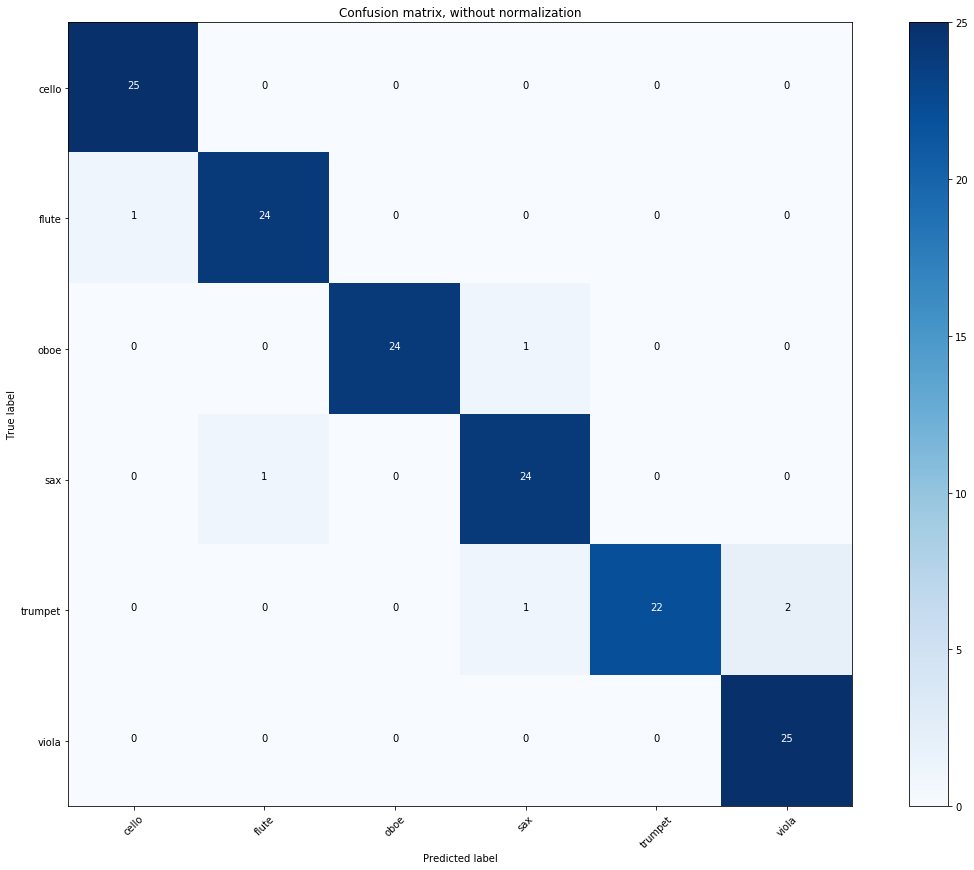

In [41]:
# Plot non-normalized confusion matrix
plt.figure(figsize=(16,12))
plot_confusion_matrix(cnf_matrix, classes=labelencoder.classes_,
                      title='Confusion matrix, without normalization')

In [42]:
# Find wrong predicted samples indexes
wrong_predictions = [i for i, (e1, e2) in enumerate(zip(test_classes, predictions_int)) if e1 != e2]

In [43]:
# Find wrong predicted audio files
print(np.array(labels)[test_index[wrong_predictions]])
print(predictions_labels[wrong_predictions].T)
print(np.array(files)[test_index[wrong_predictions]])

['oboe' 'flute' 'sax' 'trumpet' 'trumpet' 'trumpet']
['sax' 'cello' 'flute' 'viola' 'sax' 'viola']
['./audio/london_phill_dataset_multi/oboe/oboe_Ds6_05_fortissimo_normal.mp3'
 './audio/london_phill_dataset_multi/flute/flute_Gs5_025_forte_normal.mp3'
 './audio/london_phill_dataset_multi/sax/saxophone_A3_15_fortissimo_normal.mp3'
 './audio/london_phill_dataset_multi/trumpet/trumpet_A3_05_pianissimo_normal.mp3'
 './audio/london_phill_dataset_multi/trumpet/trumpet_A3_05_forte_normal.mp3'
 './audio/london_phill_dataset_multi/trumpet/trumpet_Cs4_15_pianissimo_normal.mp3']


In [44]:
best_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_443 (Dense)            (None, 12)                168       
_________________________________________________________________
dense_444 (Dense)            (None, 6)                 78        
Total params: 246
Trainable params: 246
Non-trainable params: 0
_________________________________________________________________
